# Base pipeline selection

## Importing, EDA and preprocessing

### Importing modules and cleaning data


In [ ]:
# Importing necessary modules
import numpy as np
import pandas as pd
import scipy
import statistics as stats
from statsmodels.tsa.stattools import adfuller
import math
import datetime as dt

# Data visualisation
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits import mplot3d
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Encoding and preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from statsmodels.tsa.arima.model import ARIMA as Arima
    # Blacker box models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Scoring
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Loading and combining data

Jan_1990_df=pd.read_csv("Raw data\rfp-approval-date-1990-1999.csv")
Jan_2000_df=pd.read_csv("Raw data\rfp-approval-date-2000-feb-2012.csv")
Mar_2012_df=pd.read_csv("Raw data\rfp-regdate-from-mar-2012-to-dec-2014.csv")
Jan_2015_pd=pd.read_csv("Raw data\rfp-regdate-from-jan-2015-to-dec-2016.csv")
Jan_2017_pd=pd.read_csv("Raw data\rfp-regdate-from-jan-2015-to-dec-2016.csv")

df_raw=pd.concat([Jan_1990_df, Jan_2000_df, Mar_2012_df, Jan_2015_pd, Jan_2017_pd], ignore_index=True)
df_raw.head(1)

month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   

   floor_area_sqm flat_model  lease_commence_date  resale_price  \
0            31.0   IMPROVED                 1977        9000.0   

  remaining_lease  
0             NaN

In [ ]:
# Cleaning strings and formatting datetimes

df_raw["month"]=pd.to_datetime(df_raw["month"], format="%Y-%m-%d")
df_raw["lease_commence_date"]=pd.to_datetime(df_raw["lease_commence_date"], format="%Y")
df_raw["remaining_lease"]=df_raw["month"]-df_raw["lease_commence_date"]
df_raw["remaining_lease"]=(99-((df_raw["remaining_lease"].dt.days)/365.25)).round(decimals=0)

# Dealing with storey range
df_raw["storey_range"]=((df_raw["storey_range"].str.slice(0, 2).astype('int'))+(df_raw["storey_range"].str.slice(-2,).astype('int')))/2

# Cleaning strings
for column in df_raw:
    try: df_raw[column]=df_raw[column].str.upper()
    except: pass
    try: df_raw[column]=df_raw[column].str.replace("-", " ")
    except: pass

# Truncating of categoricals
CAT_TRUNCATION_TOLERANCE=0.05 # Drop rows of targetted data that appears less than this percentage relative to entire dataset
df_stratified = pd.DataFrame()
target_columns=["town", "flat_type", "flat_model"]
pcts={}
total=len(df_raw.index)

for column in target_columns:
    uniques=df_raw[column].unique()
    pcts[column]={}
    col_ave=total/len(uniques)
    for unique in uniques:
        count=len(df_raw[df_raw[column]==unique])
        pcts[column][unique]=count/col_ave

for column in target_columns:
    for key in pcts[column].keys():
        if pcts[column][key]<=CAT_TRUNCATION_TOLERANCE:
            indices = df_raw[df_raw[column]==key].index
            df_raw.drop(indices, inplace=True)

# Extracting and formatting inflation data
"""Inflation data is current up to April 2023. Therefore, rows with transactions after that are discarded to maintain model accuracy.
Total inflation was used instead of housing inflation to ensure that prices in the data to be analysed refers to real prices"""
inflation_pd=pd.read_csv("Raw data\Inflation_data.csv")
inflation_pd["datekey"]=(inflation_pd["Year"]*100+inflation_pd["Month"]).astype(int)
inflation_pd=inflation_pd[["datekey", "Inflation (2019 is base)"]]
inflation_pd=inflation_pd.rename(columns={"Inflation (2019 is base)": "inflation_base_2019"})

# Conducting inner join of inflation data and formatting df_raw
df_raw["datekey"]=df_raw["month"].dt.year*100+df_raw["month"].dt.month # datekey is an int64
df_raw=df_raw.join(inflation_pd.set_index('datekey'), on='datekey')
df_raw=df_raw[df_raw["inflation_base_2019"].isna()==False] # discarding of data without inflation value
df_raw["resale_price"]=df_raw["resale_price"]/((df_raw["inflation_base_2019"])/100)
df_raw=df_raw.drop(columns=["inflation_base_2019"]) # Dropping inflation data

# Renaming and reordering df_raw columns
df_raw=df_raw.rename(columns={
    "month": "sale_date",
    "flat_type": "type",
    "street_name":"st_name",
    "storey_range": "storey",
    "floor_area_sqm":"size",
    "flat_model": "model",
    "lease_commence_date": "lease_start",
    "resale_price": "price",
    "remaining_lease":"lease_left"})
df_raw=df_raw[["town", "st_name", "type", "model", "storey", "size", "sale_date", "lease_start", "lease_left", "price"]]

display(df_raw.info())

<ipython-input-3-277832862dfc>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["resale_price"]=df_raw["resale_price"]/((df_raw["inflation_base_2019"])/100)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891634 entries, 4 to 898454
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   town         891634 non-null  object        
 1   st_name      891634 non-null  object        
 2   type         891634 non-null  object        
 3   model        891634 non-null  object        
 4   storey       891634 non-null  float64       
 5   size         891634 non-null  float64       
 6   sale_date    891634 non-null  datetime64[ns]
 7   lease_start  891634 non-null  datetime64[ns]
 8   lease_left   891634 non-null  float64       
 9   price        891634 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 74.8+ MB


None

### General exploratory Data Analysis

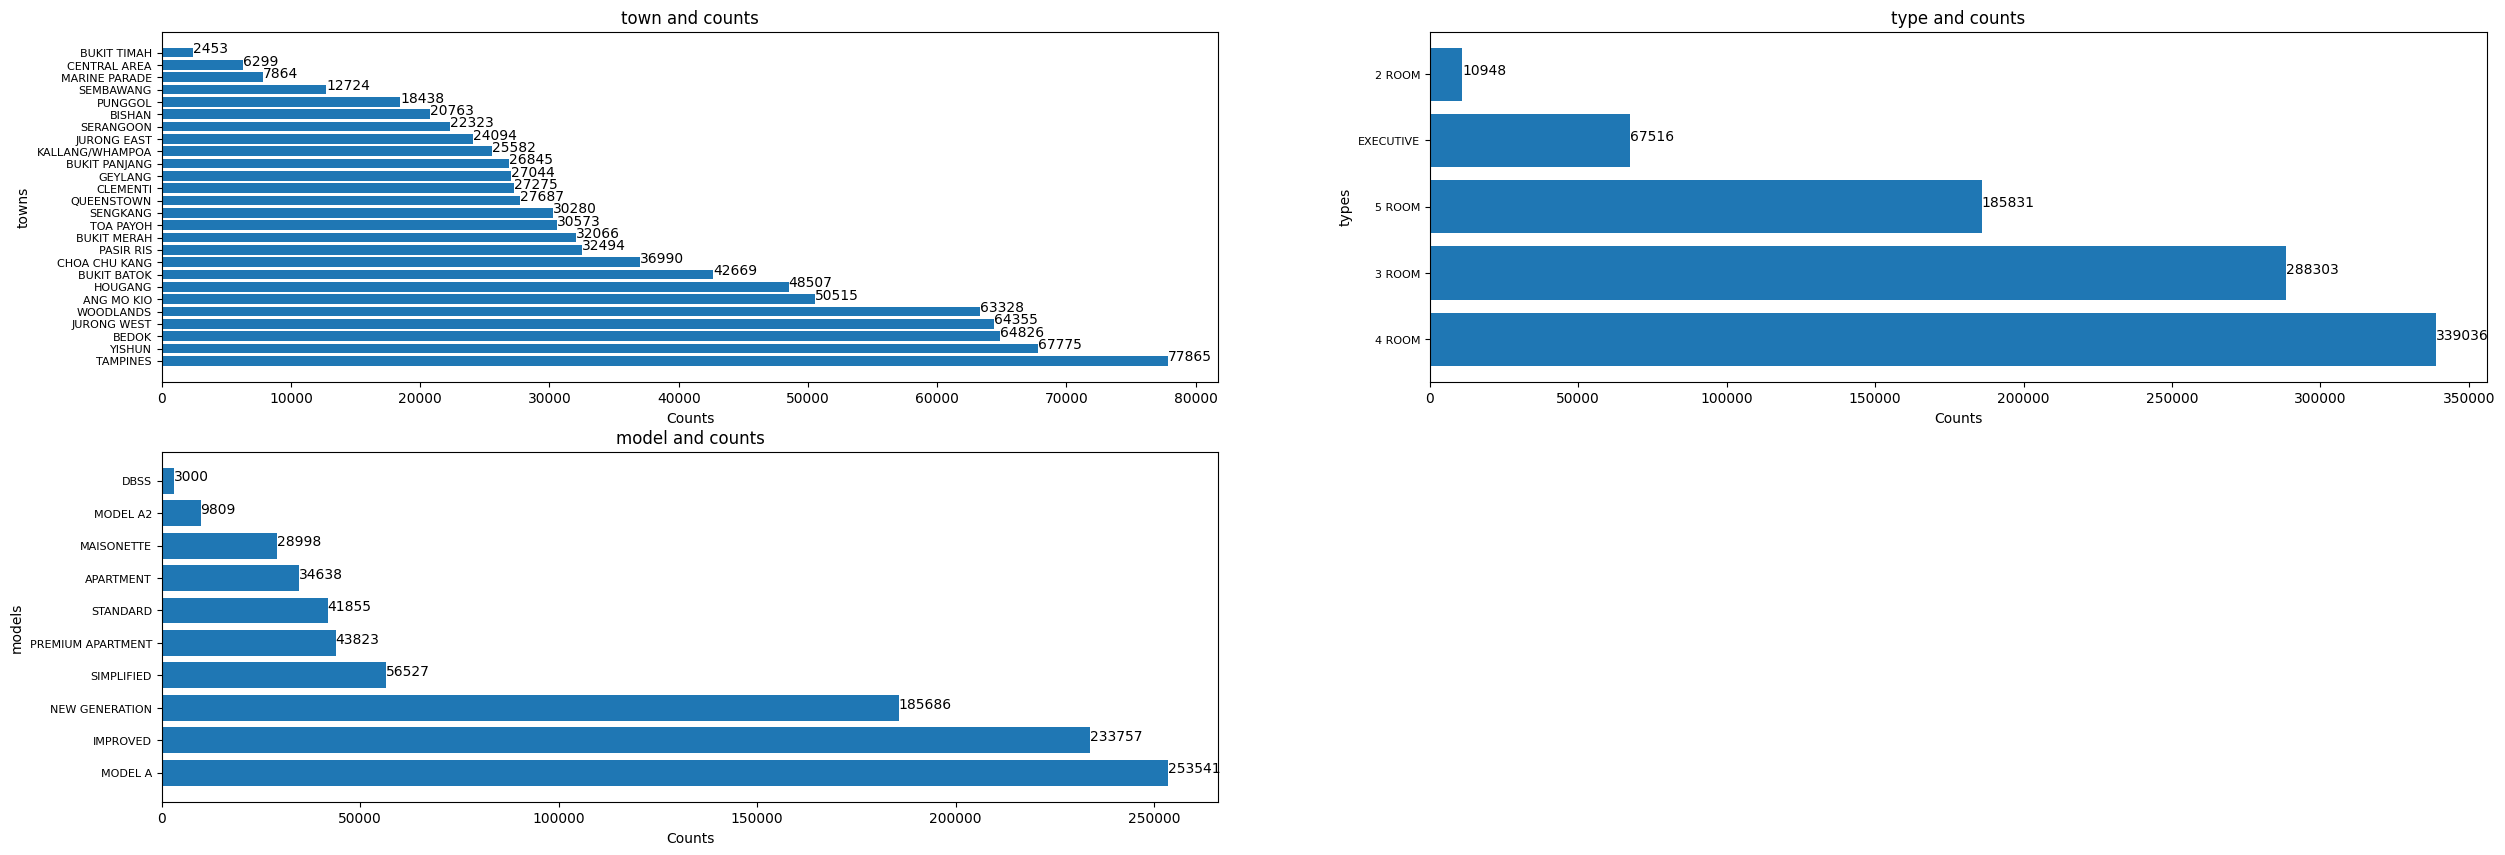

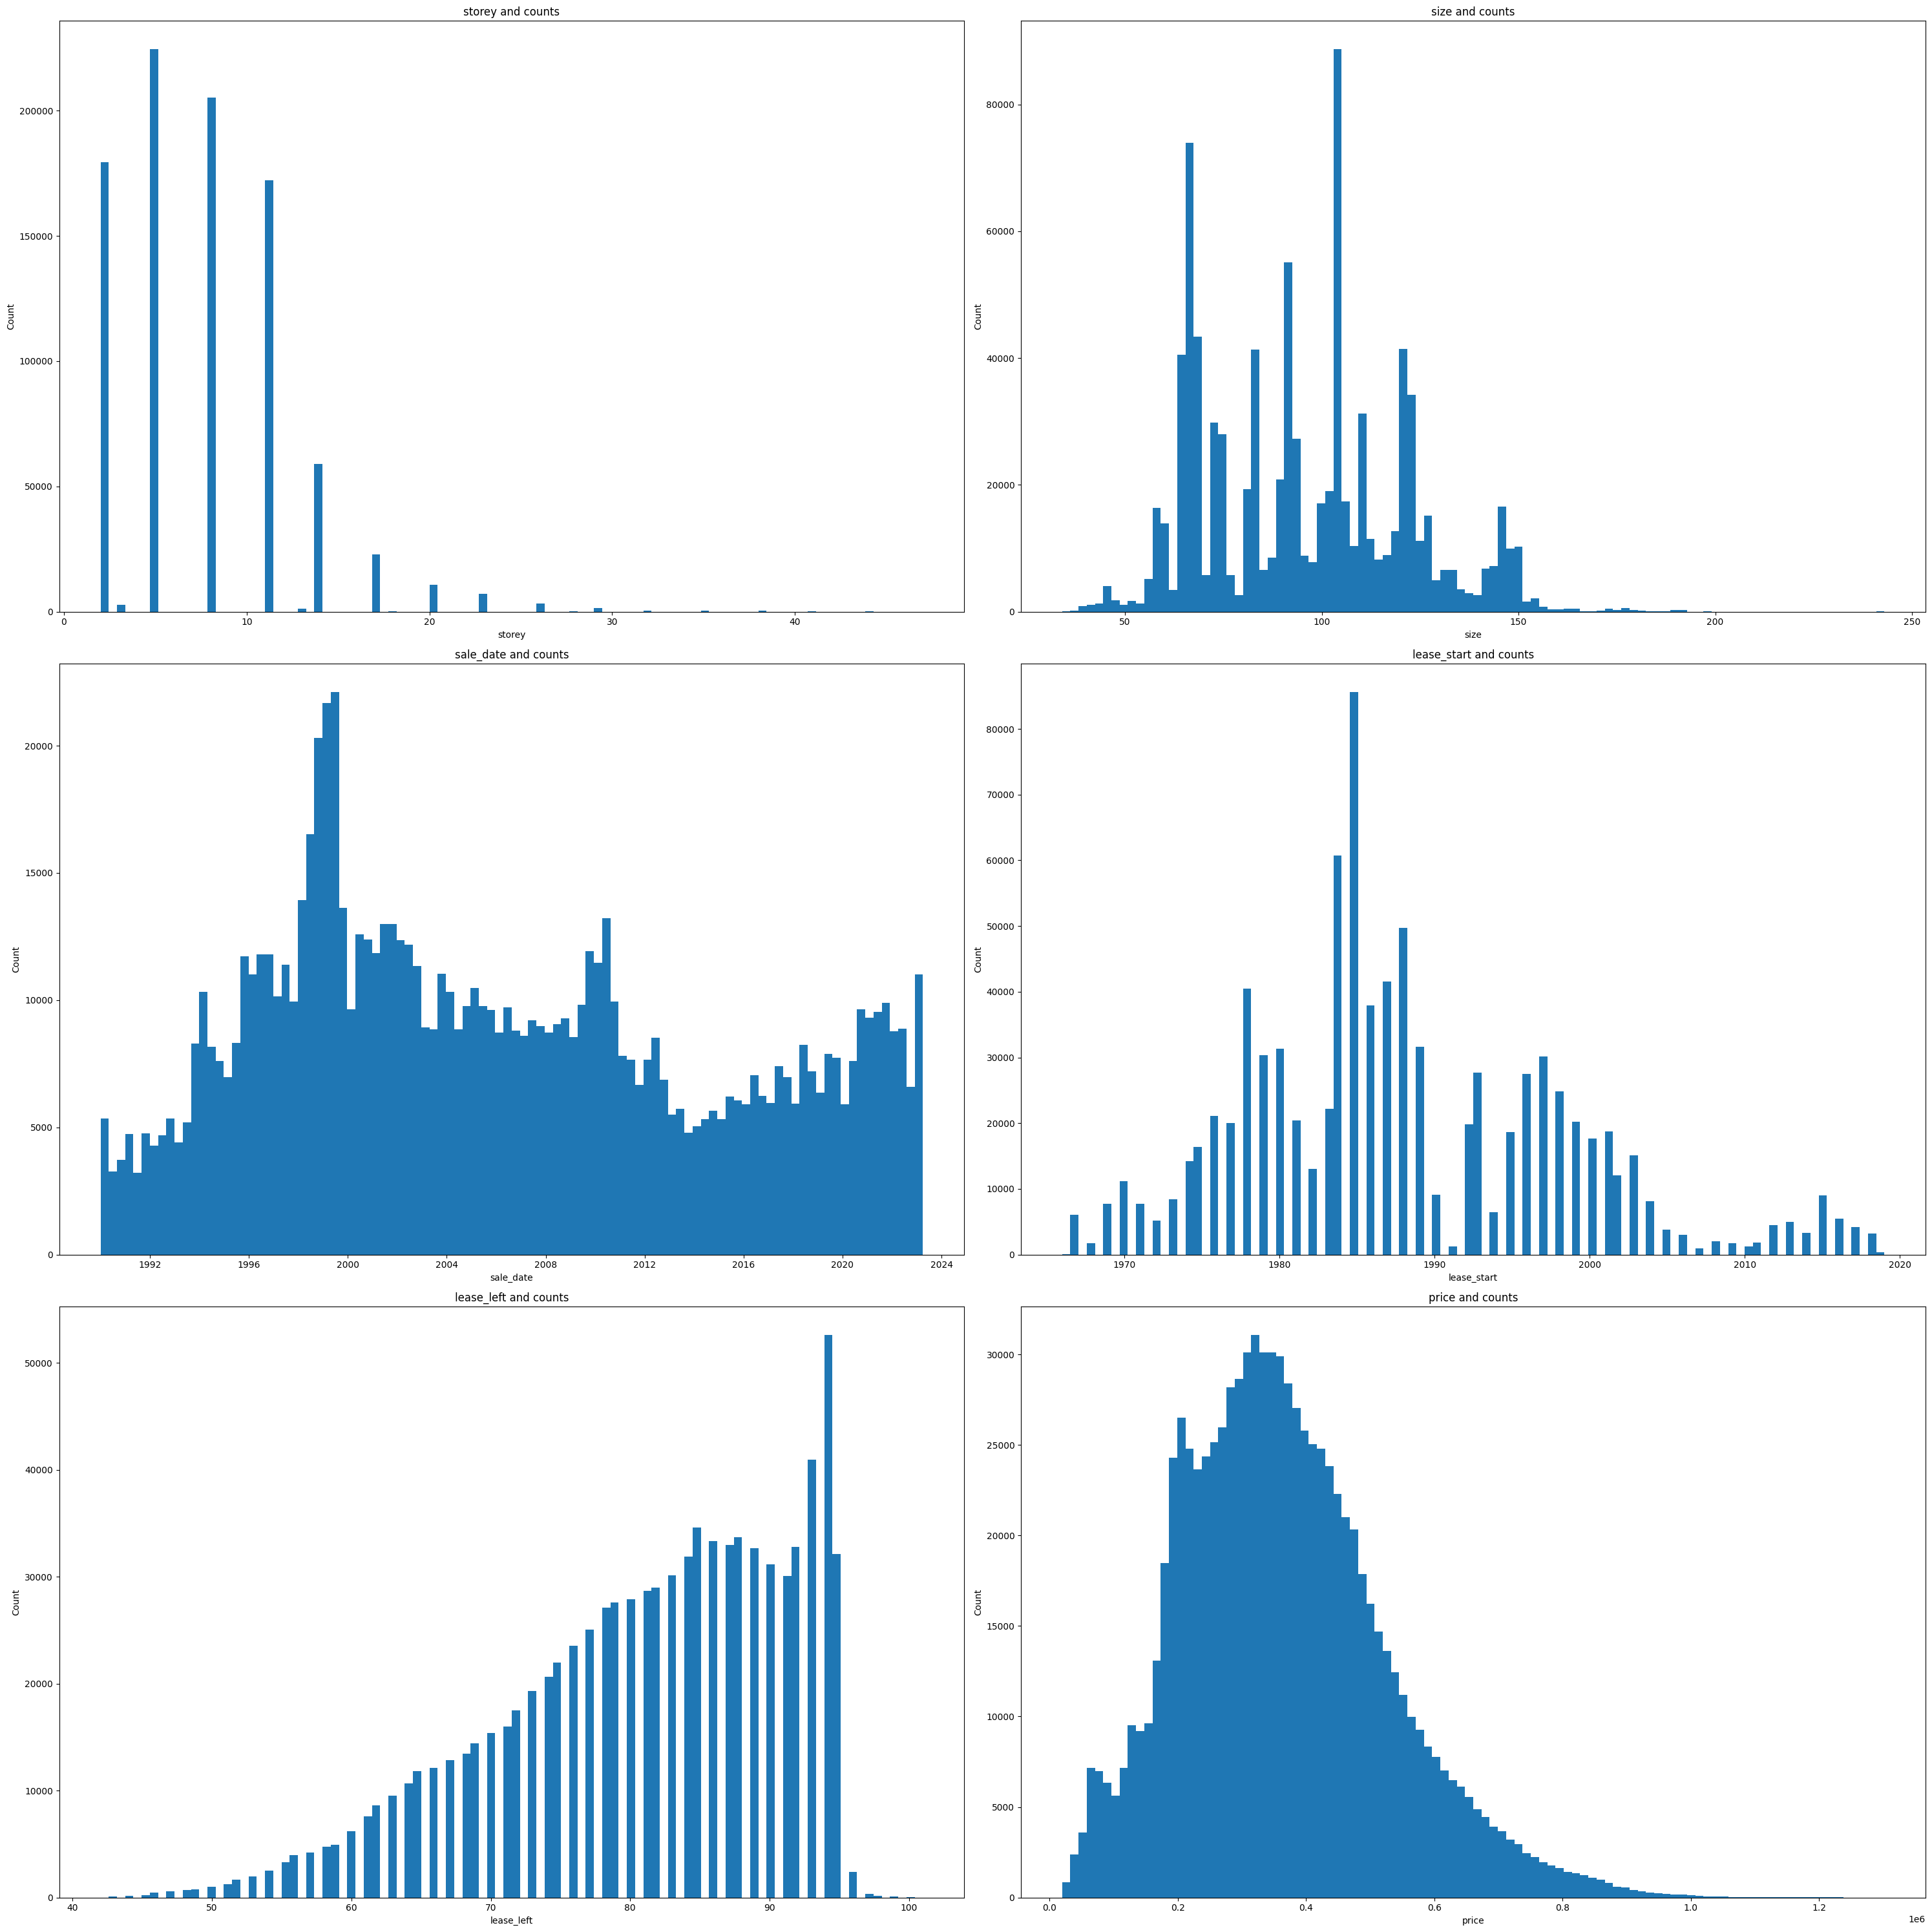


information about raw data as is formatted thus far:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891634 entries, 4 to 898454
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   town         891634 non-null  object        
 1   st_name      891634 non-null  object        
 2   type         891634 non-null  object        
 3   model        891634 non-null  object        
 4   storey       891634 non-null  float64       
 5   size         891634 non-null  float64       
 6   sale_date    891634 non-null  datetime64[ns]
 7   lease_start  891634 non-null  datetime64[ns]
 8   lease_left   891634 non-null  float64       
 9   price        891634 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 74.8+ MB


None


Correlation data: 


<ipython-input-5-037c4c99aad0>:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df_raw[columns].corr()) # to check for correlation between variables


storey      size  lease_left     price
storey      1.000000  0.047066    0.068362  0.232124
size        0.047066  1.000000    0.352634  0.709085
lease_left  0.068362  0.352634    1.000000  0.105860
price       0.232124  0.709085    0.105860  1.000000

p value for storey under a sharpiro-wilk test: 1.0383621620646894e-42
p value for size under a sharpiro-wilk test: 2.077399521229175e-24
p value for lease_left under a sharpiro-wilk test: 4.6371973789832723e-32
p value for price under a sharpiro-wilk test: 5.972730637477588e-20


In [ ]:
# EDA for feature distribution and null/nan prevalence

columns=["town", "type", "model"] #st_name cardinality too high, to settle throuhg other means in final report
fig=plt.figure(figsize=(30, 10))
for i, column in enumerate(columns):
    df_plot_groupby_counts=df_raw[column].value_counts()
    categories=df_plot_groupby_counts.index.astype(str)
    values=df_plot_groupby_counts.values

    fig.add_subplot(2, 2, i+1)
    plt.barh(categories, values)
    plt.yticks(fontsize=8)
    plt.ylabel(f"{column}s")
    plt.xlabel("Counts")
    plt.title(f"{column} and counts")
    for ind, value in enumerate(values):
        plt.text(value, ind, value)
plt.show()

# EDA for non categorical features
columns=["storey", "size", "sale_date", "lease_start", "lease_left", "price"]
fig=plt.figure(figsize=(30, 30))
for i, column in enumerate(columns):
    fig.add_subplot(3, 2, i+1)
    plt.hist(df_raw[column], bins=100)
    plt.xlabel(f"{column}")
    plt.ylabel("Count")
    plt.title(f"{column} and counts")
fig.tight_layout()
plt.show()

print("\ninformation about raw data as is formatted thus far:")
display(df_raw.info()) # determine if there are any nans or nulls
print("\nCorrelation data: ")
display(df_raw[columns].corr()) # to check for correlation between variables

# checking for fit to gaussian distribution
columns=["storey", "size", "lease_left", "price"]
for column in columns:
    print(f"p value for {column} under a sharpiro-wilk test: {scipy.stats.shapiro((df_raw.sample(n=3000)[column])).pvalue}")

# We can therefore conclude that the distribution of the numerical data does not follow a gaussian distribution, as expected
# This is as all the p-values for the sharpiro-wilk tests are under 0.05

# Notes
""" EDA found that there are only 2 instances where the number of flats sold per street was under 5.
# Therefore, street name is indeed useful, especially considering how it encodes information such as distance from MRT stations and the like
# However, the above analysis is beyond the scope of this project """
pass

### Preprocessing based on EDA


In [ ]:
# Defining columns (all including price)
categorical_columns=["price", "town", "type", "model"]
numerical_columns=["price", "storey", "size", "lease_left"]
time_columns=["price", "lease_start", "sale_date"]

normaliser_raw=MinMaxScaler(feature_range=(0, 1)).fit(df_raw[numerical_columns])
df_raw[numerical_columns]=normaliser_raw.transform(df_raw[numerical_columns])

# Defining reporting df for base models
base_model_report_df=pd.DataFrame(columns=["model",
                                           "best h-param",
                                           "mae",
                                           "mse",
                                           "err <05%",
                                           "err <10%",
                                           "err <15%",
                                           "err <20%",
                                           "err <25%",
                                           "err <30%"])

## Categorical data pipeline

In [ ]:
# Extracting data, sampling, splitting
    # Data is to be preprocessed as one hot vectors, and fed into
    # polynomial features to access interactions

# Defining critical information
df_cat=df_raw[categorical_columns].copy()
cat_features=categorical_columns[1:]

print("\nOverall categorical dataframe information")
display(df_cat.info())

# getting small subset of data for experimental purposes
# code block to be exluded in final model
no_samples=36
df_cat_sampled = pd.DataFrame()
for feature in cat_features:
    cat_data_stratified=df_cat.groupby(feature, as_index=False, sort=False, group_keys=False).apply(lambda x: x.sample(n=no_samples, random_state=1))
    # Using no_samples for speed on designing architecture. Note that this could lead to inaccuracies in scoring
    df_cat_sampled=pd.concat([df_cat_sampled, cat_data_stratified])
df_cat=df_cat_sampled.drop_duplicates()

print("\nOverall categorical dataframe after intial sampling information")
print(df_cat.info())

# generating samples in stratified manner, to encompass all categorical classes
frac_samples=0.4 # actual fraction extracted is significantly more than this
df_cat_sampled = pd.DataFrame()
for feature in cat_features:
    cat_data_stratified=df_cat.groupby(feature, as_index=False, sort=False, group_keys=False).apply(lambda x: x.sample(frac=frac_samples, random_state=1))
    df_cat_sampled=pd.concat([df_cat_sampled, cat_data_stratified])
df_cat_sampled=df_cat_sampled.drop_duplicates()

cat_sampled_indices=df_cat_sampled.index.values
df_cat_unsampled=df_cat.drop(index=cat_sampled_indices)

print("\nSampled categorical dataframe information")
print(df_cat_sampled.info())
print("\nUnsampled categorical dataframe information")
print(df_cat_unsampled.info())


# Note that including st_name will mandate value truncation if frac is used to split the pd, as the number to sample under frac is rounded down
# Note that including st_name will mandate replace=True for n_samples more than 1
# Note also that using frac will also somehow lead to percentage of population sampled being more than the given frac lmao,
# while dropping duplicates will lead to it being less (though not by a lot)


Overall categorical dataframe information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891634 entries, 4 to 898454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   891634 non-null  float64
 1   town    891634 non-null  object 
 2   type    891634 non-null  object 
 3   model   891634 non-null  object 
dtypes: float64(1), object(3)
memory usage: 34.0+ MB


None


Overall categorical dataframe after intial sampling information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475 entries, 614503 to 772749
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1475 non-null   float64
 1   town    1475 non-null   object 
 2   type    1475 non-null   object 
 3   model   1475 non-null   object 
dtypes: float64(1), object(3)
memory usage: 57.6+ KB
None

Sampled categorical dataframe information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 209077 to 703099
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1151 non-null   float64
 1   town    1151 non-null   object 
 2   type    1151 non-null   object 
 3   model   1151 non-null   object 
dtypes: float64(1), object(3)
memory usage: 45.0+ KB
None

Unsampled categorical dataframe information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries

In [ ]:
# Preprocessing data
    # fit encoder to entire df_cat_sampled data (it contains all possible values)
    # seperate label
    # transform remaining data
    # polynomialise data

# naive train test split using stratified samples
y_train_cat=df_cat_sampled["price"].to_numpy()
x_train_cat=df_cat_sampled.drop(columns=["price"]).copy()
y_test_cat=df_cat_unsampled["price"].to_numpy()
x_test_cat=df_cat_unsampled.drop(columns=["price"]).copy()

# fitting and transforming encoder to whole dataset
categorical_encoder=OneHotEncoder(sparse_output=True).fit(df_cat.drop(columns=["price"]))
x_train_cat=categorical_encoder.transform(x_train_cat)
x_test_cat=categorical_encoder.transform(x_test_cat)

# polynomialising data as needed
poly_transformer_cat=PolynomialFeatures(len(categorical_encoder.categories_), interaction_only=True)
x_train_cat=poly_transformer_cat.fit_transform(x_train_cat)
x_test_cat=poly_transformer_cat.transform(x_test_cat)


# generating dataframe for personal visualisation
# this dataframe is unlikely to be used for any final report
categorical_categories=np.concatenate(categorical_encoder.categories_, axis=0)
categorical_categories=poly_transformer_cat.get_feature_names_out(categorical_categories)
x_train_cat_df=pd.DataFrame.sparse.from_spmatrix(data=x_train_cat, columns=categorical_categories)

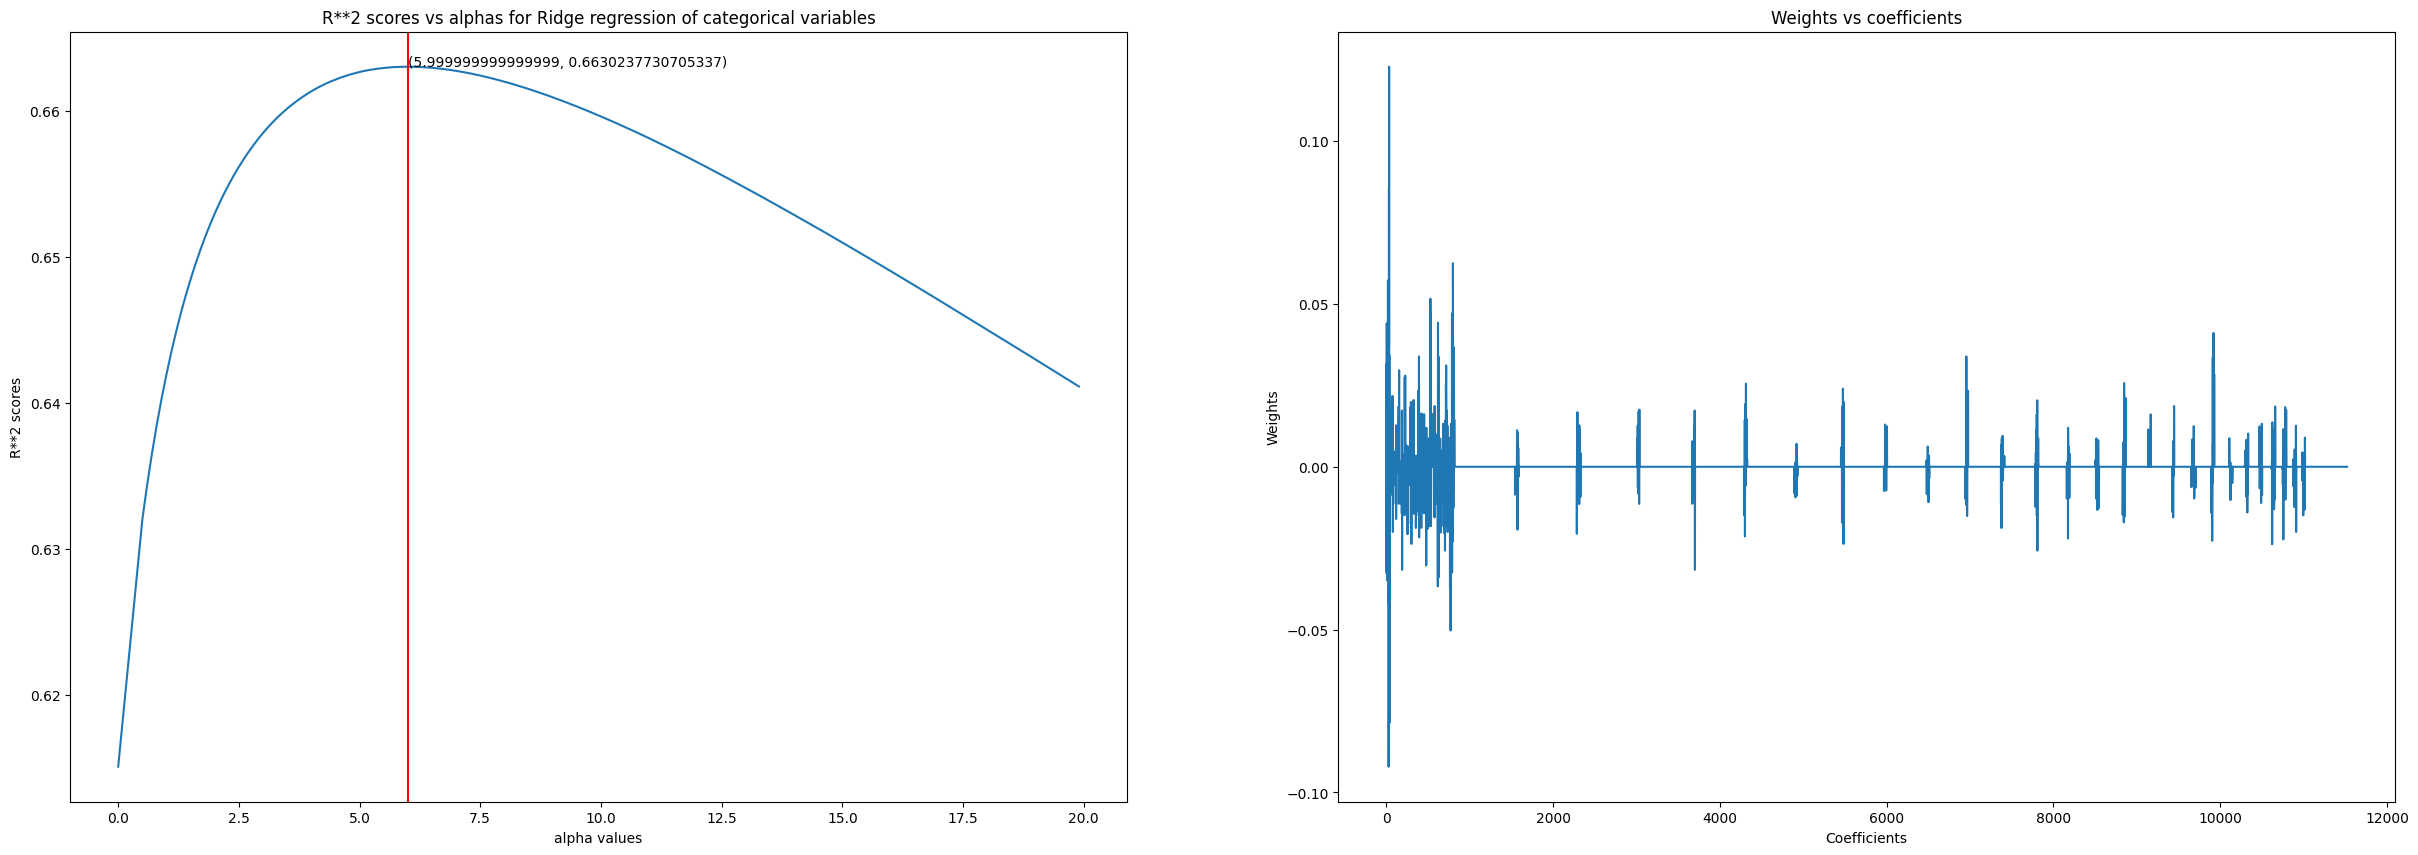

Best alpha: 5.999999999999999
R2 score: 0.7166248730039977
MSE: 0.006366416921140866
Mean of weights: -3.37248792413474e-20
Variance of weights: 1.587703122207328e-05


<ipython-input-13-ca5bbfcb7bfb>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_report_df=base_model_report_df.append({"model": "cat",


In [ ]:
# Multilinear polynomial regression

# Multi poly reg model (raw)
scores={}
linreg_score = cross_validate(LinearRegression(), x_train_cat, y_train_cat, cv=5, scoring=('r2'))
scores[0]=linreg_score["test_score"].mean()

alphas=np.arange(0.5, 20, 0.1)
for alpha in alphas:
    # Selecting best alpha using k fold cross validation and R2 metric
    linreg_score=cross_validate(Ridge(alpha=alpha), x_train_cat, y_train_cat, cv=5, scoring=('r2'))
    scores[alpha]=linreg_score["test_score"].mean()

# plotting the main figure demonstrating model performance for different alphas
alphas=list(scores.keys())
score_vals=list(scores.values())
best_a=alphas[score_vals.index(max(score_vals))]

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.plot(scores.keys(), scores.values())
plt.title("R**2 scores vs alphas for Ridge regression of categorical variables")
plt.xlabel("alpha values")
plt.ylabel("R**2 scores")
plt.axvline(x = best_a, color ='red')
plt.text(best_a, max(score_vals), f"({best_a}, {max(score_vals)})")

# regenerating best model
cat_model=Ridge(alpha=best_a).fit(x_train_cat, y_train_cat)
# dealing with parameters
fig.add_subplot(1, 2, 2)
weights=cat_model.coef_
plt.plot(np.arange(0, len(weights), 1), weights)
plt.title("Weights vs coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Weights")
plt.show()

y_preds_cat=cat_model.predict(x_test_cat)

mae_cat=mean_absolute_error(y_test_cat, y_preds_cat)
mse_cat=mean_squared_error(y_test_cat, y_preds_cat)
cat_errors=abs(y_test_cat-y_preds_cat)
cat_err_05=(sum(cat_errors<0.05))/(len(cat_errors))
cat_err_10=(sum(cat_errors<0.10))/(len(cat_errors))
cat_err_15=(sum(cat_errors<0.15))/(len(cat_errors))
cat_err_20=(sum(cat_errors<0.20))/(len(cat_errors))
cat_err_25=(sum(cat_errors<0.25))/(len(cat_errors))
cat_err_30=(sum(cat_errors<0.30))/(len(cat_errors))
base_model_report_df=base_model_report_df.append({"model": "cat",
                                                  "best h-param": f"a={best_a}",
                                                  "mae": mae_cat,
                                                  "mse": mse_cat,
                                                  "err <05%": cat_err_05,
                                                  "err <10%": cat_err_10,
                                                  "err <15%": cat_err_15,
                                                  "err <20%": cat_err_20,
                                                  "err <25%": cat_err_25,
                                                  "err <30%": cat_err_30}, ignore_index=True)


print(f"Best alpha: {best_a}")
print(f"R2 score: {cat_model.score(x_test_cat, y_test_cat)}")
print(f"MSE: {mse_cat}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")

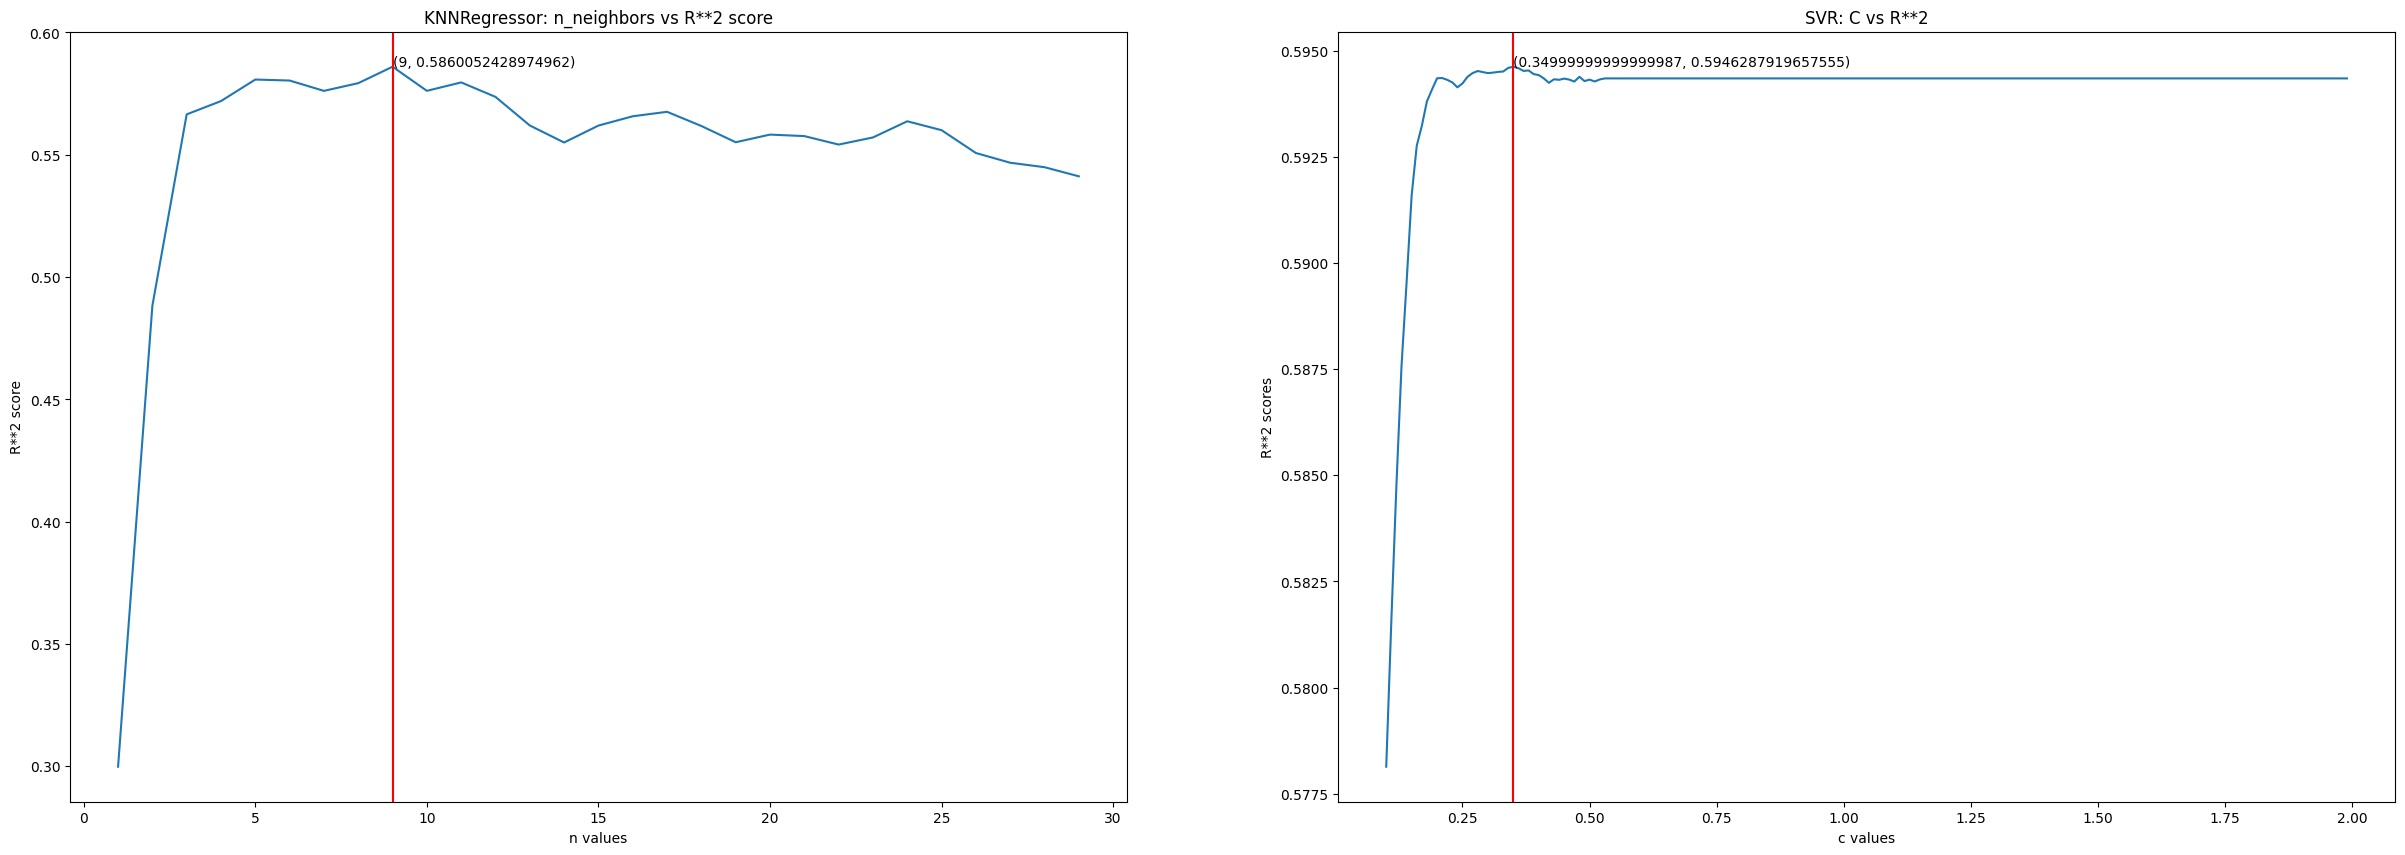

For KNN:
Best n: 9
R2 score: 0.6571352853333667
MSE: 0.007702933367001483
Effective inaccuracy: 131954.78098575637
Mean of weights: -3.37248792413474e-20
Variance of weights: 1.587703122207328e-05

For SVR:
Best c: 0.34999999999999987
R2 score: 0.6862822419315071
MSE: 0.007048106390289526
Effective inaccuracy: 127062.89369473715
Mean of weights: -3.37248792413474e-20
Variance of weights: 1.587703122207328e-05



In [ ]:
# comparing blacker box models (KNNReg, SVM)
fig=plt.figure(figsize=(30, 10))

# KNN model

knn_neighbor_range=np.arange(1, 30, 1) # note: ties are handled based on data ordering (aka randomly) ._.
knn_scores={}
for n in knn_neighbor_range:
    knn_score=cross_validate(KNeighborsRegressor(n_neighbors=n), x_train_cat, y_train_cat, cv=5, scoring=('r2'))
    knn_scores[n]=knn_score["test_score"].mean()

ns=list(knn_scores.keys())
knn_score_vals=list(knn_scores.values())
best_n=ns[knn_score_vals.index(max(knn_score_vals))]

fig.add_subplot(1, 2, 1)
plt.plot(knn_scores.keys(), knn_scores.values())
plt.title("KNNRegressor: n_neighbors vs R**2 score")
plt.xlabel("n values")
plt.ylabel("R**2 score")
plt.axvline(x = best_n, color ='red')
plt.text(best_n, max(knn_score_vals), f"({best_n}, {max(knn_score_vals)})")

# SVM model
svr_scores={}
cs=np.arange(0.1, 2, 0.01)
for c in cs:
    svr_score=cross_validate(SVR(C=c), x_train_cat, y_train_cat, cv=5, scoring=('r2'))
    svr_scores[c]=svr_score["test_score"].mean()

cs=list(svr_scores.keys())
svr_score_vals=list(svr_scores.values())
best_c=cs[svr_score_vals.index(max(svr_score_vals))]

fig.add_subplot(1, 2, 2)
plt.plot(svr_scores.keys(), svr_scores.values())
plt.title("SVR: C vs R**2")
plt.xlabel("c values")
plt.ylabel("R**2 scores")
plt.axvline(x = best_c, color ='red')
plt.text(best_c, max(svr_score_vals), f"({best_c}, {max(svr_score_vals)})")
plt.show()


# Regenerating best models and reporting performance

# KNN
cat_knnreg=KNeighborsRegressor(n_neighbors=best_n).fit(x_train_cat, y_train_cat)
mse_cat=mean_squared_error(y_test_cat, cat_knnreg.predict(x_test_cat))
print("For KNN:")
print(f"Best n: {best_n}")
print(f"R2 score: {cat_knnreg.score(x_test_cat, y_test_cat)}")
print(f"MSE: {mse_cat}")
print(f"Effective inaccuracy: {normaliser_raw.inverse_transform([[np.sqrt(mse_cat),0,0,0]])[0][0]}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")
print()

# KNN
cat_svreg=SVR(C=best_c).fit(x_train_cat, y_train_cat)
mse_cat=mean_squared_error(y_test_cat, cat_svreg.predict(x_test_cat))
print("For SVR:")
print(f"Best c: {best_c}")
print(f"R2 score: {cat_svreg.score(x_test_cat, y_test_cat)}")
print(f"MSE: {mse_cat}")
print(f"Effective inaccuracy: {normaliser_raw.inverse_transform([[np.sqrt(mse_cat),0,0,0]])[0][0]}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")
print()

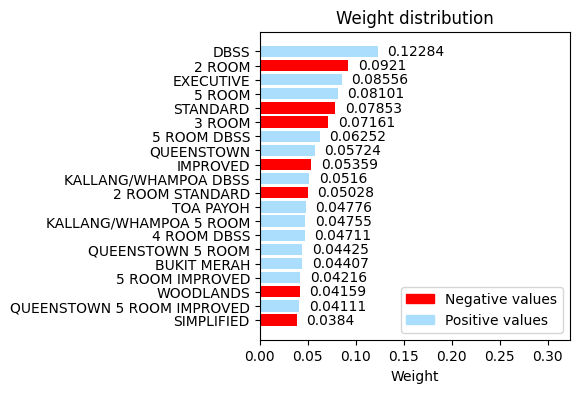

mean of weights (top 20): abs weight    0.060043
dtype: float64
variance of weights (top 20): abs weight    0.000486
dtype: float64
mean of weights (overall): abs weight    0.01177
dtype: float64
variance of weights (overall): abs weight    0.000161
dtype: float64


In [ ]:
# Conducting analysis of weights

# Selecting slice of top weights to be shown
TOP_N=20


df_exp=pd.DataFrame(data={
    "weights": weights,
    "abs weight":np.absolute(weights)}, index=categorical_categories,)
df_exp.sort_values(by=["abs weight"], inplace=True, ascending=False)
df_exp = df_exp[df_exp['abs weight'] != 0]

df_exp_2=df_exp.head(TOP_N)
ypos=np.arange(0,len(df_exp_2.index))
colors = ["#abddfc" if i > 0 else "#ff0000" for i in df_exp_2["weights"]]

fig, ax=plt.subplots(figsize=(int(TOP_N/5), int(TOP_N/5)))
ax.barh(ypos, df_exp_2["abs weight"], color=colors)
ax.set_yticks(ypos, labels=df_exp_2.index)
ax.set_xlabel('Weight')
ax.set_title('Weight distribution')
ax.set_xlim(0, np.max(df_exp_2["abs weight"])+0.2) #setting xlim for texts to fit
for y, x in enumerate(df_exp_2["abs weight"]):
    ax.text(x+0.01, y, round(x, 5), va="center")
ax.invert_yaxis()  # labels read top-to-bottom
legend_elements = [Patch(facecolor='#ff0000', edgecolor='#ff0000', label='Negative values'),
                   Patch(facecolor='#abddfc', edgecolor='#abddfc', label='Positive values')]
ax.legend(handles=legend_elements, loc="lower right")
plt.show()

print(f"mean of weights (top {TOP_N}): {df_exp_2[['abs weight']].mean()}")
print(f"variance of weights (top {TOP_N}): {df_exp_2[['abs weight']].var()}")

print(f"mean of weights (overall): {df_exp[['abs weight']].mean()}")
print(f"variance of weights (overall): {df_exp[['abs weight']].var()}")

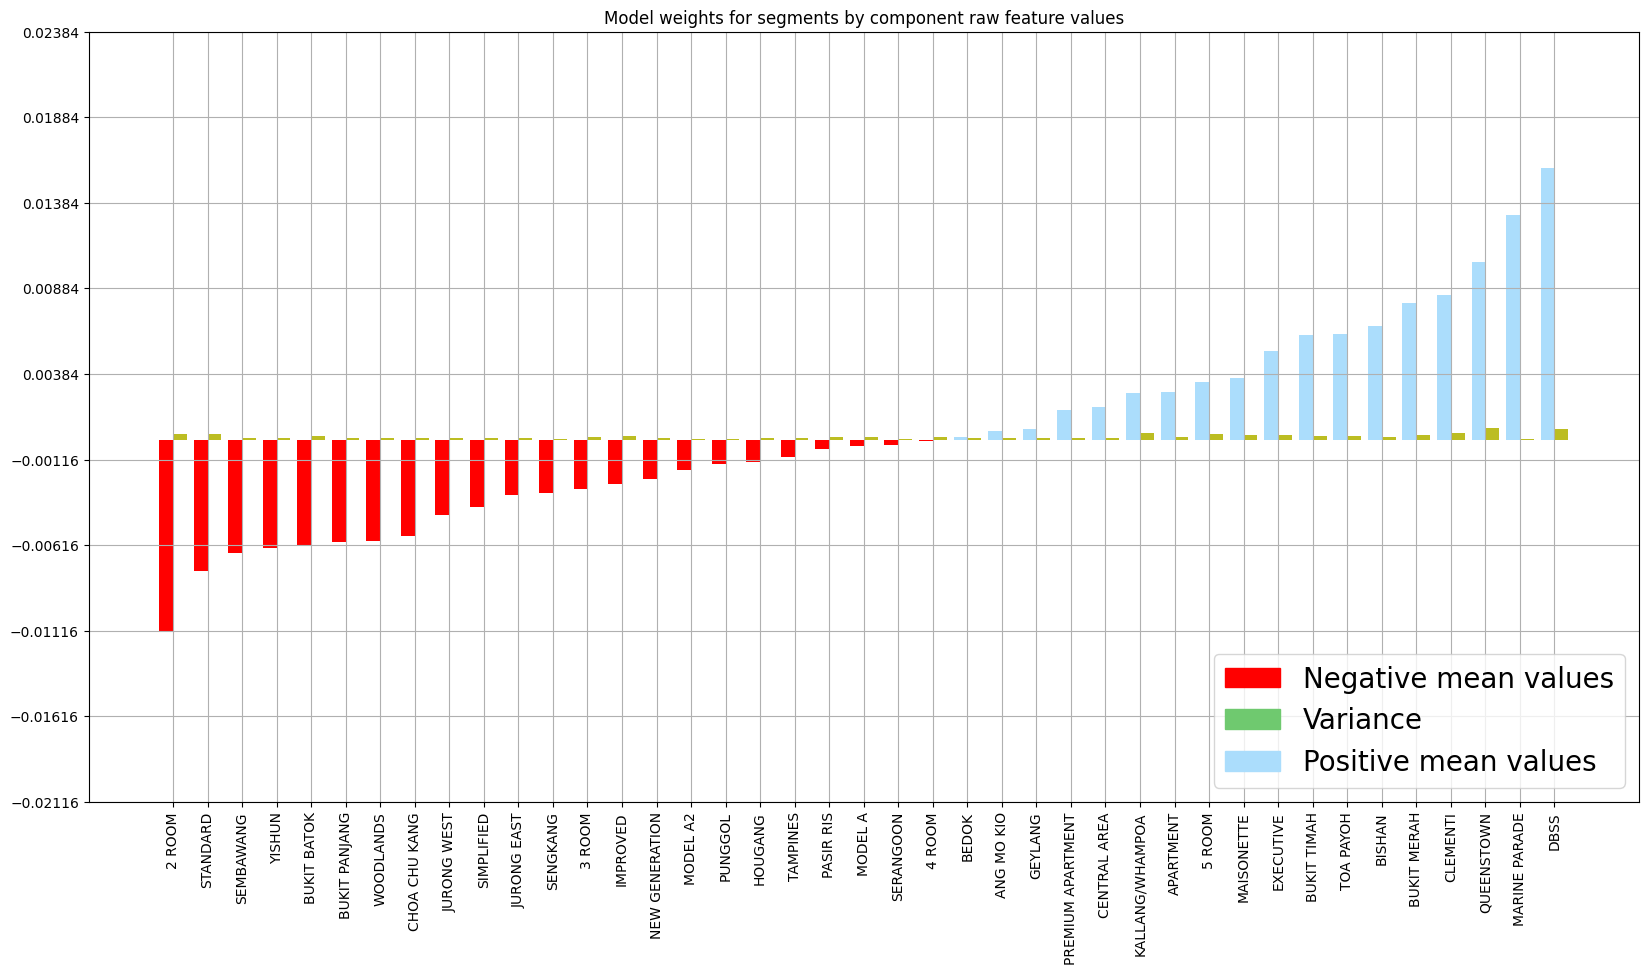

cat_component  weight mean  weight var
0              2 ROOM    -0.011163    0.000338
1            STANDARD    -0.007661    0.000328
2           SEMBAWANG    -0.006620    0.000090
3              YISHUN    -0.006341    0.000099
4         BUKIT BATOK    -0.006182    0.000198
5       BUKIT PANJANG    -0.005982    0.000079
6           WOODLANDS    -0.005941    0.000109
7       CHOA CHU KANG    -0.005639    0.000067
8         JURONG WEST    -0.004376    0.000093
9          SIMPLIFIED    -0.003939    0.000090
10        JURONG EAST    -0.003256    0.000123
11           SENGKANG    -0.003107    0.000054
12             3 ROOM    -0.002893    0.000162
13           IMPROVED    -0.002583    0.000221
14     NEW GENERATION    -0.002289    0.000124
15           MODEL A2    -0.001771    0.000037
16            PUNGGOL    -0.001444    0.000055
17            HOUGANG    -0.001281    0.000121
18           TAMPINES    -0.001003    0.000123
19          PASIR RIS    -0.000559    0.000131
20            MODEL A    -0.000353    0.000168
21          SERANGOON    -0.000303    0.000062
22             4 ROOM    -0.000095    0.000166
23              BEDOK     0.000127    0.000078
24         ANG MO KIO     0.000509    0.000123
25            GEYLANG     0.000638    0.000095
26  PREMIUM APARTMENT     0.001736    0.000092
27       CENTRAL AREA     0.001902    0.000103
28    KALLANG/WHAMPOA     0.002725    0.000361
29          APARTMENT     0.002773    0.000127
30             5 ROOM     0.003376    0.000308
31         MAISONETTE     0.003617    0.000247
32          EXECUTIVE     0.005185    0.000275
33        BUKIT TIMAH     0.006090    0.000240
34          TOA PAYOH     0.006163    0.000219
35             BISHAN     0.006653    0.000161
36        BUKIT MERAH     0.008012    0.000247
37           CLEMENTI     0.008443    0.000368
38         QUEENSTOWN     0.010407    0.000688
39      MARINE PARADE     0.013134    0.000061
40               DBSS     0.015850    0.000650

In [ ]:
# Analysis of weights for interaction features wrt raw components
original_cat_categories=np.concatenate(categorical_encoder.categories_, axis=0)

cat_component_data_df=pd.DataFrame(columns=[
    "cat_component", "weights", "weight mean", "weight var"
])
for category in original_cat_categories:
    targetted_indices=df_exp.index.str.contains(category, regex=False)
    data=df_exp["weights"][targetted_indices].values

    df_tmp=pd.DataFrame.from_dict({
        "cat_component": [category],
        "weights": [data],
        "weight mean": [np.mean(data)],
        "weight var": [np.var(data)]
    })
    cat_component_data_df=pd.concat([cat_component_data_df, df_tmp])

formatted_cat_component_data_df=cat_component_data_df.drop(columns="weights").sort_values("weight mean")
w_means=formatted_cat_component_data_df["weight mean"]
w_vars=formatted_cat_component_data_df["weight var"]

fig, ax=plt.subplots(figsize=(20, 10))
X_axis=np.arange(len(cat_component_data_df))
colors = ['#abddfc' if i > 0 else '#ff0000' for i in w_means]
plt.bar(X_axis - 0.2, w_means, 0.4, label = 'Weight means', color=colors)
plt.bar(X_axis + 0.2, w_vars, 0.4, label = 'Weight variances', color='tab:olive')
ax.set_xticks(X_axis, labels=formatted_cat_component_data_df["cat_component"])
plt.xticks(rotation = 90)
plt.yticks(np.arange(min(w_means)-0.01, max(w_means)+0.01, 0.005))
legend_elements = [Patch(facecolor='#ff0000', edgecolor='#ff0000', label='Negative mean values'),
                   Patch(facecolor='#6fc96f', edgecolor='#6fc96f', label='Variance'),
                   Patch(facecolor='#abddfc', edgecolor='#abddfc', label='Positive mean values')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.grid()
plt.title("Model weights for segments by component raw feature values")
plt.show()

display(formatted_cat_component_data_df.reset_index(drop=True))

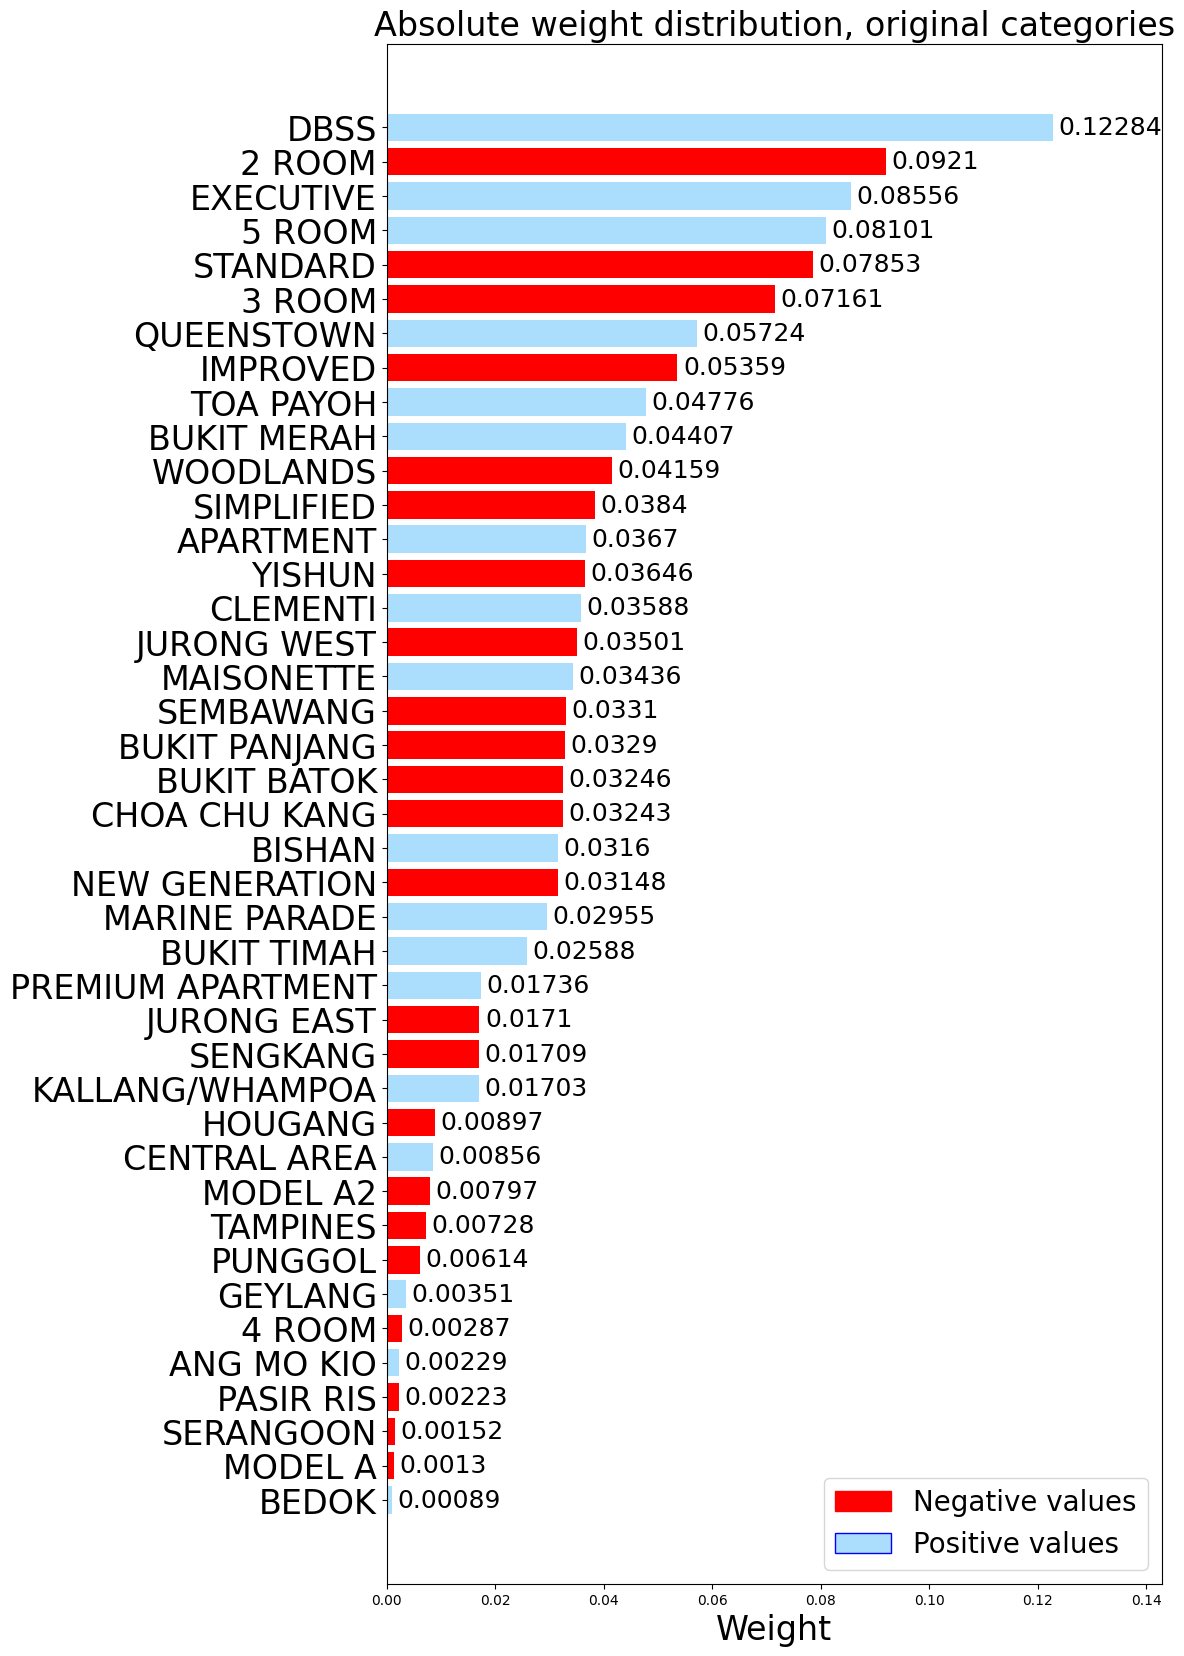

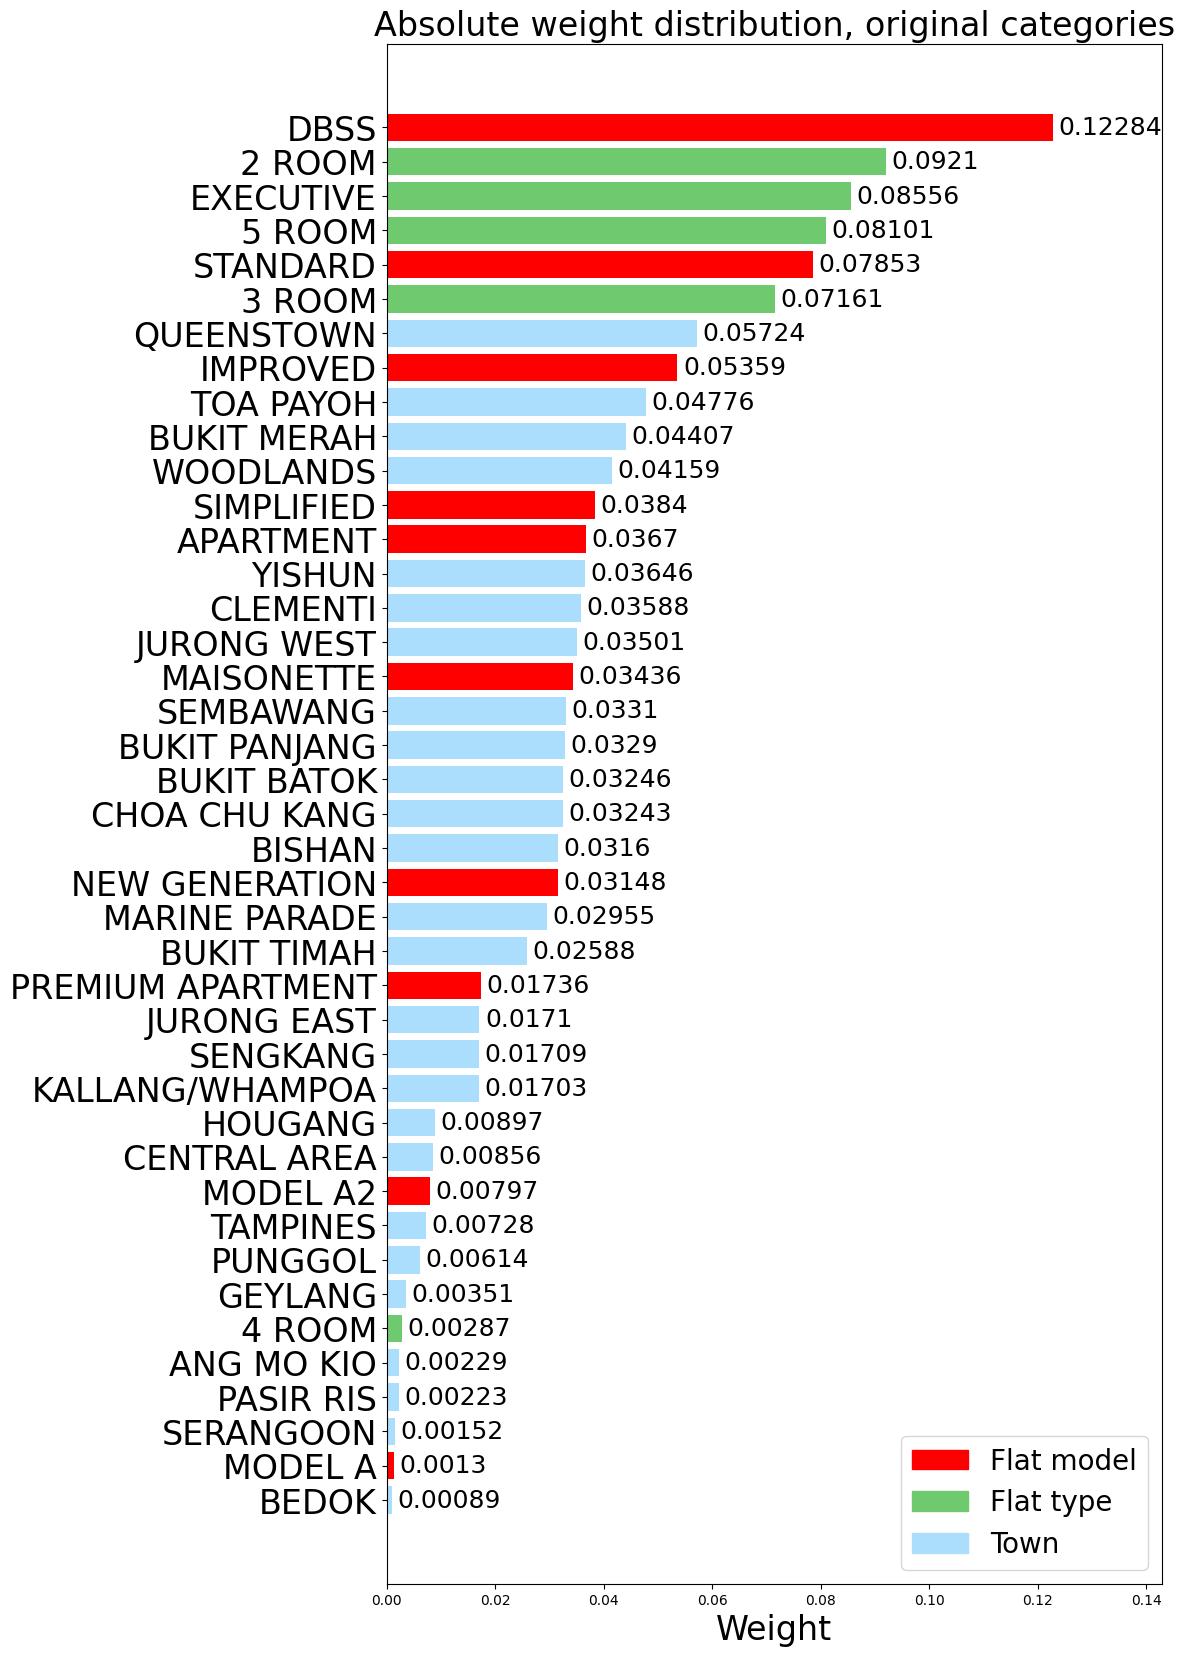

In [ ]:
# Analysis of weight distributions for raw features

original_cat_categories=np.concatenate(categorical_encoder.categories_, axis=0)

df_exp_2=df_exp[df_exp.index.isin(original_cat_categories)]
ypos=np.arange(0, len(df_exp_2.index))
colors = ["#abddfc" if i > 0 else "red" for i in df_exp_2["weights"]]
# Plotting relationship between weights and "raw" feature values
fig, ax=plt.subplots(figsize=(10, 20))
ax.barh(ypos, df_exp_2["abs weight"], color=colors)
ax.set_yticks(ypos, labels=df_exp_2.index, fontsize=24)
ax.set_xlabel('Weight', fontsize=24)
ax.set_xlim(0, max(df_exp_2["abs weight"])+0.02)
for y, x in enumerate(df_exp_2["abs weight"]):
    ax.text(x+0.001, y, round(x, 5), va="center", fontsize=18)
ax.set_title('Absolute weight distribution, original categories', fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
legend_elements = [Patch(facecolor='red', edgecolor='r', label='Negative values'),
                   Patch(facecolor='#abddfc', edgecolor='b', label='Positive values')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.show()

# Plotting relationship between weights and "raw" feature values, coloured by feature of origin
model_cats=df_cat["model"].unique()
type_cats=df_cat["type"].unique()
town_cats=df_cat["town"].unique()
color_codes=[(x in model_cats, x in type_cats, x in town_cats) for x in df_exp_2.index]
color_dict={(1,0,0):"#ff0000",
            (0,1,0):"#6fc96f",
            (0,0,1):"#abddfc"}
colors=[color_dict[key] for key in color_codes]

fig, ax=plt.subplots(figsize=(10, 20))
ax.barh(ypos, df_exp_2["abs weight"], color=colors)
ax.set_yticks(ypos, labels=df_exp_2.index, fontsize=24)
ax.set_xlabel('Weight', fontsize=24)
ax.set_xlim(0, max(df_exp_2["abs weight"])+0.02)
for y, x in enumerate(df_exp_2["abs weight"]):
    ax.text(x+0.001, y, round(x, 5), va="center", fontsize=18)
ax.set_title('Absolute weight distribution, original categories', fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
legend_elements = [Patch(facecolor='red', edgecolor='r', label='Flat model'),
                   Patch(facecolor='#6fc96f', edgecolor='#6fc96f', label='Flat type'),
                   Patch(facecolor='#abddfc', edgecolor='#abddfc', label='Town')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.show()

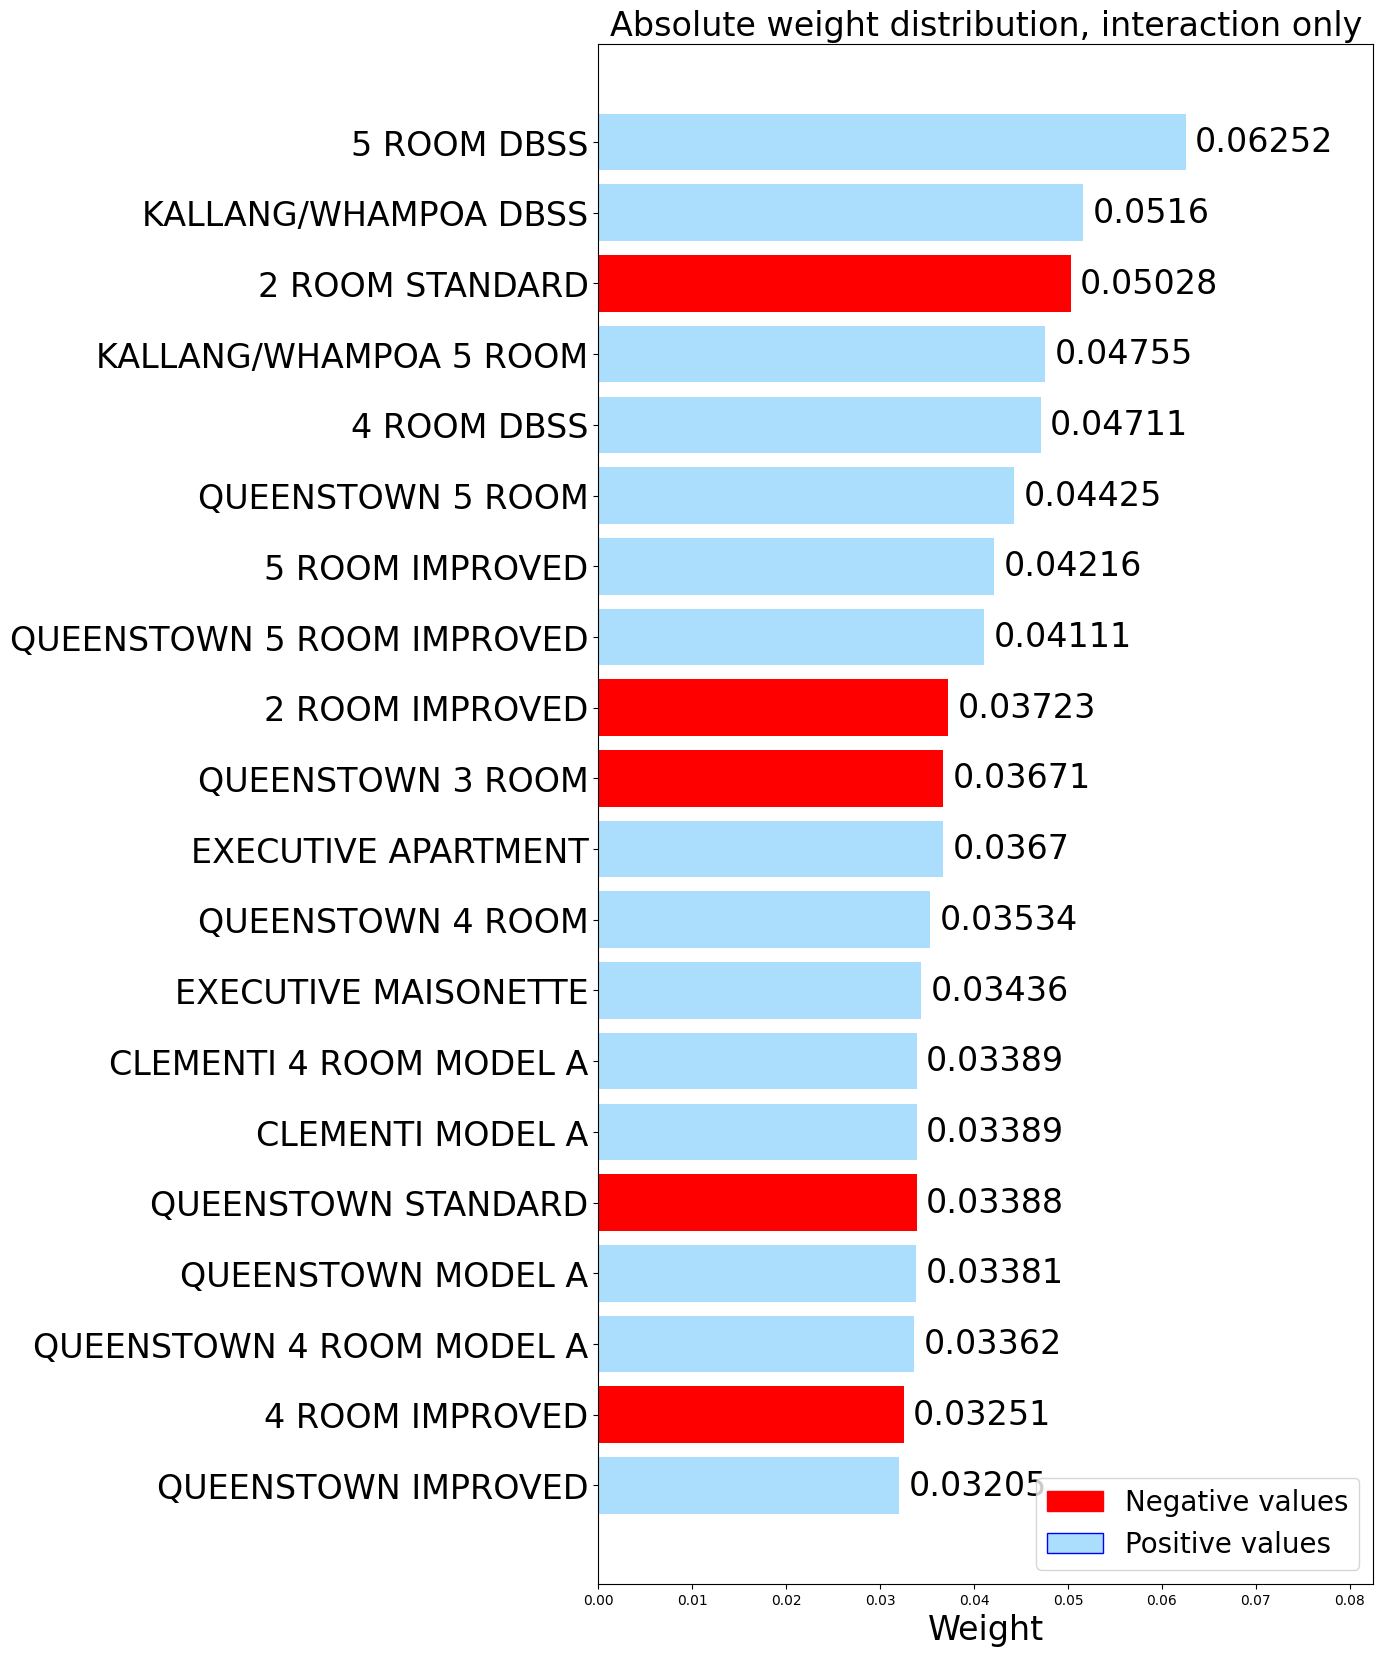

In [ ]:
# Analysis of weights for interaction features

original_cat_categories=np.concatenate(categorical_encoder.categories_, axis=0)

TOP_N=20

df_exp_2=df_exp[df_exp.index.isin(original_cat_categories)==False].head(TOP_N)
ypos=np.arange(0, len(df_exp_2.index))
colors = ["#abddfc" if i > 0 else "red" for i in df_exp_2["weights"]]
# Plotting relationship between weights and "raw" feature values
fig, ax=plt.subplots(figsize=(10, 20))
ax.barh(ypos, df_exp_2["abs weight"], color=colors)
ax.set_yticks(ypos, labels=df_exp_2.index, fontsize=24)
ax.set_xlabel('Weight', fontsize=24)
ax.set_xlim(0, max(df_exp_2["abs weight"])+0.02)
for y, x in enumerate(df_exp_2["abs weight"]):
    ax.text(x+0.001, y, round(x, 5), va="center", fontsize=24)
ax.set_title('Absolute weight distribution, interaction only', fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
legend_elements = [Patch(facecolor='red', edgecolor='r', label='Negative values'),
                   Patch(facecolor='#abddfc', edgecolor='b', label='Positive values')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.show()

## Numerical data pipeline

Overall numerical dataframe information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891634 entries, 4 to 898454
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   price       891634 non-null  float64
 1   storey      891634 non-null  float64
 2   size        891634 non-null  float64
 3   lease_left  891634 non-null  float64
dtypes: float64(4)
memory usage: 34.0 MB
None


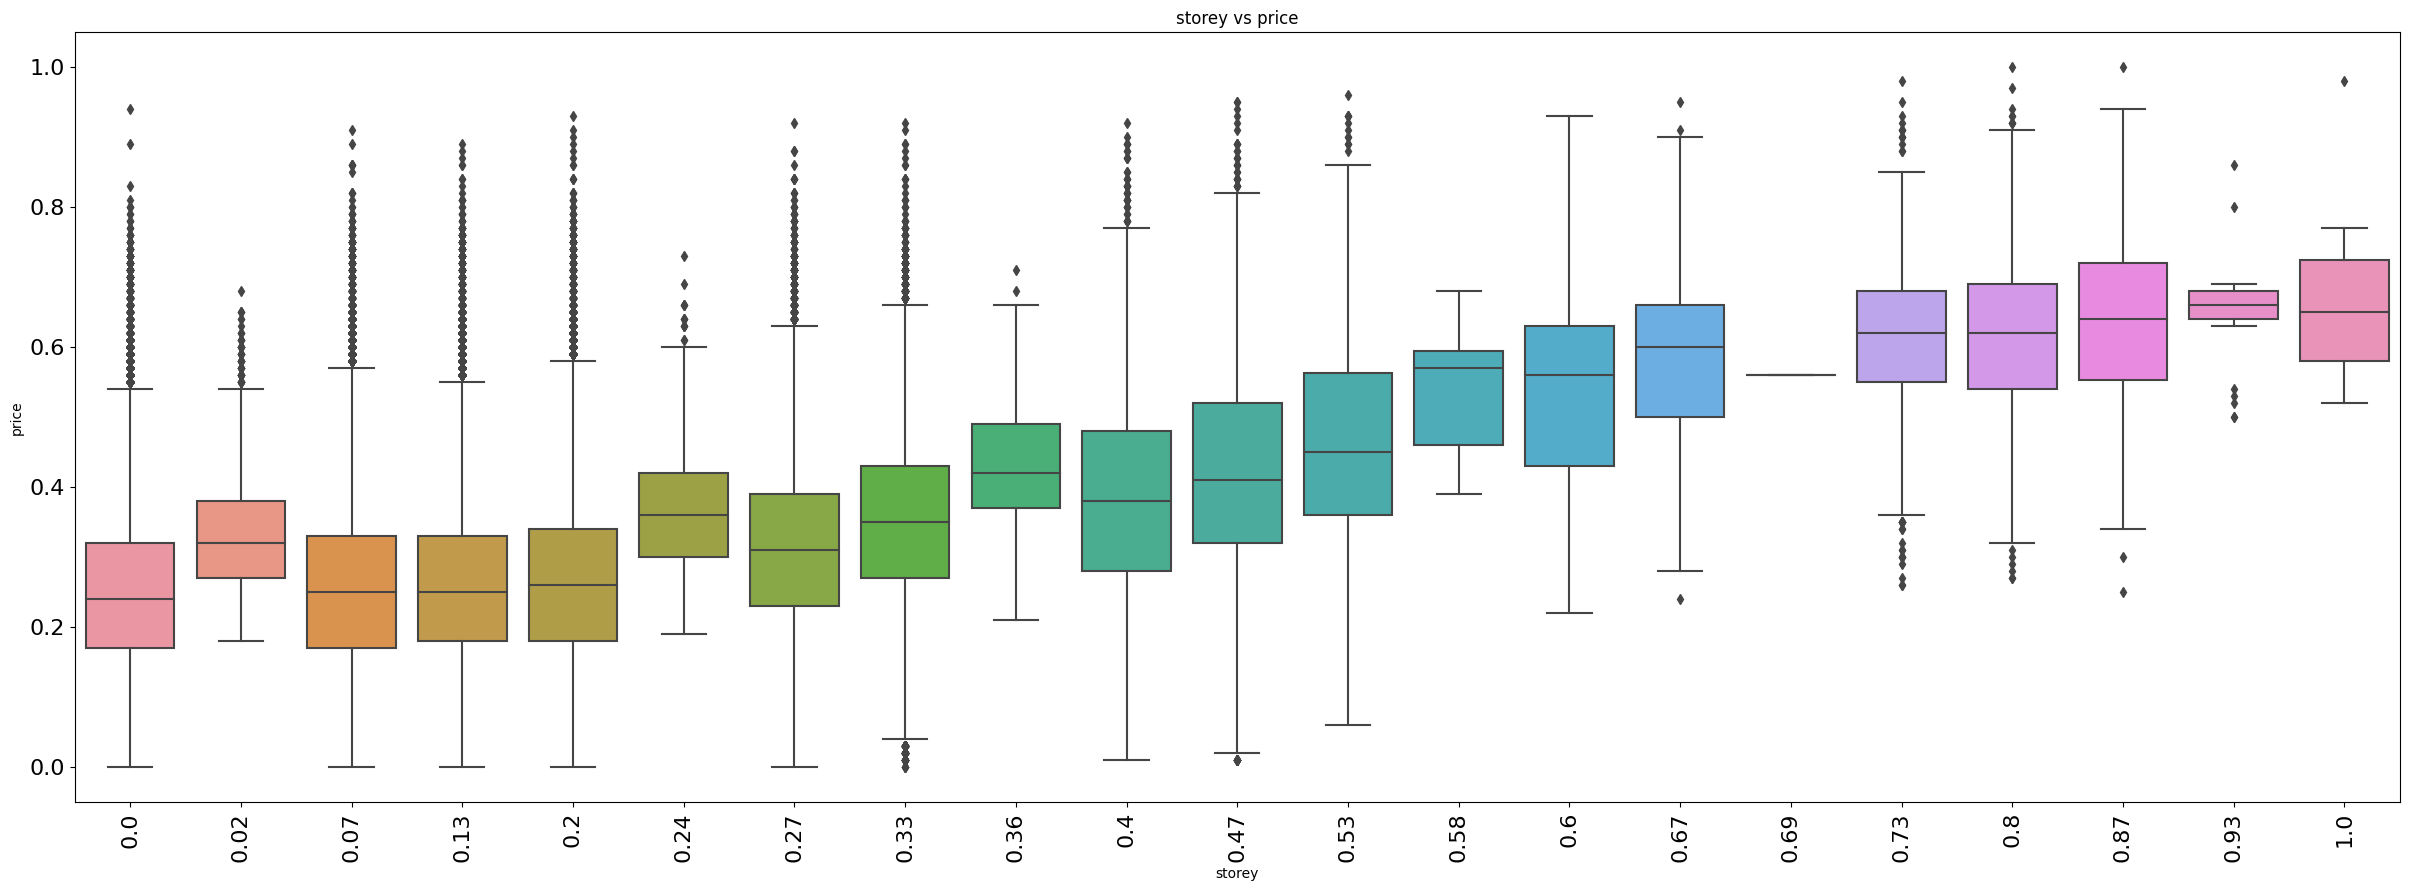

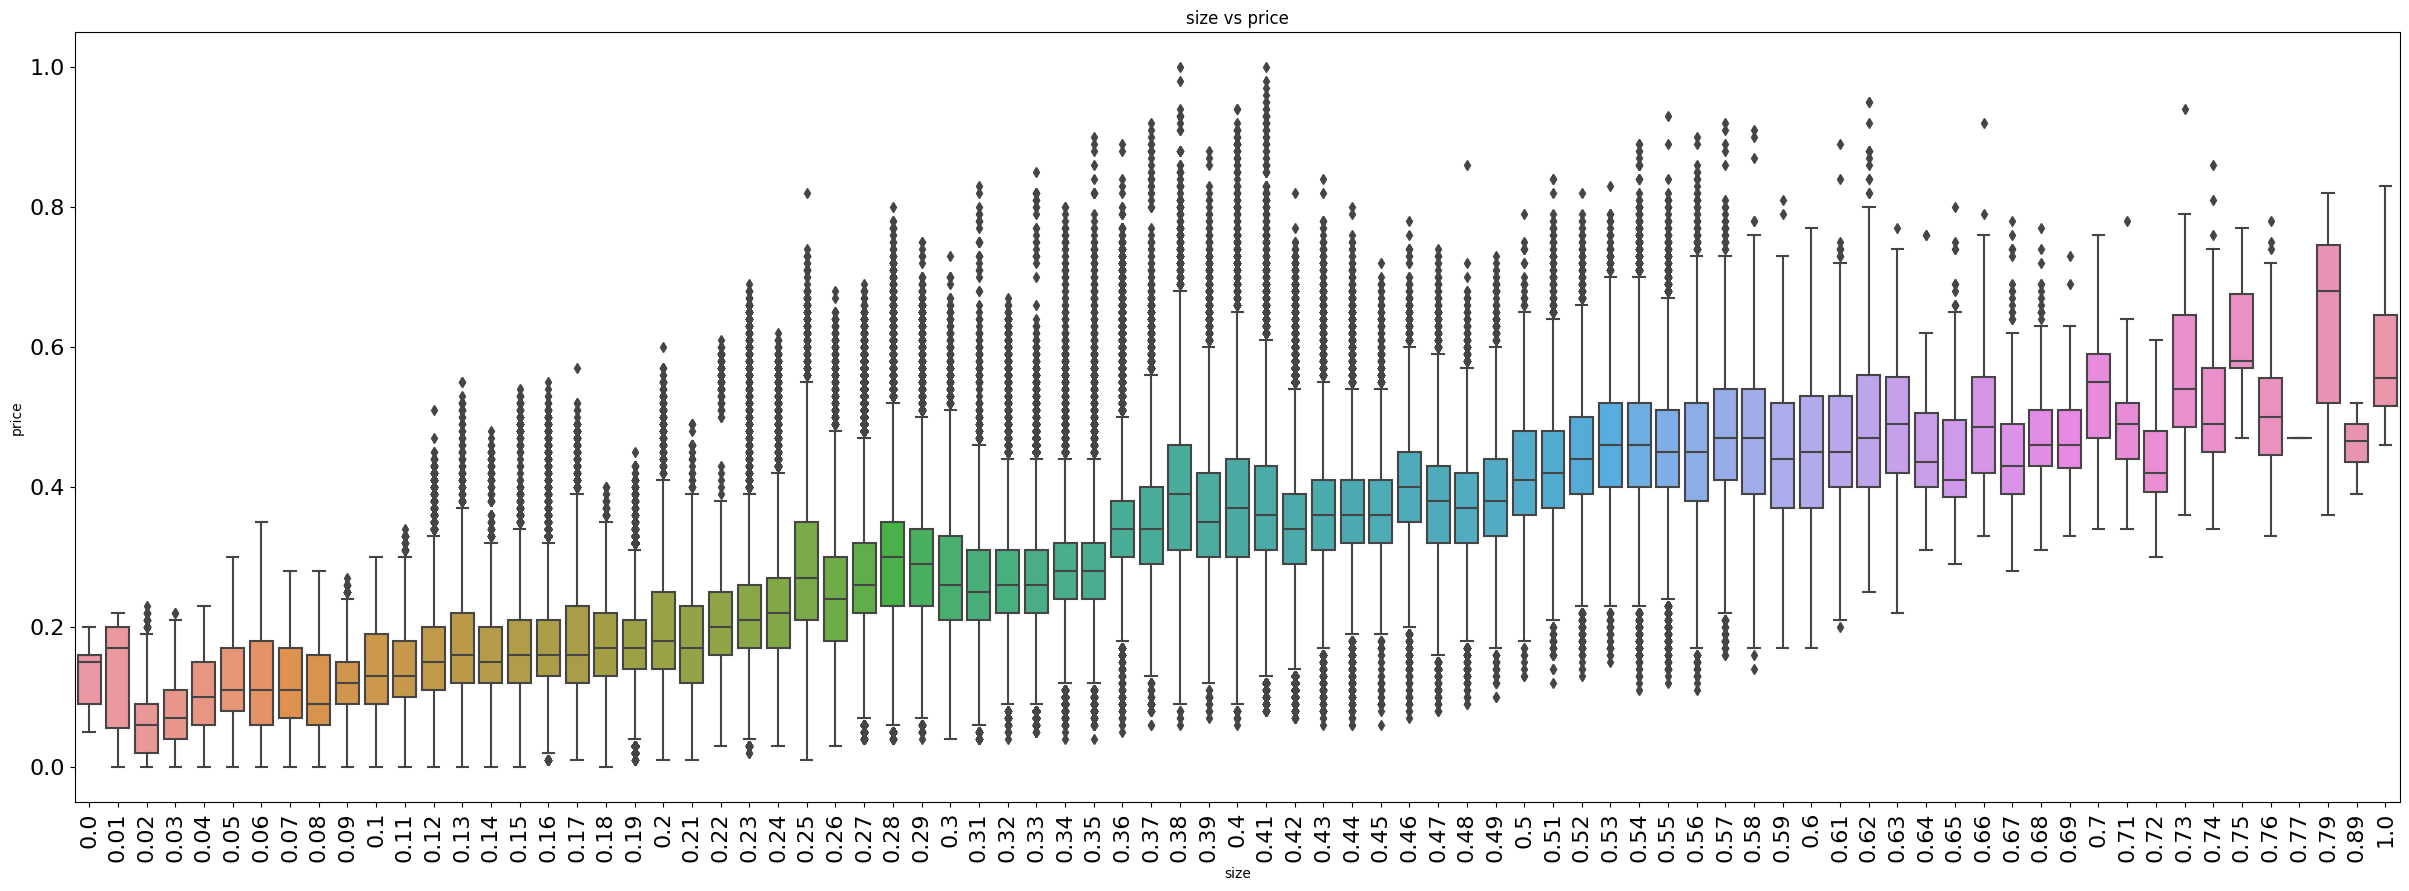

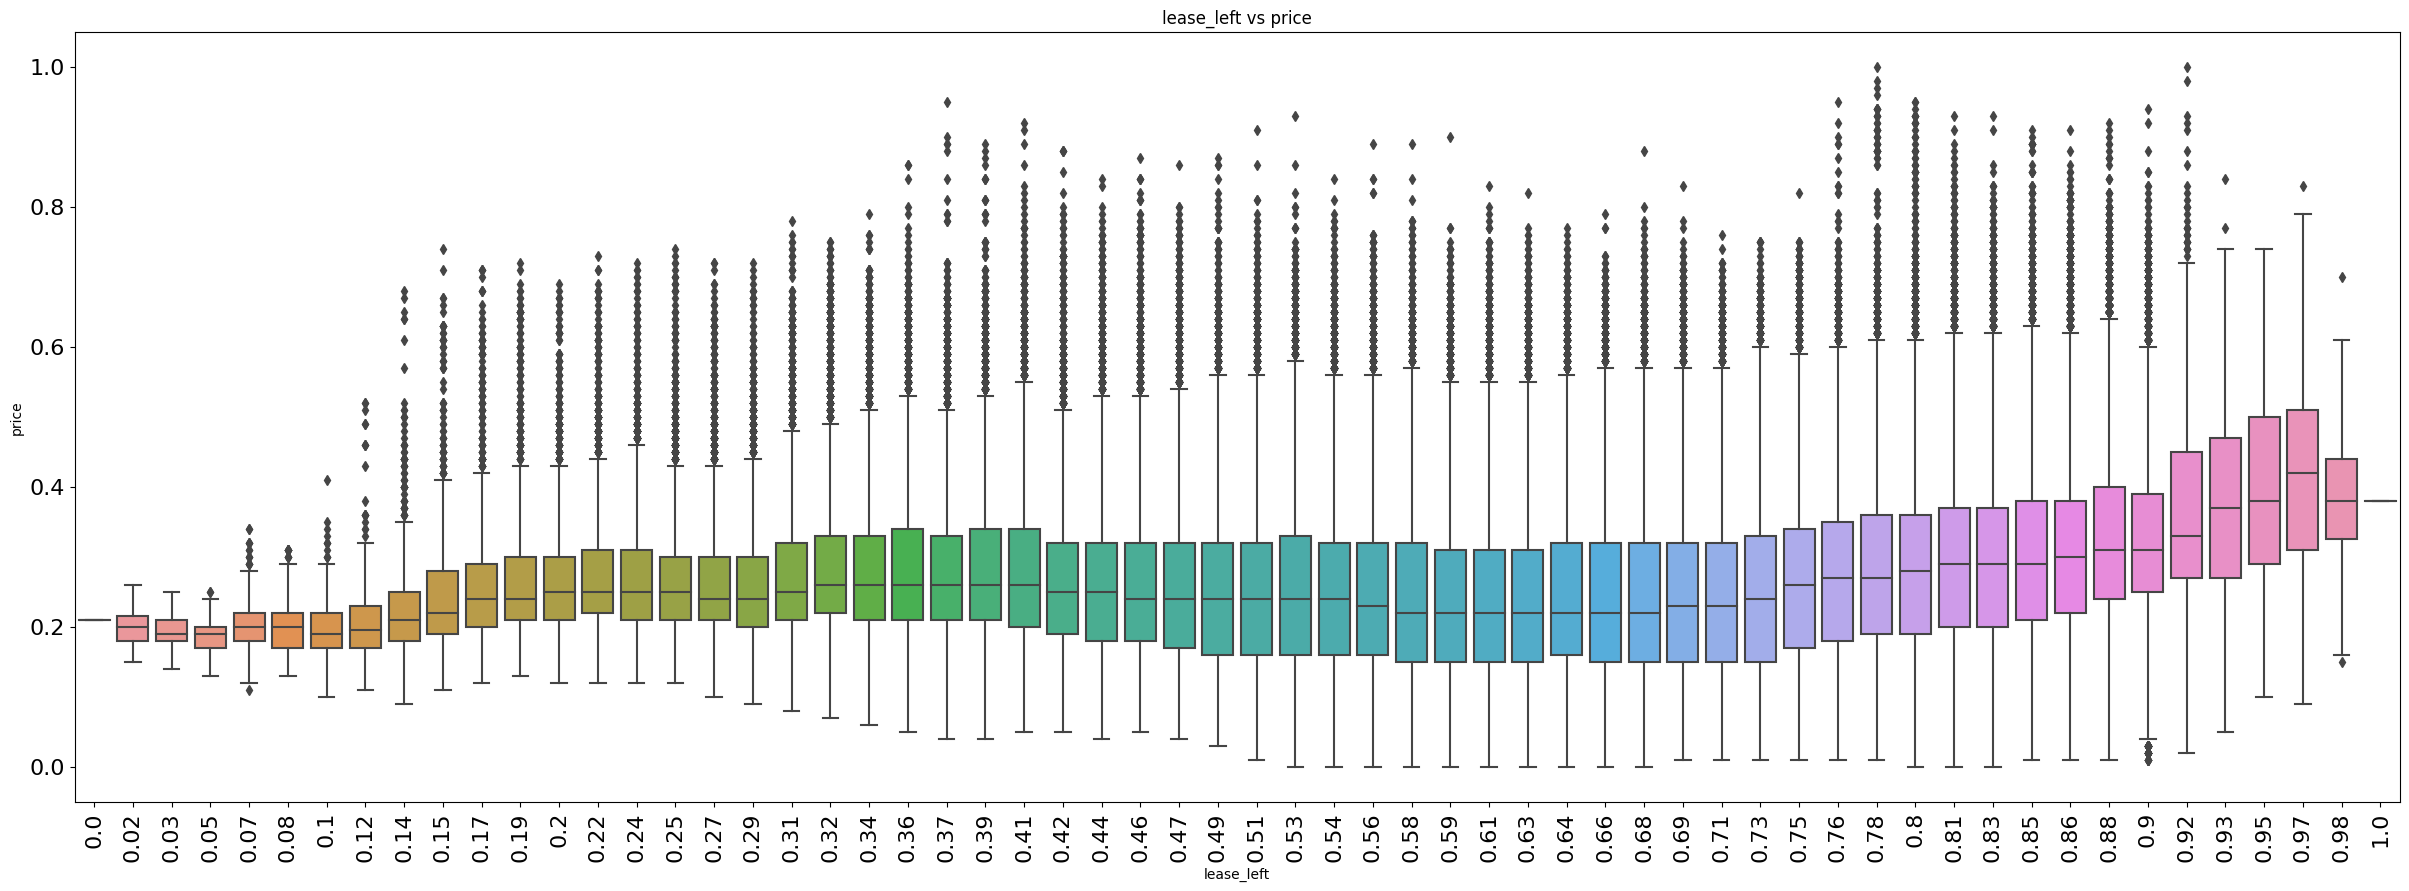

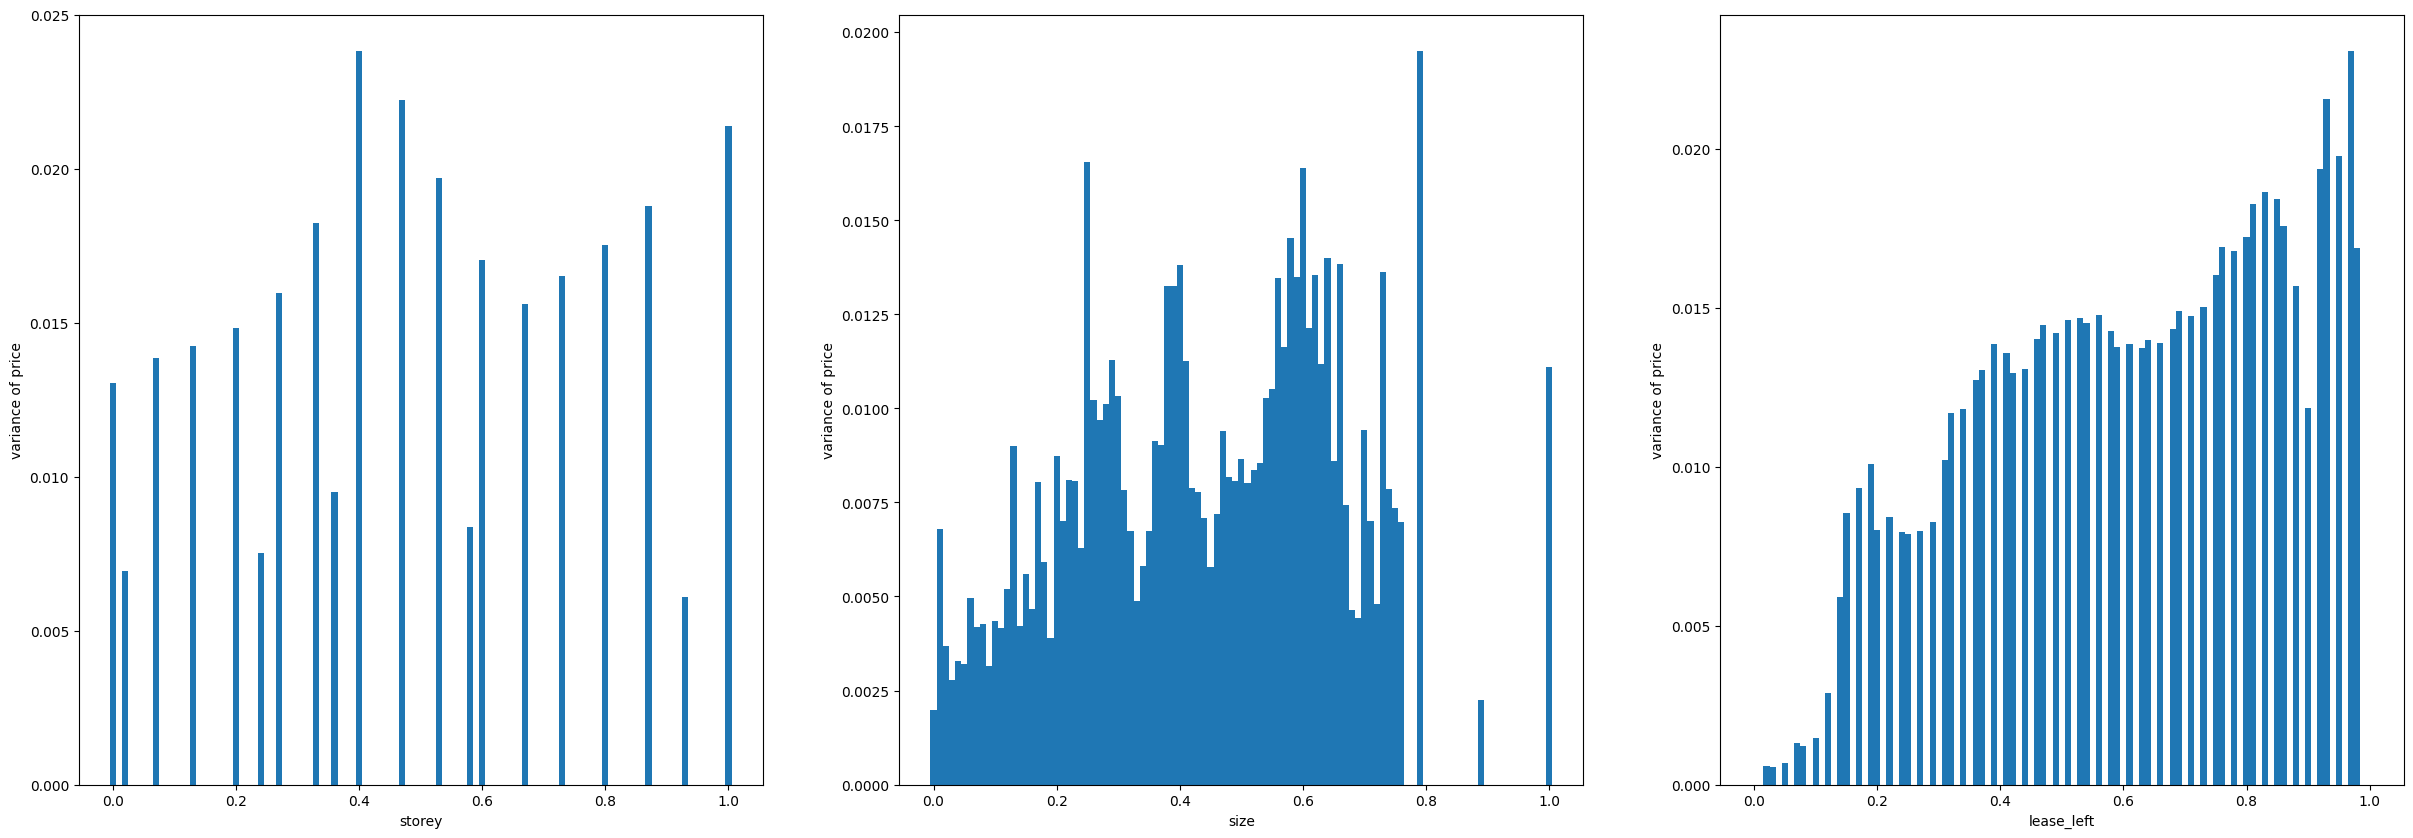

In [ ]:
# Extracting data and EDA

# Extracting data as needed
df_num=df_raw[["price", "storey", "size", "lease_left"]].copy()
num_features=["storey", "size", "lease_left"]
print("Overall numerical dataframe information\n")
print(df_num.info())

# EDA for numerical features
# Generating box and whisker plots
for feature in num_features:
    fig=plt.figure(figsize=(30, 10))
    boxplot = sns.boxplot(x=feature, y='price', data=df_num.round(decimals=2))
    boxplot.set(title=f'{feature} vs price')
    boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

# Generating variance data
fig=plt.figure(figsize=(30, 10))
for i, feature in enumerate(num_features):
    feature_df=df_num[["price", feature]].round(decimals=2)
    feature_groupby=feature_df.groupby([feature])
    feature_var=feature_groupby.var(ddof=0)

    fig.add_subplot(1, len(num_features), i+1)
    plt.bar(feature_var.index, feature_var["price"], width=0.01)
    plt.xlabel(f"{feature}")
    plt.ylabel("variance of price")

plt.show()

In [ ]:
# Preprocessing, and splitting

df_num=df_raw[["price", "storey", "size", "lease_left"]].copy() # to prevent recursive polynomialfeaturization on rerun of cell

poly_transformer_num=PolynomialFeatures(len(df_num.columns)-1)
transformed_data=poly_transformer_num.fit_transform(df_num[["storey", "size", "lease_left"]])
df_num=df_num.drop(columns=["storey", "size", "lease_left"])
df_num=df_num.reset_index(drop=True)
transformed_data=pd.DataFrame(data=transformed_data, columns=poly_transformer_num.get_feature_names_out())
df_num=pd.concat([transformed_data, df_num], axis=1)
print(df_num.info())

# Splitting of data
x_train_num, x_test_num, y_train_num, y_test_num = train_test_split(df_num.drop(columns=["price"]), df_num["price"], train_size=0.8, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891634 entries, 0 to 891633
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   1                       891634 non-null  float64
 1   storey                  891634 non-null  float64
 2   size                    891634 non-null  float64
 3   lease_left              891634 non-null  float64
 4   storey^2                891634 non-null  float64
 5   storey size             891634 non-null  float64
 6   storey lease_left       891634 non-null  float64
 7   size^2                  891634 non-null  float64
 8   size lease_left         891634 non-null  float64
 9   lease_left^2            891634 non-null  float64
 10  storey^3                891634 non-null  float64
 11  storey^2 size           891634 non-null  float64
 12  storey^2 lease_left     891634 non-null  float64
 13  storey size^2           891634 non-null  float64
 14  storey size lease_le

In [ ]:
# Fitting multilinear Lasso regression model to check for feature redundancies 
weights=pd.DataFrame()
alphas=np.arange(0.1, 5, 0.5)
random_states=np.arange(0, 10, 2)

for random_state in random_states:
    x_train, x_test, y_train, y_test = train_test_split(df_num.drop(columns=["price"]), df_num["price"], train_size=0.4, random_state=random_state)
    for alpha in alphas:
        data={"alpha": [alpha],
              "random_state": [random_state]}
        lasso=Lasso(alpha=alpha).fit(x_train, y_train)
        # Construct dictionary to concat into weights df as needed
        features=lasso.feature_names_in_
        coefficients=lasso.coef_
        for i in range(len(features)):
            data[features[i]]=[coefficients[i]]
        data=pd.DataFrame.from_dict(data)
        weights=pd.concat([weights,data])


fig=plt.figure(figsize=(30, 30))
for i, feature in enumerate(weights.drop(columns=["alpha", "random_state"]).columns):
    fig.add_subplot(5, 4, i+1)
    boxplot = sns.boxplot(x="alpha", y=feature, data=weights)
    boxplot.set(title=f'{feature} vs weights across alphas')
    boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=4)
plt.tight_layout()
plt.show()

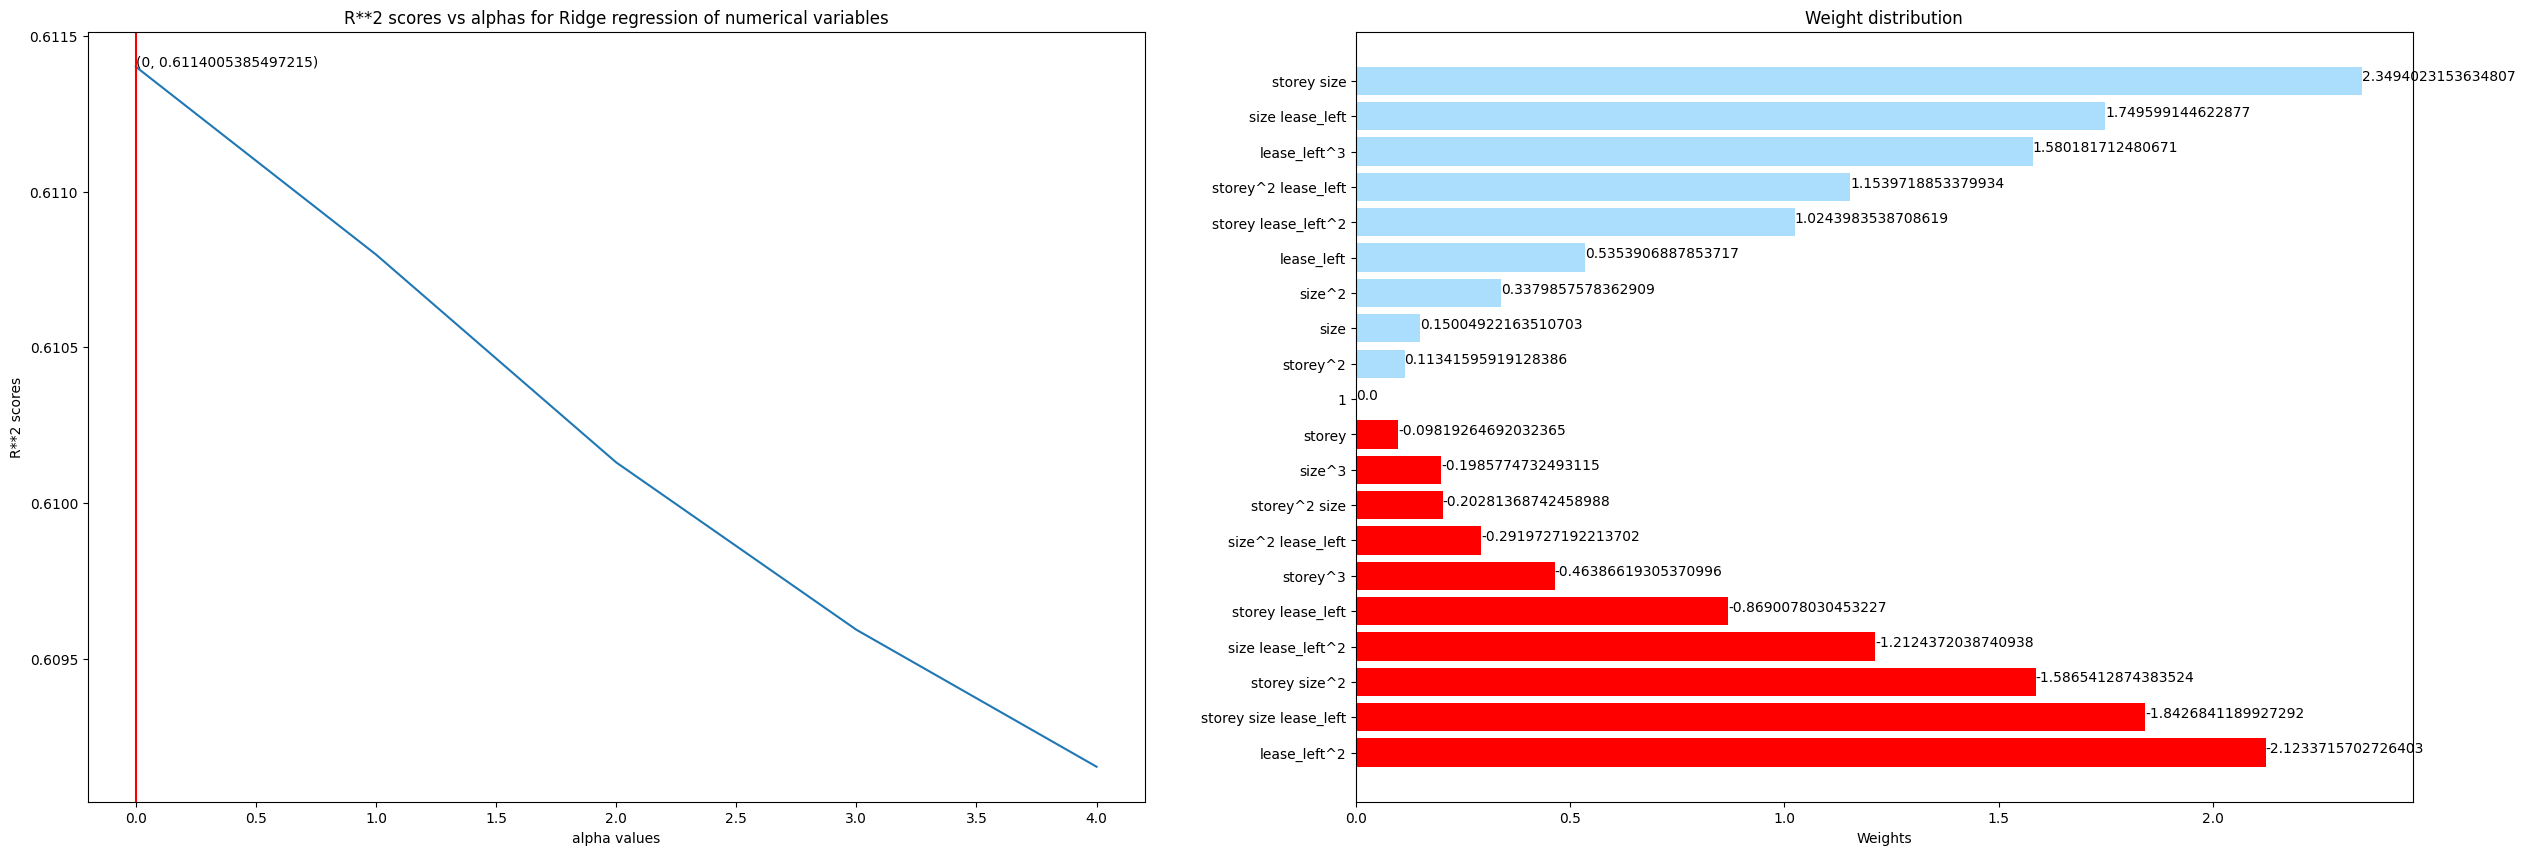

Best alpha: 0
R2 score: 0.6129635646878784
MSE: 0.006034486941359169
Effective inaccuracy: 119018.21381888716
Mean of weights: 0.005246516781574684
Variance of weights: 1.3465811118250346


<ipython-input-11-209acfdbb259>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_report_df=base_model_report_df.append({"model": "num",


'\nFeature wise truncation at 1%:\nBest alpha: 0\nR2 score: 0.590852139169179\nMSE: 0.01464526580982797\nEffective inaccuracy: 148837.8785634239\nMean of weights: 0.017485421186333516\nVariance of weights: 0.523775758470632\n\n'

In [ ]:
# Fitting multilinear ridge regression model

# Multi poly reg model (raw)
scores={}
alphas=np.arange(1, 5, 1)

linreg_score = cross_validate(LinearRegression(), x_train_num, y_train_num, cv=5, scoring=('r2'))
scores[0]=linreg_score["test_score"].mean()

for alpha in alphas:
    # Selecting best alpha using k fold cross validation and R2 metric
    linreg_score=cross_validate(Ridge(alpha=alpha), x_train_num, y_train_num, cv=5, scoring=('r2'))
    scores[alpha]=linreg_score["test_score"].mean()

# Plotting model performance for different alphas
alphas=list(scores.keys())
score_vals=list(scores.values())
best_a=alphas[score_vals.index(max(score_vals))]

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.plot(scores.keys(), scores.values())
plt.title("R**2 scores vs alphas for Ridge regression of numerical variables")
plt.xlabel("alpha values")
plt.ylabel("R**2 scores")
plt.axvline(x = best_a, color ='red')
plt.text(best_a, max(score_vals), f"({best_a}, {max(score_vals)})")

# Plotting weights
# Regenerating best model
num_model=Ridge(alpha=best_a).fit(x_train_num, y_train_num)

weights=num_model.coef_
features=num_model.feature_names_in_
weight_data=pd.Series(data=weights, index=features).sort_values()
weights=weight_data.values
features=weight_data.index
colors = ["#abddfc" if weight >= 0 else "red" for weight in weights]

ax=fig.add_subplot(1, 2, 2)
ax.barh(features, np.abs(weights), color=colors)
ax.set_xlabel('Weights')
ax.set_title('Weight distribution')
for index, weight in enumerate(weights):
    plt.text(np.abs(weight), index, weight)
plt.show()


y_num_preds=num_model.predict(x_test_num)

mae_num=mean_absolute_error(y_test_num, y_num_preds)
mse_num=mean_squared_error(y_test_num, y_num_preds)
num_errors=abs(y_test_num-y_num_preds)
num_err_05=(sum(num_errors<0.05))/(len(num_errors))
num_err_10=(sum(num_errors<0.10))/(len(num_errors))
num_err_15=(sum(num_errors<0.15))/(len(num_errors))
num_err_20=(sum(num_errors<0.20))/(len(num_errors))
num_err_25=(sum(num_errors<0.25))/(len(num_errors))
num_err_30=(sum(num_errors<0.30))/(len(num_errors))
base_model_report_df=base_model_report_df.append({"model": "num",
                                                  "best h-param": f"a={best_a}",
                                                  "mae": mae_num,
                                                  "mse": mse_num,
                                                  "err <05%": num_err_05,
                                                  "err <10%": num_err_10,
                                                  "err <15%": num_err_15,
                                                  "err <20%": num_err_20,
                                                  "err <25%": num_err_25,
                                                  "err <30%": num_err_30}, ignore_index=True)

mse_num=mean_squared_error(y_test_num, num_model.predict(x_test_num))
print(f"Best alpha: {best_a}")
print(f"R2 score: {num_model.score(x_test_num, y_test_num)}")
print(f"MSE: {mse_num}")
print(f"Effective inaccuracy: {normaliser_raw.inverse_transform([[np.sqrt(mse_num),0,0,0]])[0][0]}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")

In [ ]:
# Generating 3d plots for analysis of data

# Creating dataset
z = np.linspace(0,1,50)
x = np.linspace(0,1,50)
y = np.linspace(0,1,50)
xv, yv, zv = np.meshgrid(x, y, z)
xv_flattened=xv.flatten()
yv_flattened=yv.flatten()
zv_flattened=zv.flatten()
df_num_report=pd.DataFrame(data={
    "storey": xv_flattened,
    "size": yv_flattened,
    "lease_left": zv_flattened
})
num_report_poly_transformer=PolynomialFeatures(len(df_num_report.columns))
transformed_data=num_report_poly_transformer.fit_transform(df_num_report)
df_num_report=df_num_report.drop(columns=["storey", "size", "lease_left"])
df_num_report=df_num_report.reset_index(drop=True)
num_report_transformed_data=pd.DataFrame(data=transformed_data, columns=num_report_poly_transformer.get_feature_names_out())
df_num_report=pd.concat([num_report_transformed_data, df_num_report], axis=1)
price_predictions=num_model.predict(df_num_report)

# Plotting data based on price_predictions
num_price_predict_df=pd.DataFrame.from_dict({"xv":xv_flattened,
                                             "yv":yv_flattened,
                                             "zv":zv_flattened,
                                             "predictions":price_predictions})
num_price_predict_df=num_price_predict_df[num_price_predict_df["predictions"]>=0] #truncating out of range predictions

for bin in range(10):
    bin_num_predictions=num_price_predict_df[num_price_predict_df["predictions"].between((bin/10), (bin+1)/10)]
    bin_xv=bin_num_predictions["xv"]
    bin_yv=bin_num_predictions["yv"]
    bin_zv=bin_num_predictions["zv"]
    bin_price_predictions=bin_num_predictions["predictions"]

    fig = plt.figure(figsize=(60, 20))
    for i, azim in enumerate([-60, 30, 120]):#[-60, 30, 60]
        ax = fig.add_subplot(1, 3, i+1, projection='3d')#1, 3, i+1,
        # plotting actual data
        sctt=ax.scatter3D(bin_xv, bin_yv, bin_zv, c=bin_price_predictions, cmap="coolwarm")

        # Plotting reference points
        ax.scatter3D(0, 0, 0, c="#DDFFDD", marker="v", s=200)
        ax.scatter3D(1, 1, 1, c="#DDFFDD", marker="^", s=200)

        ax.set_xlabel('\nstorey', fontsize=26)
        ax.set_ylabel('\nsize', fontsize=26)
        ax.set_zlabel('\nlease_left', fontsize=26)
        ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1))
        ax.tick_params(axis='x', labelsize=26)
        ax.tick_params(axis='y', labelsize=26)
        ax.tick_params(axis='z', labelsize=26)
        ax.view_init(elev=30, azim=azim, roll=0) # azims are -60, 30, 120
    plt.suptitle(f"Storey/Size/Lease left vs price (({(bin*10)}-{(10+bin*10)})th percentile)", fontsize=48)
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

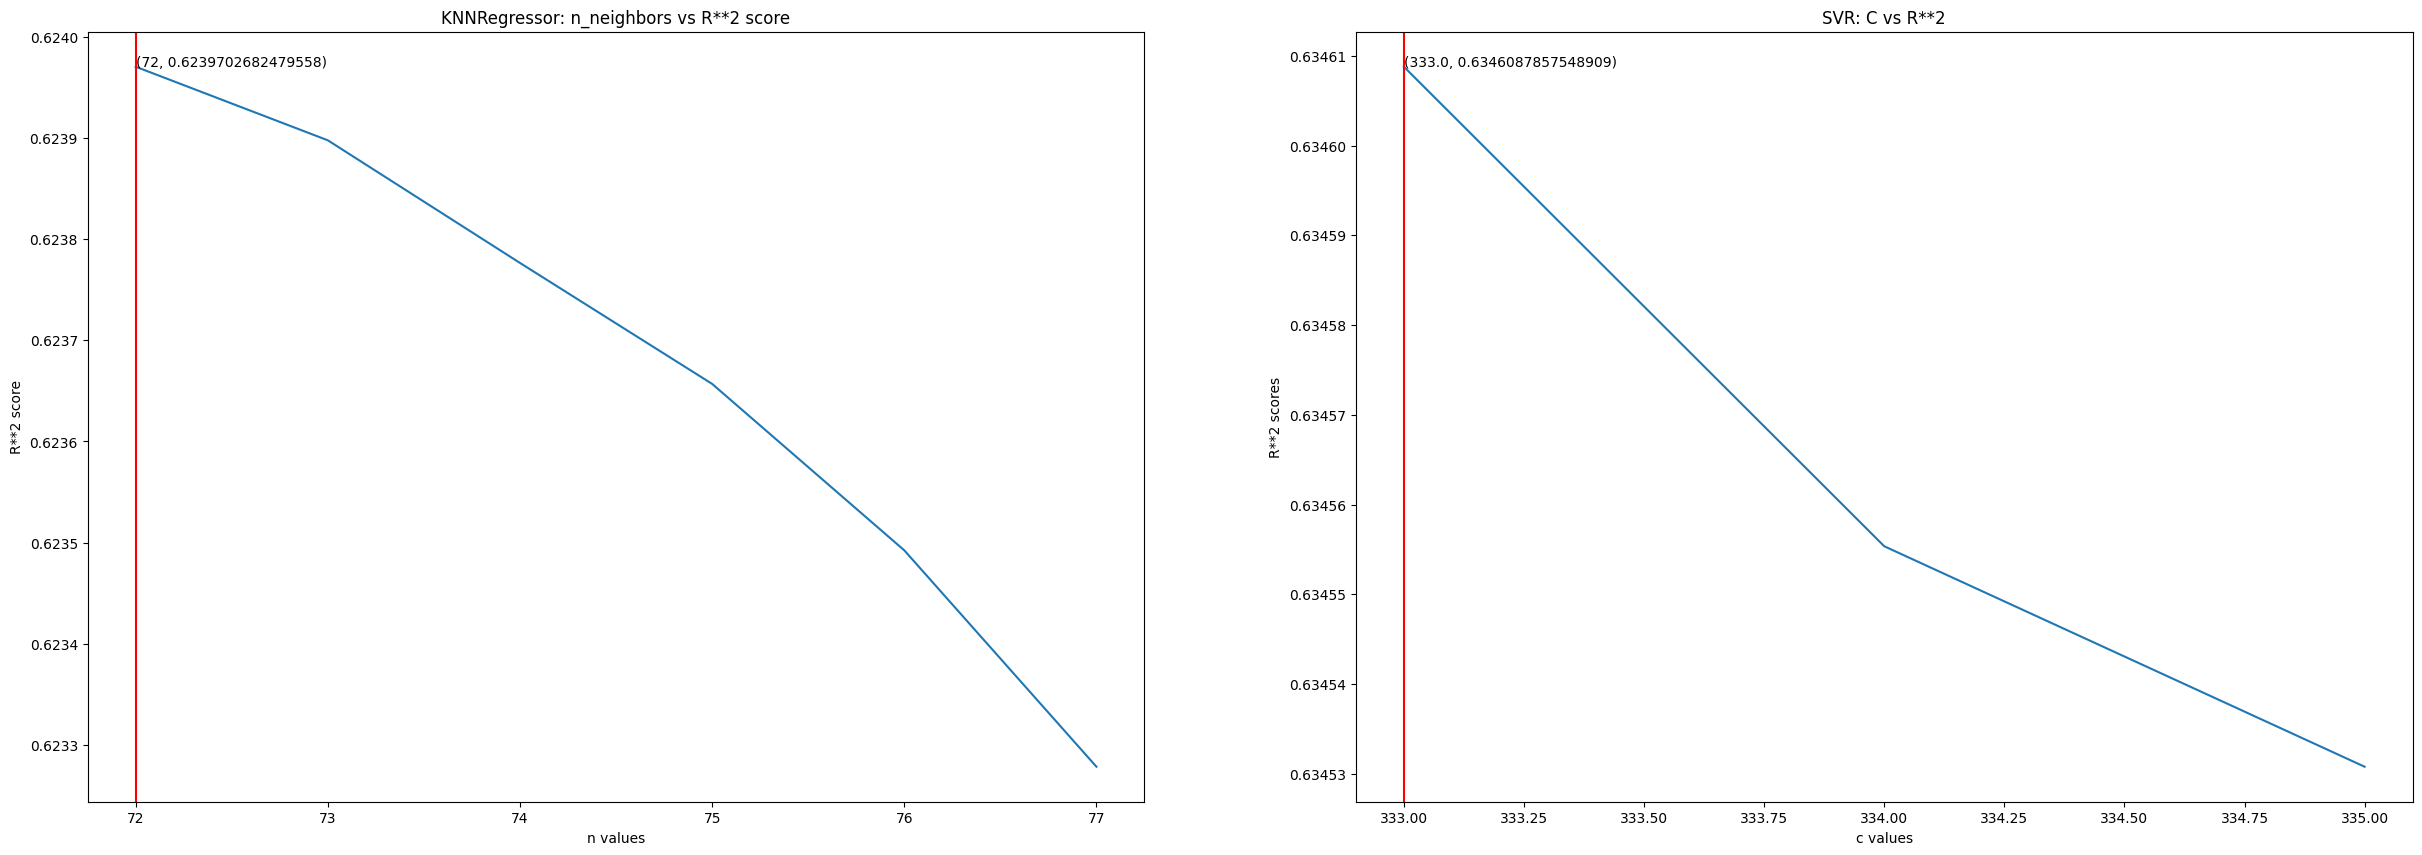

For KNN:
Best n: 72
R2 score: 0.6274379143326969
MSE: 0.006152700740814066
Effective inaccuracy: 119989.56365599646
Mean of weights: 0.005246516781574684
Variance of weights: 1.3465811118250346

For SVR:
Best c: 333.0
R2 score: 0.6287662361228052
MSE: 0.006130764084411146
Effective inaccuracy: 119810.02238296342
Mean of weights: 0.005246516781574684
Variance of weights: 1.3465811118250346



In [ ]:
# Comparing blacker box models (KNNReg, SVM)

# custom splitting of train and test, after sampling, for speed
df_num_sampled=df_num.sample(frac=0.01, random_state=0)
x_train_num, x_test_num, y_train_num, y_test_num = train_test_split(df_num_sampled.drop(columns=["price"]), df_num_sampled["price"], train_size=0.8, random_state=1)

fig=plt.figure(figsize=(30, 10))

# KNN model
knn_neighbor_range=np.arange(72, 78, 1) # note: ties are handled based on data ordering (aka randomly) ._.
knn_scores={}
for n in knn_neighbor_range:
    knn_score=cross_validate(KNeighborsRegressor(n_neighbors=n), x_train_num, y_train_num, cv=5, scoring=('r2'))
    knn_scores[n]=knn_score["test_score"].mean()

ns=list(knn_scores.keys())
knn_score_vals=list(knn_scores.values())
best_n=ns[knn_score_vals.index(max(knn_score_vals))]

fig.add_subplot(1, 2, 1)
plt.plot(knn_scores.keys(), knn_scores.values())
plt.title("KNNRegressor: n_neighbors vs R**2 score")
plt.xlabel("n values")
plt.ylabel("R**2 score")
plt.axvline(x = best_n, color ='red')
plt.text(best_n, max(knn_score_vals), f"({best_n}, {max(knn_score_vals)})")

# SVM model
svr_scores={}
cs=np.arange(333, 335.1, 1)
for c in cs:
    svr_score=cross_validate(SVR(C=c), x_train_num, y_train_num, cv=5, scoring=('r2'))
    svr_scores[c]=svr_score["test_score"].mean()

cs=list(svr_scores.keys())
svr_score_vals=list(svr_scores.values())
best_c=cs[svr_score_vals.index(max(svr_score_vals))]

fig.add_subplot(1, 2, 2)
plt.plot(svr_scores.keys(), svr_scores.values())
plt.title("SVR: C vs R**2")
plt.xlabel("c values")
plt.ylabel("R**2 scores")
plt.axvline(x = best_c, color ='red')
plt.text(best_c, max(svr_score_vals), f"({best_c}, {max(svr_score_vals)})")
plt.show()

# Regenerating best models and reporting performance
# KNN
num_knnreg=KNeighborsRegressor(n_neighbors=best_n).fit(x_train_num, y_train_num)
mse_num=mean_squared_error(y_test_num, num_knnreg.predict(x_test_num))
print("For KNN:")
print(f"Best n: {best_n}")
print(f"R2 score: {num_knnreg.score(x_test_num, y_test_num)}")
print(f"MSE: {mse_num}")
print(f"Effective inaccuracy: {normaliser_raw.inverse_transform([[np.sqrt(mse_num),0,0,0]])[0][0]}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")
print()

# SVR
num_svreg=SVR(C=best_c).fit(x_train_num, y_train_num)
mse_num=mean_squared_error(y_test_num, num_svreg.predict(x_test_num))
print("For SVR:")
print(f"Best c: {best_c}")
print(f"R2 score: {num_svreg.score(x_test_num, y_test_num)}")
print(f"MSE: {mse_num}")
print(f"Effective inaccuracy: {normaliser_raw.inverse_transform([[np.sqrt(mse_num),0,0,0]])[0][0]}")
print(f"Mean of weights: {np.mean(weights)}")
print(f"Variance of weights: {np.var(weights)}")
print()

## Time series data pipeline


### Extracting data, preprocessing, splitting

In [ ]:
# Extracting data and conducting sampling
time_features=["lease_start", "sale_date"]

# Extracting data as needed
df_time=df_raw[["price", "lease_start", "sale_date"]].copy()

# Initial Preprocessing

# Selectors
slices=12 # Number of slices of a year to split dates into (must be factor of 12)

# Rounding datetimes by n cuts
for feature in df_time[time_features].columns:
    df_tmp=pd.DataFrame()
    df_tmp["day"]=df_time[feature].dt.day.astype(str)
    df_tmp["year"]=df_time[feature].dt.year.astype(str)

    df_tmp["month"]=df_time[feature].dt.month
    df_tmp["month"]=pd.cut(df_tmp["month"], slices, labels=False).astype(int)
    df_tmp["month"]=(int(12/slices)*(df_tmp["month"]+1)).astype(str)

    df_time[feature] = pd.to_datetime(df_tmp["year"] + "/" + df_tmp["month"] + "/" + df_tmp["day"])

# Adding timestamps and defining columns
time_columns_timestamped=[f"{column}_timestamped" for column in time_columns]
for column in time_features:
    df_time[f"{column}_timestamped"]=df_time[column].astype("int")

# splitting as needed
df_time_train, df_time_test=train_test_split(df_time, train_size=0.8, random_state=1)

### EDA for segment analysis

In [ ]:
# Segment analysis over time

# Generate feature keys
# Extract features and split numerical features by percentiles
df_raw_features=df_raw.drop(columns=["price", "st_name"]).copy()
df_raw_features=df_raw_features.drop(columns=time_features)
numerical_features=["storey", "size", "lease_left"]
for feature in numerical_features:
    df_raw_features[feature]=pd.qcut(df_raw_features[feature], 5, duplicates="drop")

feature_enc_time=OrdinalEncoder()
encoded_data=feature_enc_time.fit_transform(df_raw_features)
raw_features=feature_enc_time.get_feature_names_out()
df_raw_features=pd.DataFrame(data=encoded_data, columns=raw_features)

for column in df_raw_features.columns:
    df_raw_features[column]=df_raw_features[column].values.astype(str)
df_time["feature_key"]=df_raw_features[df_raw_features.columns].apply("-".join, axis=1)

# extract all legal features
    # legal features will satisfy 2 conditions:
        # 1) they appear in all timestamps
        # 2) they appear enough in each timestamp
        # 1+2 implies legal features apppear enough, in all timestamps

TOLERANCE=5 # getting tolerance for condition 2
TOP_N_SEGMENTS=10 # to select best n segments
time_legal_feature_keys=pd.DataFrame()

# Generating data and plotting
for feature in time_features:
    # getting critical data
    no_years=df_time[feature].nunique() # total number of years for condition 1

    # Conducting eda for enhanced legal feature analysis
    df_time_groupby_counts=df_time[["feature_key", feature, "price"]].groupby(["feature_key", feature]).count()
    df_time_occurrences=pd.DataFrame.from_dict({"feature_keys": df_time_groupby_counts["price"].index.get_level_values(0),
                                    "timestamps": df_time_groupby_counts["price"].index.get_level_values(1),
                                    "occurrences":df_time_groupby_counts["price"].values})
    df_time_occurrences=df_time_occurrences[df_time_occurrences["occurrences"]>=TOLERANCE] # filtering out counts under TOLERANCE

    # Generating data regarding feature class prevalence to aid in sorting for good graphing
    df_time_occurrence_sorted=df_time_occurrences["feature_keys"].value_counts().to_frame()
    df_time_occurrence_sorted=df_time_occurrence_sorted.reset_index()
    df_time_occurrence_sorted=df_time_occurrence_sorted.rename(columns={"feature_keys":"occurrences_over_range","index":"feature_keys"})

    # Conducting inner join to allow for sorting of df
    df_time_occurrences=df_time_occurrences.merge(df_time_occurrence_sorted, on=["feature_keys"])
    df_time_occurrences=df_time_occurrences.sort_values(["occurrences_over_range"], axis=0, ascending=False)
    df_time_occurrences[["feature_keys_ordinal"]]=OrdinalEncoder().fit_transform(df_time_occurrences[["feature_keys"]])

    plt.figure(figsize=(30, 30))
    for classno, class_value in enumerate(pd.unique(df_time_occurrences["feature_keys_ordinal"])):
        df_tmp=df_time_occurrences[df_time_occurrences["feature_keys_ordinal"]==class_value]
        plt.scatter(df_tmp["timestamps"], np.full((len(df_tmp["feature_keys_ordinal"]),), classno))
        plt.xlabel(f"{feature}", fontsize=48)
        plt.ylabel("occurrence", fontsize=48)
        plt.title(f"{feature} vs occurrence", fontsize=48)
        if classno>=100: # To plot only top few feature_keys
            break

    plt.xticks(rotation=90)
    plt.show()

    selected_keys=df_time_occurrences.head(TOP_N_SEGMENTS).reset_index()
    selected_keys=selected_keys["feature_keys"]
    time_legal_feature_keys[f"{feature}_key"]=selected_keys

print(f"Original features are encoded in order: {feature_enc_time.feature_names_in_}")
display(time_legal_feature_keys)

'# Segment analysis over time\n\n# Generate feature keys\n# Extract features and split numerical features by percentiles\ndf_raw_features=df_raw.drop(columns=["price", "st_name"]).copy()\ndf_raw_features=df_raw_features.drop(columns=time_features)\nnumerical_features=["storey", "size", "lease_left"]\nfor feature in numerical_features:\n    df_raw_features[feature]=pd.qcut(df_raw_features[feature], 5, duplicates="drop")\n\nfeature_enc_time=OrdinalEncoder()\nencoded_data=feature_enc_time.fit_transform(df_raw_features)\nraw_features=feature_enc_time.get_feature_names_out()\ndf_raw_features=pd.DataFrame(data=encoded_data, columns=raw_features)\n\nfor column in df_raw_features.columns:\n    df_raw_features[column]=df_raw_features[column].values.astype(str)\ndf_time["feature_key"]=df_raw_features[df_raw_features.columns].apply("-".join, axis=1)\n\n# extract all legal features\n    # legal features will satisfy 2 conditions:\n        # 1) they appear in all timestamps\n        # 2) they appea

### Fitting ARIMAs and hyperparameter tuning

#### Data analysis to aid in model fitting

In [ ]:
# EDA of ACFs and PACFs to aid in fitting ARIMA models
MAX_SHIFT=3
ROLLING_WINDOW=3

# Generating data as needed
df_time_means={}
for feature in time_features:
    df_groupby_means=df_time[[feature, "price"]].copy().groupby(feature).mean(numeric_only=True)
    prices=df_groupby_means.values.flatten()
    feature_values=df_groupby_means.index

    df_tmp=pd.DataFrame()
    df_tmp[feature]=feature_values
    df_tmp["d0(price)"]=prices

    # getting differentials
    for shift in range(MAX_SHIFT):
        one_shifted_values=df_tmp[f"d{shift}(price)"].shift()
        df_tmp[f"d{shift+1}(price)"]=df_tmp[f"d{shift}(price)"]-one_shifted_values
    df_time_means[feature]=df_tmp

# Plotting autocorrelation and partial autocorrelation data
for shift in range(MAX_SHIFT+1):
    fig=plt.figure(figsize=(80,40))
    for i, feature in enumerate(df_time_means.keys()):
        series_tmp=pd.Series(data=df_time_means[feature][f"d{shift}(price)"].values,
                             index=df_time_means[feature][feature])
        series_tmp=series_tmp.dropna()

        # generate acf, pacf data and plot
        acf_data=acf(series_tmp, alpha=0.05)
        pacf_data=pacf(series_tmp, alpha=0.05)
        indices=np.arange(0, len(acf_data[0]), 1)
        adf_pval=adfuller(series_tmp.values)[1]

        # plot data as needed
        fig.add_subplot(2, len(df_time_means.keys()), i+1)
        plt.ylim(-1.2, 1.2)
        # plot acf
        plt.fill_between(indices, [value[0] for value in acf_data[1]], [value[1] for value in acf_data[1]], label="ACF 95% CI", color="#dbf3fa")
        plt.bar(indices, acf_data[0], label="ACF", color="#1f77b4", width=0.1)
        plt.legend()
        plt.title(f"d{shift}(price) v {feature} ACF", fontsize=36)
        plt.text(0, -1.1, f"adf p-val: {adf_pval}", fontsize=36)
        plt.yticks(fontsize=36)
        plt.yticks(fontsize=36)

        # plot pacf
        fig.add_subplot(2, len(df_time_means.keys()), i+1+2)
        plt.fill_between(indices, [value[0] for value in pacf_data[1]], [value[1] for value in pacf_data[1]], label="PACF 95% CI", color="#ffcccb")
        plt.bar(indices, pacf_data[0], label="PACF", color="#d62728", width=0.1)
        plt.legend()
        plt.title(f"d{shift}(price) v {feature} PACF", fontsize=36)
        plt.yticks(fontsize=36)
        plt.yticks(fontsize=36)

    plt.suptitle(f"Shift no.: {shift}", fontsize=72)
    plt.show()

# EDA for feature and differencing mean and variance
for shift in range(MAX_SHIFT+1):
    fig=plt.figure(figsize=(40, 20))
    for i, feature in enumerate(df_time_means.keys()):

        fig.add_subplot(1, len(df_time_means.keys()), i+1)
        indices=df_time_means[feature][feature]
        values=df_time_means[feature][f"d{shift}(price)"]
        rolling_values=(df_time_means[feature][[f"d{shift}(price)"]].rolling(ROLLING_WINDOW))
        rolling_means=rolling_values.mean()
        rolling_vars=rolling_values.var(ddof=0)
        adf_score=adfuller(values.dropna())[1]

        plt.scatter(indices, values)
        plt.plot(indices, rolling_means, color="red")
        plt.plot(indices, rolling_vars, color="#6fc96f")

        plt.legend([f"d{shift}(price)", f"rolling mean of d{shift}(price)", f"rolling variance of d{shift}(price)"], loc ="lower right")
        plt.xlabel(f"{feature}", fontsize=24)
        plt.ylabel(f"d{shift}(price)", fontsize=24)
        plt.title(f"d{shift}(price) vs {feature}", fontsize=24)

        plt.text(indices.min(), values.min(), f"adf p-val: {adf_score}")
    plt.show()

# Plotting decomposition data
for i, feature in enumerate(time_features):

    # Getting data
    data_tmp_groupby=df_time[[feature, "price"]].groupby(feature).mean()
    data_series_tmp=pd.Series(data=data_tmp_groupby.values.flatten(),
                              index=pd.DatetimeIndex(data=data_tmp_groupby.index, freq="infer"))
    # Getting decomposition results
    decomposition_results=seasonal_decompose(data_series_tmp)

    # Plotting
    result_plot=decomposition_results.plot()
    result_plot.suptitle(f"{feature} decomposition:")
    plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

#### Model fitting and evaluation

In [ ]:
# Grid searching ARIMA models
arima_models={} # schema: arima_models[feature][order_3_tuple]=Arima(feature_data,order=order_3_tuple)

# Generating data (to streamline when EDA is combined)
time_series_data={"train":{},
                  "test":{}}
for feature in time_features:
    data_tmp=df_time_train[[feature, "price"]]
    data_tmp_groupby=data_tmp.groupby(feature).mean()
    time_series_data["train"][feature]=pd.Series(data=data_tmp_groupby.values.flatten(),
                                                 index=pd.DatetimeIndex(data=data_tmp_groupby.index, freq="infer"))

    data_tmp=df_time_test[[feature, "price"]]
    data_tmp_groupby=data_tmp.groupby(feature).mean()
    time_series_data["test"][feature]=pd.Series(data=data_tmp_groupby.values.flatten(),
                                                index=pd.DatetimeIndex(data=data_tmp_groupby.index, freq="infer"))


# Model generation
summaries={} #summaries[feature][order]=summary(Arima(feature, order))

for feature in time_features:
    arima_models[feature]={}
    summaries[feature]={}

    for p in np.arange(0, 10, 1):
        best_aic=0
        best_arima=0
        best_order=0

        for q in np.arange(0, 10, 1):

            # generating current arima
            current_order=(p, 1, q)
            endog=time_series_data["train"][feature]
            arima_tmp=Arima(endog, order=current_order).fit()

            # generating current scores
            current_aic=arima_tmp.aic

            # saving best arima
            if current_aic<best_aic:
                best_arima=arima_tmp
                best_order=current_order
                best_aic=current_aic
            else:
                break

        # saving best arima and aic of the current p
        arima_models[feature][best_order]=best_arima
        key_tmp=f"{feature} ARIMA{best_order}"
        data_tmp=(best_arima.summary())
        summaries[feature][best_order]=(key_tmp, data_tmp)

# Displaying ARIMA data

for feature in summaries.keys():
    for order in summaries[feature].keys():
        print(f"\n{summaries[feature][order]}\n")
    print("\n"*5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver


('lease_start ARIMA(0, 1, 2)', <class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 101.345
Date:                Wed, 23 Aug 2023   AIC                           -196.689
Time:                        05:58:23   BIC                           -190.778
Sample:                    06-01-1966   HQIC                          -194.416
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5388      0.098     -5.473      0.000      -0.732      -0.346
ma.L2          0.2935      0.128      2.302      0.

In [ ]:
# Experimenting with ARIMA models and parameters
arima_models={} # schema: arima_models[feature][order_3_tuple]=Arima(feature_data,order=order_3_tuple)
experimental_orders={"sale_date":[(4, 1, 0)],
                     "lease_start":[(1, 1, 0)]}

# Generating data (to streamline when EDA is combined)
time_series_data={"train":{},
                  "test":{}}
for feature in time_features:
    data_tmp=df_time_train[[feature, "price"]]
    data_tmp_groupby=data_tmp.groupby(feature).mean()
    time_series_data["train"][feature]=pd.Series(data=data_tmp_groupby.values.flatten(),
                                                 index=pd.DatetimeIndex(data=data_tmp_groupby.index, freq="infer"))

    data_tmp=df_time_test[[feature, "price"]]
    data_tmp_groupby=data_tmp.groupby(feature).mean()
    time_series_data["test"][feature]=pd.Series(data=data_tmp_groupby.values.flatten(),
                                                index=pd.DatetimeIndex(data=data_tmp_groupby.index, freq="infer"))


# Model generation
summaries={} #summaries[feature][order]=summary(Arima(feature, order))
scores={} #scores[feature][order][metric]=metric(y_true, pred(Arima(feature, order)))
for feature in time_features:
    arima_models[feature]={}
    summaries[feature]={}
    scores[feature]={}
    for order in experimental_orders[feature]:
        scores[feature][order]={}

        endog=time_series_data["train"][feature]
        arima_tmp=Arima(endog, order=order).fit()
        arima_models[feature][order]=arima_tmp

        key_tmp=f"{feature} ARIMA{order}"
        data_tmp=(arima_tmp.summary())
        summaries[feature][order]=(key_tmp, data_tmp)

        # generate predictions
        y_preds=arima_tmp.predict().values
        y_trues=endog.values
        scores[feature][order]["aic"]=arima_tmp.aic
        scores[feature][order]["sw-test p-val"]=scipy.stats.shapiro(y_trues-y_preds).pvalue

# Displaying ARIMA data
for feature in summaries.keys():
    for order in summaries[feature].keys():
        print(f"{summaries[feature][order]}\n")
    print("\n"*5)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


('lease_start ARIMA(1, 1, 5)', <class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   54
Model:                 ARIMA(1, 1, 5)   Log Likelihood                 105.745
Date:                Wed, 23 Aug 2023   AIC                           -197.490
Time:                        08:37:35   BIC                           -183.698
Sample:                    06-01-1966   HQIC                          -192.186
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      0.234      0.212      0.832      -0.409       0.509
ma.L1         -0.5155      0.328     -1.572      0.1

In [ ]:
# Model evaluation
TIME_SELECTED_ORDERS={"lease_start": (1, 1, 0),
                      "sale_date": (4, 1, 0)}
time_models={}
time_model_metrics={}
# Conducting CV and reporting on model p
for feature in time_features:
    # Selectors
    K=5
    time_models[feature]=[]
    time_model_metrics[feature]={"mae":[],
                                "mse":[],
                                "err <05%":[],
                                "err <10%":[],
                                "err <15%":[],
                                "err <20%":[],
                                "err <25%":[],
                                "err <30%":[]}

    for random_state in np.arange(0, K, 1):
    # Generating data as needed
        df_tmp_train, df_tmp_test=train_test_split(df_time[[feature, "price"]], train_size=0.8, random_state=random_state)
        df_tmp_train_means=df_tmp_train.groupby(feature).mean()
        df_tmp_test_means=df_tmp_test.groupby(feature).mean()
        s_tmp_train=pd.Series(data=df_tmp_train_means.values.flatten(), index=pd.DatetimeIndex(data=df_tmp_train_means.index, freq="infer"))
        s_tmp_test=pd.Series(data=df_tmp_test_means.values.flatten(), index=pd.DatetimeIndex(data=df_tmp_test_means.index, freq="infer"))

        # Fitting model
        data_tmp_series=time_series_data["train"][feature]
        model=Arima(data_tmp_series, order=TIME_SELECTED_ORDERS[feature]).fit()

        # Generating predictions
        y_true=data_tmp_series.values
        y_pred=[]
        for date in data_tmp_series.index:
            y_pred.append(model.predict(start=date, end=date).values)
        y_pred=np.array([array[0] for array in y_pred])

        # Getting metrics
        time_model_metrics[feature]["mse"].append(mean_squared_error(y_true, y_pred))
        time_model_metrics[feature]["mae"].append(mean_absolute_error(y_true, y_pred))
        pct_errors=(np.abs(y_pred-y_true))/y_true
        time_model_metrics[feature]["err <05%"].append(((pct_errors<0.05).sum())/(len(y_true)))
        time_model_metrics[feature]["err <10%"].append(((pct_errors<0.10).sum())/(len(y_true)))
        time_model_metrics[feature]["err <15%"].append(((pct_errors<0.15).sum())/(len(y_true)))
        time_model_metrics[feature]["err <20%"].append(((pct_errors<0.20).sum())/(len(y_true)))
        time_model_metrics[feature]["err <25%"].append(((pct_errors<0.25).sum())/(len(y_true)))
        time_model_metrics[feature]["err <30%"].append(((pct_errors<0.30).sum())/(len(y_true)))

        time_models[feature].append(model)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

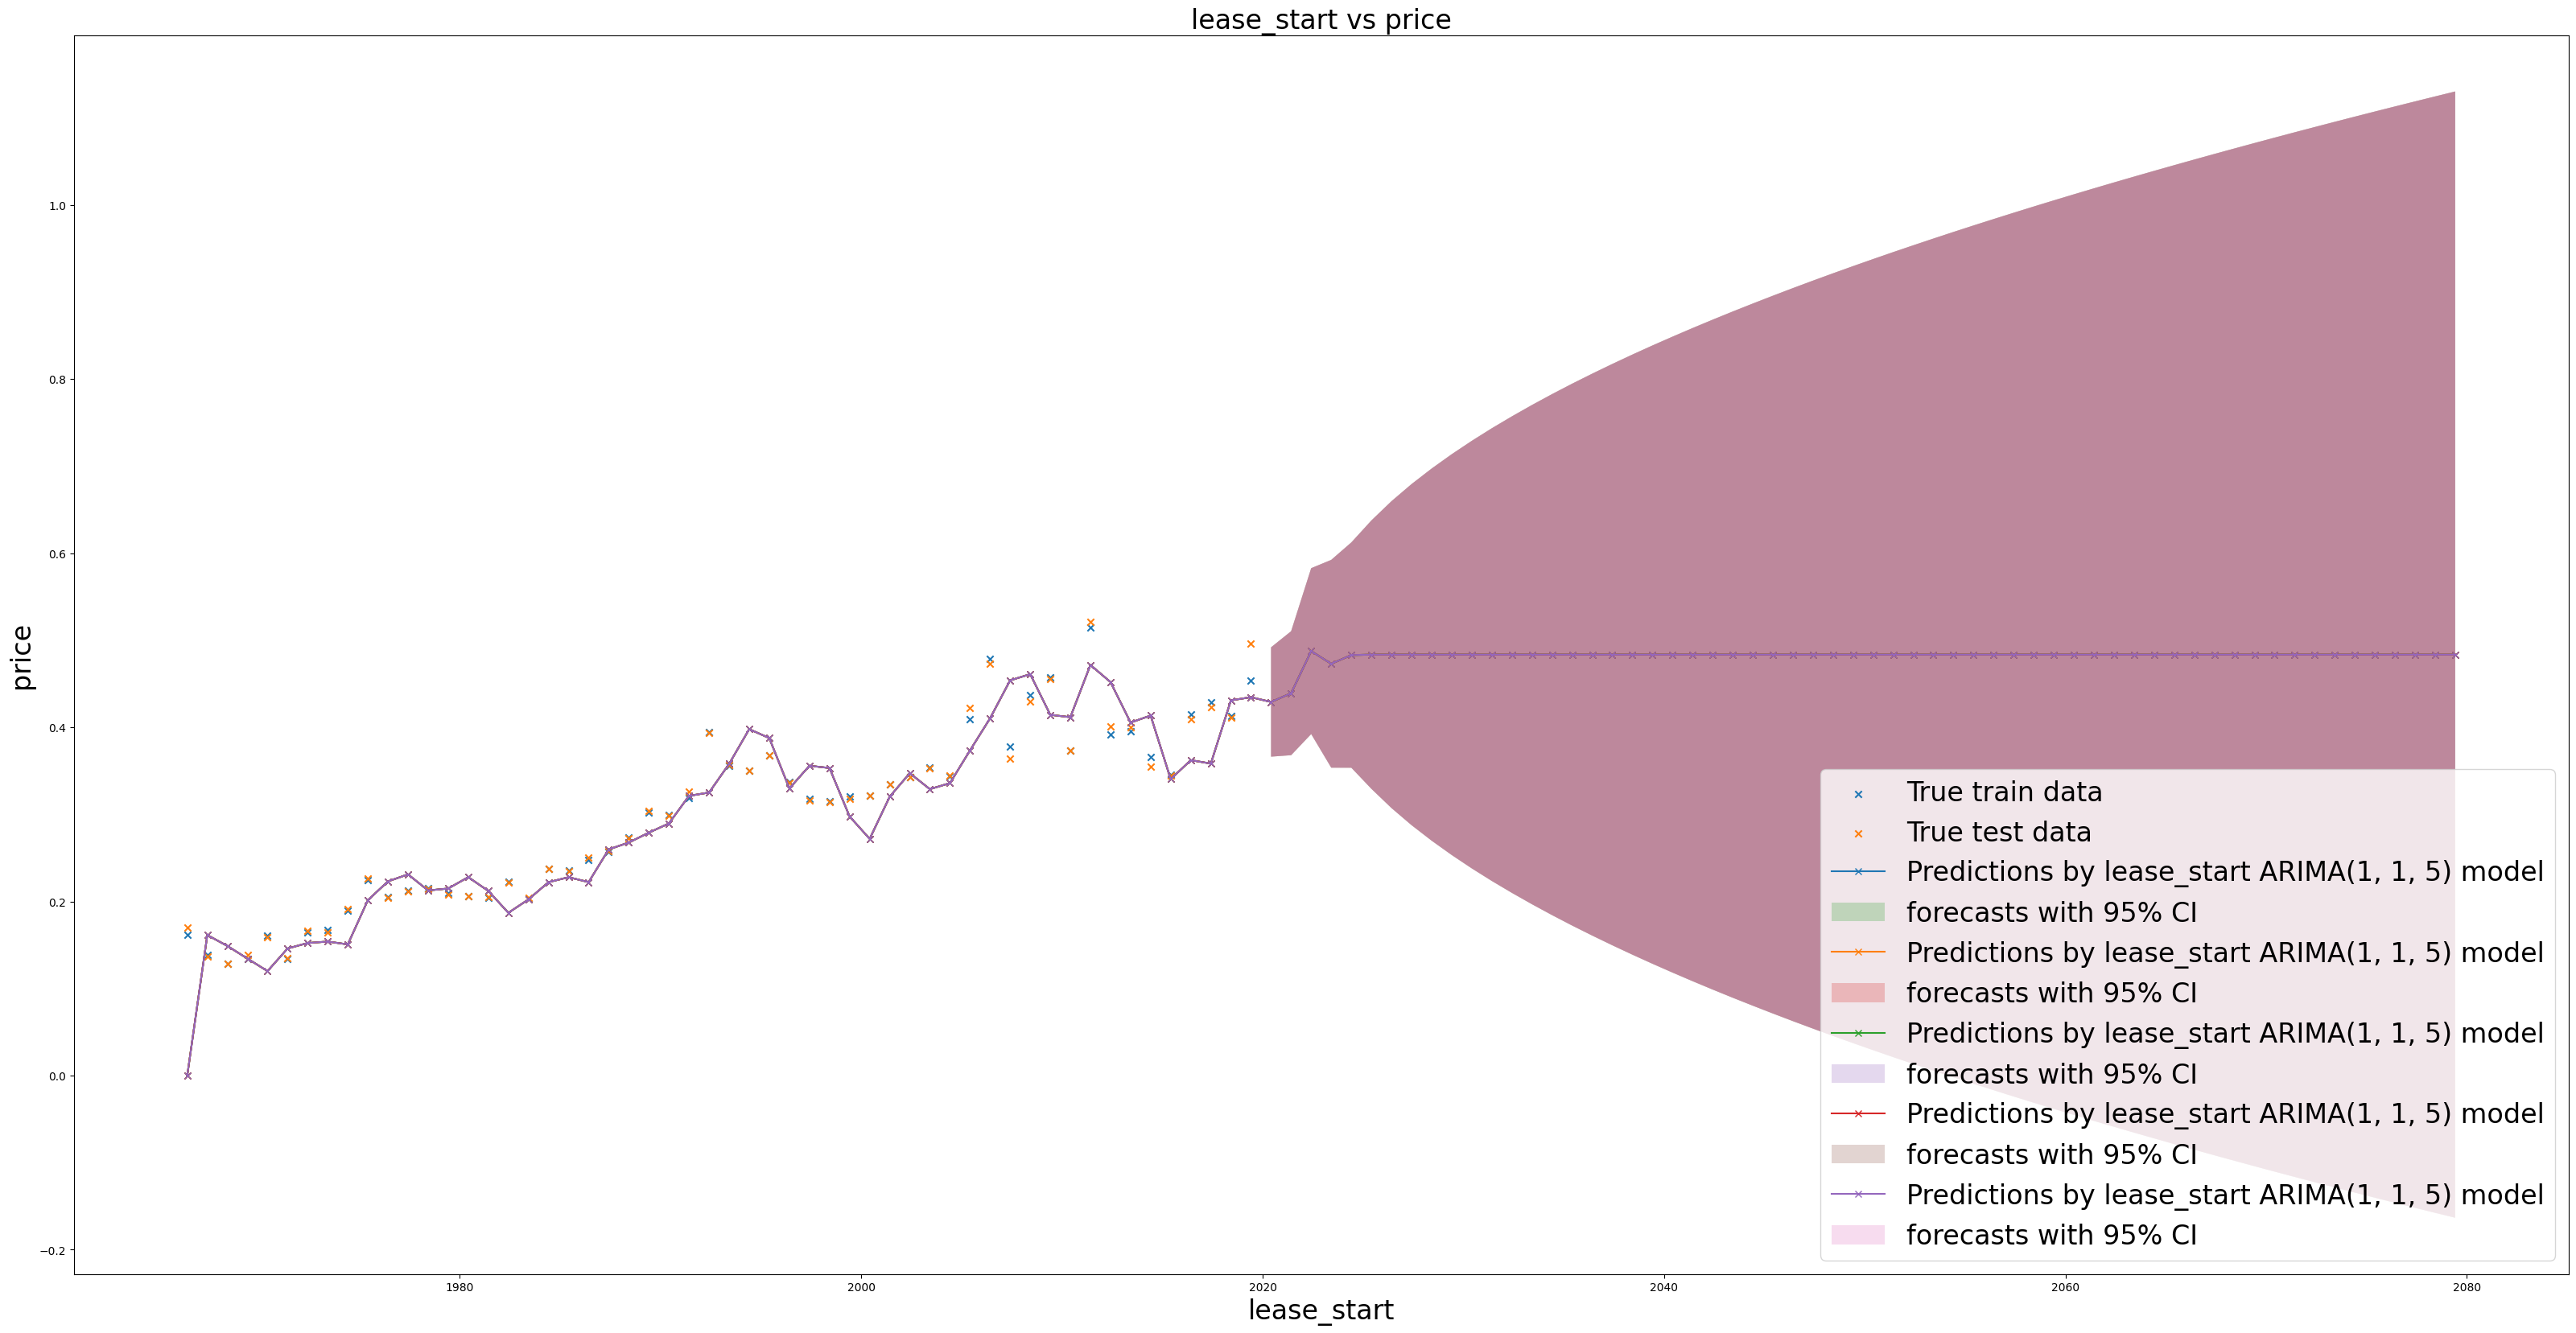

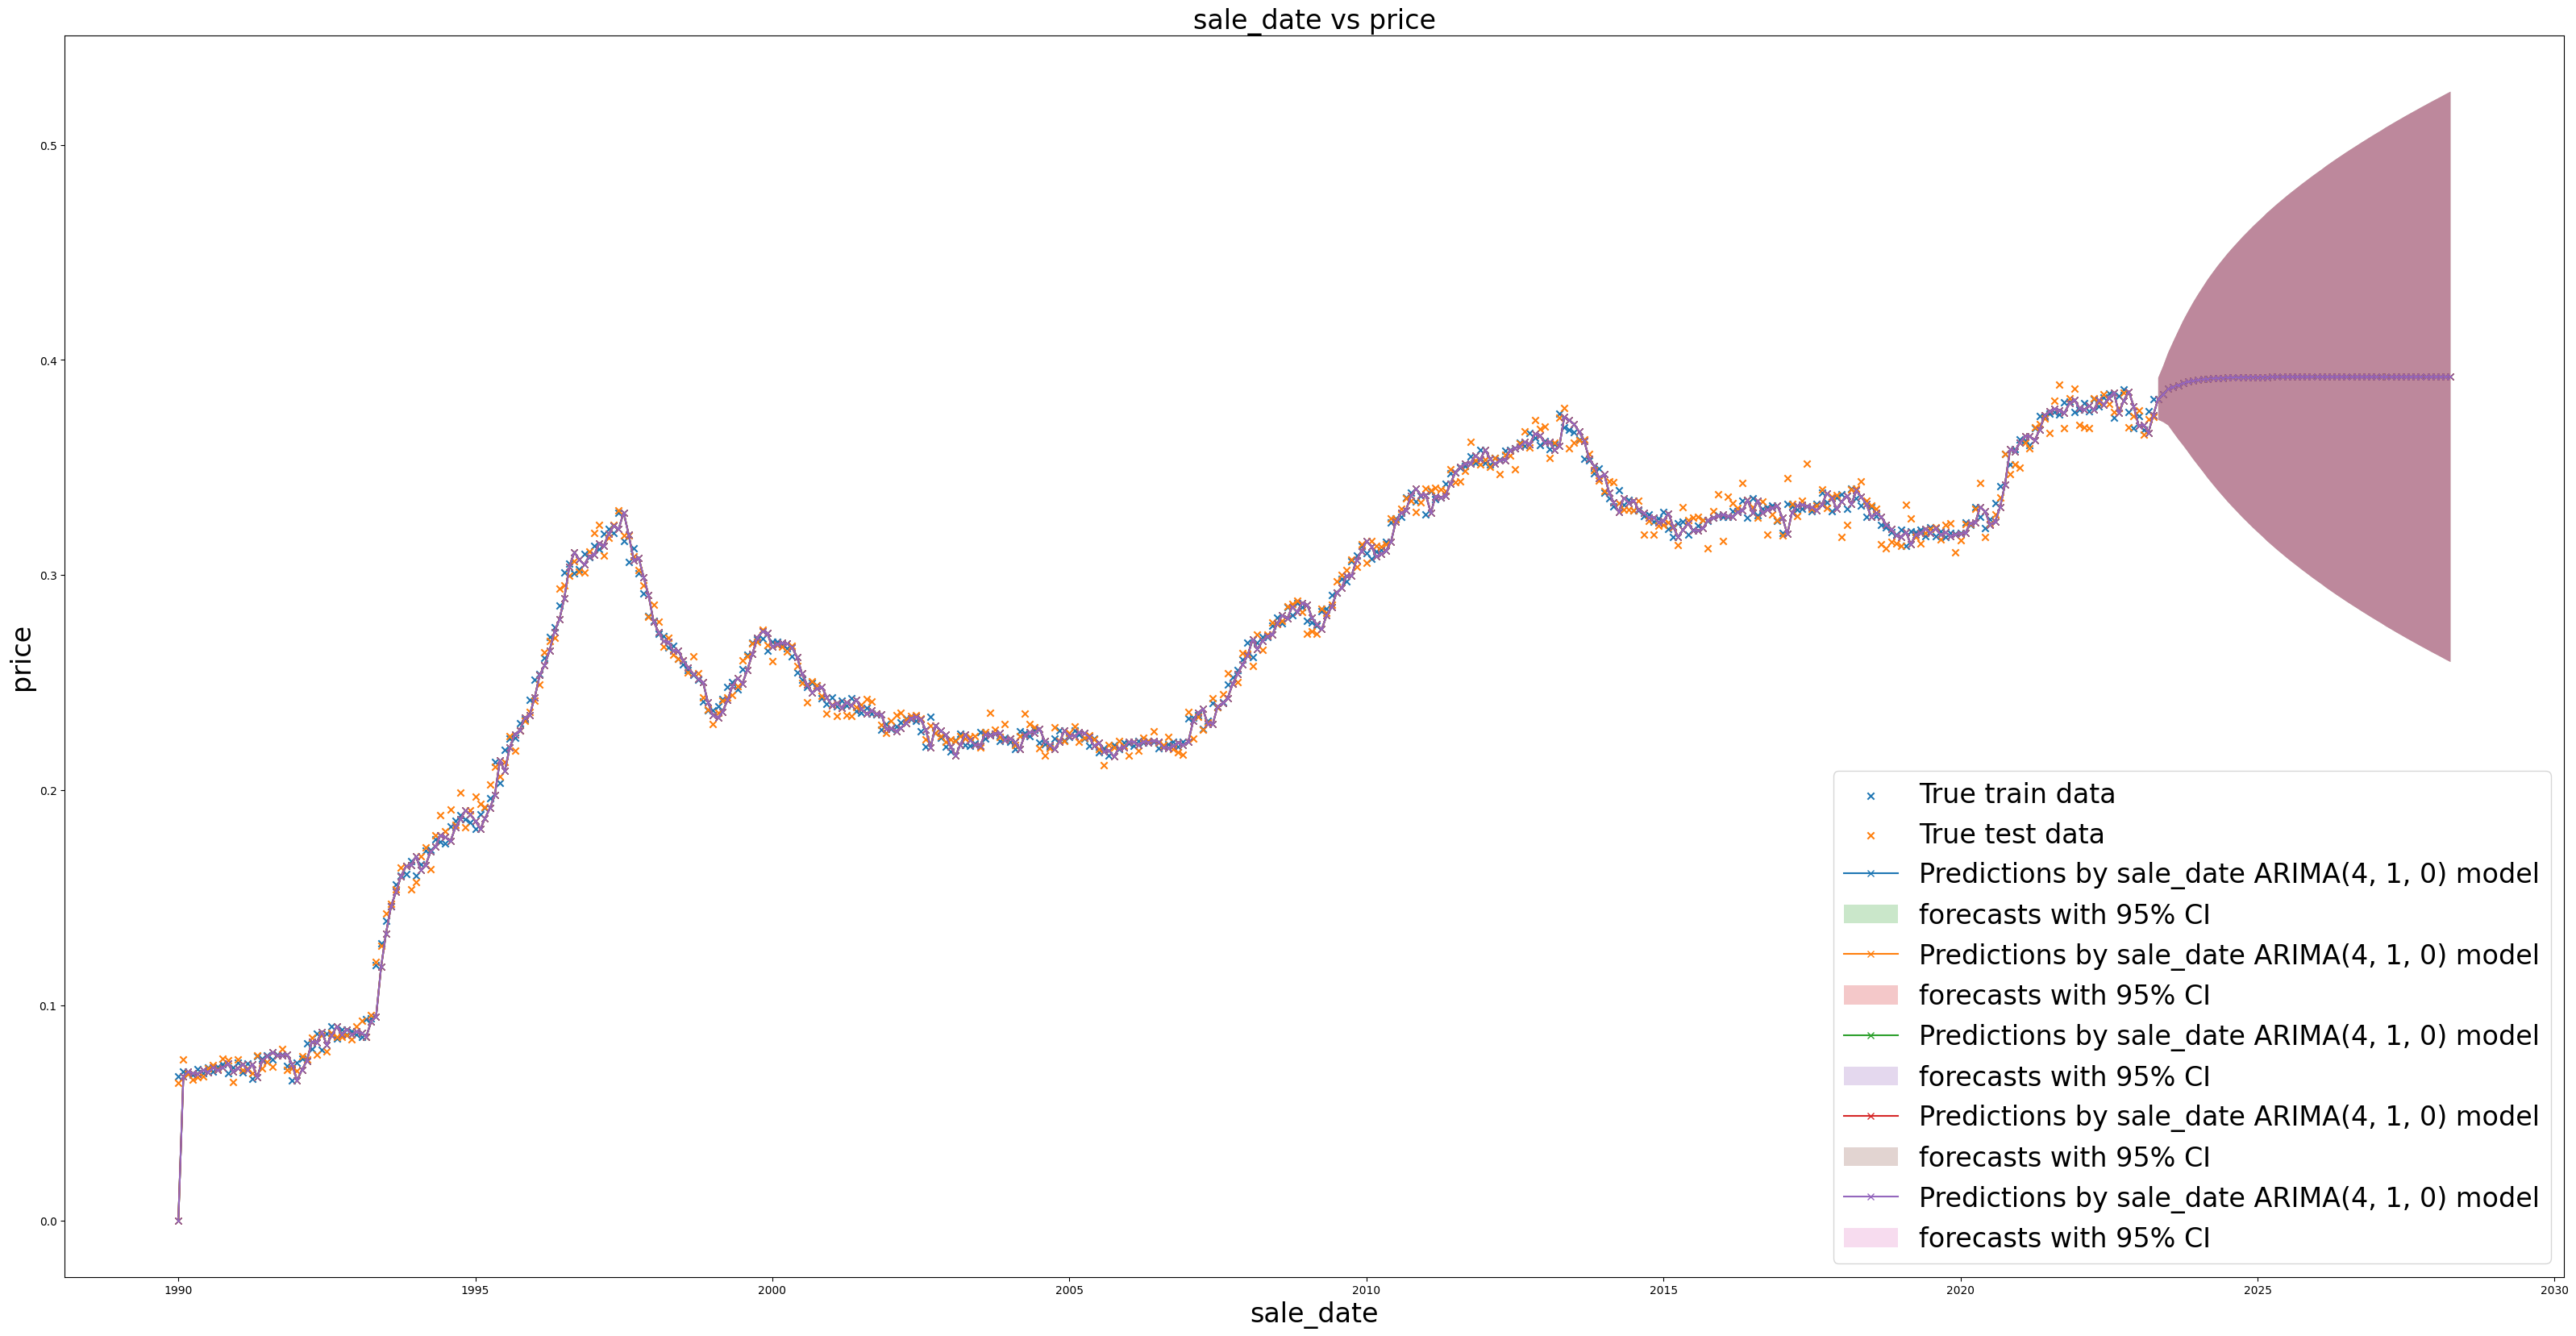

Metrics for best model of lease_start:
Model used: ARIMA(1, 1, 5)
    mae: 0.02792421926942556
    mse: 0.0015099843229565387
    err <05%: 0.35185185185185186
    err <10%: 0.6111111111111112
    err <15%: 0.7962962962962963
    err <20%: 0.9259259259259259
    err <25%: 0.962962962962963
    err <30%: 0.9814814814814815

Metrics for best model of sale_date:
Model used: ARIMA(4, 1, 0)
    mae: 0.004012902963228407
    mse: 3.596281999219344e-05
    err <05%: 0.95
    err <10%: 0.9825000000000002
    err <15%: 0.9949999999999999
    err <20%: 0.9949999999999999
    err <25%: 0.9975000000000002
    err <30%: 0.9975000000000002



<ipython-input-46-0a0c0efdf376>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_report_df=base_model_report_df.append(data_dict, ignore_index=True)
<ipython-input-46-0a0c0efdf376>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_report_df=base_model_report_df.append(data_dict, ignore_index=True)


In [ ]:
# Generating plots of models against actual data

for feature in time_features:
    # Getting true data (from train set)
    data_train_tmp=time_series_data["train"][feature]
    indices_train=data_train_tmp.index
    true_values_train=data_train_tmp.values

    # Getting true data (from test set)
    data_test_tmp=time_series_data["test"][feature]
    indices_test=data_test_tmp.index
    true_values_test=data_test_tmp.values

    # Getting predicted data and plotting
    fig=plt.figure(figsize=(40, 20))
    plt.scatter(indices_train, true_values_train, label="True train data", marker="x")
    plt.scatter(indices_test, true_values_test, label="True test data", marker="x")

    for i, model in enumerate(time_models[feature]):
        forecast=model.get_forecast(60)

        # Predicting and plotting on train data
        predictions_train=model.predict(indices_train.min(), indices_train.max())
        plt.plot(np.append(indices_train, forecast.predicted_mean.index),
                 np.append(predictions_train, forecast.predicted_mean.values),
                 label=f"Predictions by {feature} ARIMA{TIME_SELECTED_ORDERS[feature]} model", marker="x")

        plt.fill_between(forecast.predicted_mean.index,
                         forecast.conf_int()["lower y"].values,
                         forecast.conf_int()["upper y"].values,
                         alpha=0.25, label="forecasts with 95% CI")
    plt.legend(fontsize=24, loc="lower right")

    plt.xlabel(f"{feature}", fontsize=24)
    plt.ylabel("price", fontsize=24)
    plt.title(f"{feature} vs price", fontsize=24)
    plt.show()

# Formatting and displaying metrics
for feature in time_features:
    print(f"Metrics for best model of {feature}:")
    print(f"Model used: ARIMA{TIME_SELECTED_ORDERS[feature]}")
    for metric in time_model_metrics[feature]:
        current_score=np.average(time_model_metrics[feature][metric])
        time_model_metrics[feature][metric]=current_score
        print(f"    {metric}: {current_score}")
    print()

# Adding performance data to base data df
for feature in time_features:
    data_dict={}
    for metric in time_model_metrics[feature]:
        data_dict[metric]=time_model_metrics[feature][metric]
    data_dict["best h-param"]=f"Order{TIME_SELECTED_ORDERS[feature]}"
    data_dict["model"]=feature
    base_model_report_df=base_model_report_df.append(data_dict, ignore_index=True)

## Base model reporting

In [ ]:
display(base_model_report_df)

model         best h-param       mae       mse  err <05%  err <10%  \
0          cat  a=5.999999999999999  0.059940  0.006366  0.549383  0.824074   
1          num                  a=0  0.057153  0.006034  0.557347  0.843120   
2  lease_start       Order(1, 1, 0)  0.029588  0.001806  0.370370  0.555556   
3    sale_date       Order(4, 1, 0)  0.004013  0.000036  0.950000  0.982500   
4  lease_start       Order(1, 1, 5)  0.027924  0.001510  0.351852  0.611111   
5    sale_date       Order(6, 1, 0)  0.003988  0.000036  0.952500  0.982500   

   err <15%  err <20%  err <25%  err <30%  
0  0.935185  0.972222  0.987654  1.000000  
1  0.940469  0.974014  0.989048  0.996215  
2  0.814815  0.907407  0.981481  0.981481  
3  0.995000  0.995000  0.997500  0.997500  
4  0.796296  0.925926  0.962963  0.981481  
5  0.995000  0.995000  0.997500  0.997500

model         best h-param       mae       mse  err <05%  err <10%  \
0          cat  a=5.999999999999999  0.059940  0.006366  0.549383  0.824074   
1          num                  a=0  0.057153  0.006034  0.557347  0.843120   
2  lease_start       Order(1, 1, 5)  0.027924  0.001510  0.351852  0.611111   
3    sale_date       Order(6, 1, 0)  0.003988  0.000036  0.952500  0.982500   

   err <15%  err <20%  err <25%  err <30%  
0  0.935185  0.972222  0.987654  1.000000  
1  0.940469  0.974014  0.989048  0.996215  
2  0.796296  0.925926  0.962963  0.981481  
3  0.995000  0.995000  0.997500  0.997500

# Meta pipelines



## Importing modules cleaning data, and defining critical values


In [ ]:
# Importing necessary modules
import numpy as np
import pandas as pd
import scipy
import statistics as stats
from statsmodels.tsa.stattools import adfuller
import math
import datetime as dt

# Data visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from statsmodels.tsa.stattools import acf, pacf

# Encoding and preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.tsa.arima.model import ARIMA as Arima

# Scoring
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Defining columns
categorical_columns=["town", "type", "model"]
numerical_columns=["price", "storey", "size", "lease_left"]
time_columns=["lease_start", "sale_date"]

# Defining critical model hyperparameters
best_base_hyperparameters={"cat_ridgereg_alpha":6,
                           "num_linreg_alpha": 0,
                           "time_sale_date_order": (4, 1, 0),
                           "time_lease_start_order": (1, 1, 0)}
pass

In [ ]:
# Loading, combining, cleaning data

Jan_1990_df=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Jan1990.csv")
Jan_2000_df=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Jan2000.csv")
Mar_2012_df=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Mar2012.csv")
Jan_2015_pd=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Jan2015.csv")
Jan_2017_pd=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Jan2017.csv")
df_raw=pd.concat([Jan_1990_df, Jan_2000_df, Mar_2012_df, Jan_2015_pd, Jan_2017_pd], ignore_index=True)

# Dealing with storey range
df_raw["storey_range"]=((df_raw["storey_range"].str.slice(0, 2).astype('int'))+(df_raw["storey_range"].str.slice(-2,).astype('int')))/2

# Cleaning strings and formatting datetimes
df_raw["month"]=pd.to_datetime(df_raw["month"], format="%Y-%m-%d")
df_raw["lease_commence_date"]=pd.to_datetime(df_raw["lease_commence_date"], format="%Y")
df_raw["remaining_lease"]=df_raw["month"]-df_raw["lease_commence_date"]
df_raw["remaining_lease"]=(99-((df_raw["remaining_lease"].dt.days)/365.25)).round(decimals=0)
for column in df_raw:
    try: df_raw[column]=df_raw[column].str.upper()
    except: pass
    try: df_raw[column]=df_raw[column].str.replace("-", " ")
    except: pass

# Extracting and formatting inflation data
"""Inflation data is current up to April 2023. Therefore, rows with transactions after that are discarded to maintain model accuracy.
Total inflation was used instead of housing inflation to ensure that prices in the data to be analysed refers to real prices"""
inflation_pd=pd.read_csv("/content/drive/MyDrive/Colab data/resale-flat-prices/Inflation_data.csv")
inflation_pd["datekey"]=(inflation_pd["Year"]*100+inflation_pd["Month"]).astype(int)
inflation_pd=inflation_pd[["datekey", "Inflation (2019 is base)"]]
inflation_pd=inflation_pd.rename(columns={"Inflation (2019 is base)": "inflation_base_2019"})

# Conducting inner join of inflation data and formatting df_raw
df_raw["datekey"]=df_raw["month"].dt.year*100+df_raw["month"].dt.month # datekey is an int64
df_raw=df_raw.join(inflation_pd.set_index('datekey'), on='datekey')
df_raw=df_raw[df_raw["inflation_base_2019"].isna()==False] # discarding of data without inflation value
df_raw["resale_price"]=df_raw["resale_price"]/((df_raw["inflation_base_2019"])/100)
df_raw=df_raw.drop(columns=["inflation_base_2019"]) # Dropping inflation data

# Renaming and reordering df_raw columns
df_raw=df_raw.rename(columns={
    "month": "sale_date",
    "flat_type": "type",
    "street_name":"st_name",
    "storey_range": "storey",
    "floor_area_sqm":"size",
    "flat_model": "model",
    "lease_commence_date": "lease_start",
    "resale_price": "price",
    "remaining_lease":"lease_left"})
df_raw=df_raw[["town", "st_name", "type", "model", "storey", "size", "sale_date", "lease_start", "lease_left", "price"]]

display(df_raw.describe())

# Normalising numerical features and labels
normaliser_raw=MinMaxScaler(feature_range=(0, 1)).fit(df_raw[numerical_columns])
df_raw[numerical_columns]=normaliser_raw.transform(df_raw[numerical_columns])

 # Truncating of categoricals
CAT_TRUNCATION_TOLERANCE=0.05 # Drop rows of targetted data that appears less than this percentage relative to entire dataset
df_stratified = pd.DataFrame()
pcts={}
total=len(df_raw.index)
for column in categorical_columns:
    uniques=df_raw[column].unique()
    pcts[column]={}
    col_ave=total/len(uniques)
    for unique in uniques:
        count=len(df_raw[df_raw[column]==unique])
        pcts[column][unique]=count/col_ave

for column in categorical_columns:
    for key in pcts[column].keys():
        if pcts[column][key]<=CAT_TRUNCATION_TOLERANCE:
            indices = df_raw[df_raw[column]==key].index
            df_raw.drop(indices, inplace=True)

# "Rounding" datetime data
slices=12 # Number of slices of a year to split dates into (must be factor of 12)

# Rounding datetimes by n cuts
for feature in time_columns:
    df_tmp=pd.DataFrame()
    df_tmp["day"]=df_raw[feature].dt.day.astype(str)
    df_tmp["year"]=df_raw[feature].dt.year.astype(str)

    df_tmp["month"]=df_raw[feature].dt.month
    df_tmp["month"]=pd.cut(df_tmp["month"], slices, labels=False).astype(int)
    df_tmp["month"]=(int(12/slices)*(df_tmp["month"]+1)).astype(str)

    df_raw[feature] = pd.to_datetime(df_tmp["year"] + "/" + df_tmp["month"] + "/" + df_tmp["day"])

<ipython-input-3-6ef5e76185c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["resale_price"]=df_raw["resale_price"]/((df_raw["inflation_base_2019"])/100)


storey           size     lease_left         price
count  898455.000000  898455.000000  898455.000000  8.984550e+05
mean        7.654935      95.707379      80.918785  3.664578e+05
std         4.779166      25.890616      10.459718  1.622284e+05
min         2.000000      28.000000      42.000000  7.996162e+03
25%         5.000000      73.000000      74.000000  2.499706e+05
50%         8.000000      93.000000      83.000000  3.505918e+05
75%        11.000000     113.000000      89.000000  4.622708e+05
max        50.000000     307.000000     101.000000  1.302878e+06

## Defining base pipeline functions

In [ ]:
# Defining general preprocessing and splitting functions
    # split_feature_df(df): take raw input and split into 3 dfs (features only) and labels
    # strat_split_by_cat(df, frac_samples=0.85, random_state=1): conduct split of raw input into train and test,
        # in a stratified manner for categorical features (time stratification to be included in future patches)
def split_feature_df(df):
    """ Takes as input a dataframe containing ["town", "st_name", "type", "model", "storey", "size", "sale_date", "lease_start", "lease_left", "price"]
    Returns as output 3 dataframes and 1 array in order df_cat, df_num, df_time, labels """
    expected_columns=["town", "st_name", "type", "model", "storey", "size", "sale_date", "lease_start", "lease_left", "price"]
    if not any(column in expected_columns for column in df.columns):
        print("Error splitting df, missing columns")
        print(f"Expected columns: {expected_columns}")
        print(f"Got columns: {df.columns}")
        return None
    else:
        df_cat=df[["town", "type", "model"]].copy()
        df_num=df[["storey", "size", "lease_left"]].copy()
        df_time=df[["lease_start", "sale_date"]].copy()
        labels=df["price"]
        return df_cat, df_num, df_time, labels

def strat_split_by_cat(df, frac_samples=0.85, random_state=1):
    # Note that actual frac_samples will be significantly higher than specified due to nature of split
        # To validate with last return value, as specified below
    """Takes as input a df
    Returns as output df_train and df_test, split in a sstratified manner wrt categorical features"""
    frac_samples=frac_samples # actual fraction extracted is significantly more than this

    # Extract "sampled" train df
    df_sampled = pd.DataFrame()
    for feature in ["town", "type", "model"]:
        data_stratified=df.groupby(feature, as_index=False, group_keys=False)
        data_stratified=data_stratified.apply(lambda x: x.sample(frac=frac_samples, random_state=random_state))
        df_sampled=pd.concat([df_sampled, data_stratified])
    df_sampled=df_sampled.drop_duplicates()

    # Extract "unsampled" test df
    df_sampled_indices=df_sampled.index.values
    df_unsampled=df.drop(index=df_sampled_indices)

    return df_sampled, df_unsampled

In [ ]:
# Defining model specific preprocessing sections
    # cat_preprocess(df_cat): Conducts preprocessing for categorical ridge model
        # Conducts onehotencoding, polynomialising
    # numerical data does not need to be further preprocessed
    # time_preprocess_for_training(df_time, labels): Uses inputs to generate a dict of series where the index is the column value of df_time and value is label
        # key is the feature in qn

def cat_preprocess(df_cat):
    """ Takes as input a (cat_splitted) dataframe, expected to contain ["storey", "size", "lease_left"]
        Returns as output a sparse matrix containing preprocessed columns of("storey", "size", "lease_left"), and target array

    Data is preprocessed through:
        1) One Hot Encoding
        2) Polynomialising of degree equal to the maximum number of columns targetted (ie. 3), excluding original columns """

    # fitting and transforming encoder to whole dataset
    categorical_encoder=OneHotEncoder(sparse_output=True).fit(df_cat)
    x_preprocessed=categorical_encoder.transform(df_cat)
    x_preprocessed=PolynomialFeatures(len(categorical_encoder.categories_), interaction_only=True).fit_transform(x_preprocessed)

    return x_preprocessed

def time_preprocess_for_training(df_time, labels):
    """ Takes as input df_time and corresponding labels, for training purposes
        Returns as output a dictionary of series with index equal to feature and values equal to labels.
            Returns: series_dict[feature]=pd.Series(index=datetime(feature), value=int(price))"""
    series_dict={}
    for feature in df_time.columns:
        # Generate df and groupbys
        df_tmp=pd.DataFrame.from_dict({feature: df_time[feature].values,
                                       "labels":labels})
        df_tmp_groupby_means=df_tmp.groupby(feature).mean()
        series_dict[feature]=pd.Series(data=df_tmp_groupby_means.values.flatten(), index=pd.DatetimeIndex(data=df_tmp_groupby_means.index, freq="infer"))
    return series_dict

def time_preprocess_for_testing(df_time):
    """ Takes as input a df_time, for testing purposes
        Returns as output a dictionary of array of values containing datetimes
            Returns: series_dict[feature]=np.array(values=datetimes(feature))"""
    array_dict={}
    for feature in df_time.columns:
        array_dict[feature]=np.array(df_time[feature], dtype="M")
    return array_dict



# To note:
    # Categorical model should be fed data that has been split, then preprocessed
        # This is to prevent the model from training on unrepresentative data, and the preprocessor from cocking up

In [ ]:
# Defining get_model functions
    # get_cat_model(x_train_cat, y_cat_train): Gets (trained) categorical model
    # get_num_model(x_train_num, y_train_num): Gets (trained) numerical model
    # get_lease_start_arima(lease_start_train_series): Gets (trained) arima model for lease_start
    # get_sale_date_arima(sale_date_train_series): Gets (trained) arima model for sale_date

def get_cat_model(x_train_cat, y_cat_train):
    """Takes as input preprocessed training data and corresponding labels
        Returns as output a categorical model trained on aforementioned data"""
    cat_model=Ridge(alpha=best_base_hyperparameters["cat_ridgereg_alpha"]).fit(x_train_cat, y_cat_train)
    return cat_model

def get_num_model(x_train_num, y_train_num):
    num_model=LinearRegression().fit(x_train_num, y_train_num)
    return num_model

def get_lease_start_arima(lease_start_train_series):
    lease_start_arima=Arima(lease_start_train_series, order=best_base_hyperparameters["time_lease_start_order"]).fit()
    return lease_start_arima

def get_sale_date_arima(sale_date_train_series):
    sale_date_arima=Arima(sale_date_train_series, order=best_base_hyperparameters["time_sale_date_order"]).fit()
    return sale_date_arima

In [ ]:
def get_base_predictions(x, cat_model, num_model, time_lease_start_model, time_sale_date_model):
    """ Takes as input predictions as df with columns corresponding to df_raw, the 4 fitted models,
        Returns as output a df of predictions with columns ["cat_preds", "num_preds", "lease_start_preds", "sale_date_preds"]"""
    # Split data
    df_cat, x_num, df_time, labels=split_feature_df(x)

    # Preprocess data as needed
    x_cat=cat_preprocess(df_cat)
    x_time_lease_start=df_time["lease_start"].values
    x_time_sale_date=df_time["sale_date"].values

    # Generate predictions using fitted models
    predictions=pd.DataFrame()
    predictions["cat_preds"]=cat_model.predict(x_cat)
    predictions["num_preds"]=num_model.predict(x_num)
    lease_start_preds=time_lease_start_model.predict(x_time_lease_start)
    sale_date_preds=time_sale_date_model.predict(x_time_sale_date)
    predictions["lease_start_preds"]=np.array(lease_start_preds)
    predictions["sale_date_preds"]=np.array(sale_date_preds)

    return predictions

def get_base_predictions_for_training(x, cat_model, num_model, time_lease_start_model, time_sale_date_model):
    """ Takes as input predictions as df with columns corresponding to df_raw, the 4 fitted models,
        Returns as output a df of predictions with columns ["cat_preds", "num_preds", "lease_start_preds", "sale_date_preds"]

        This function differs from the previous one in that it generates time series predictions once for all unique values,
        then stores mappings from feature to prediction values as a dict, then uses it for the generation of the "predctions" of
        the relevant base model, for speed"""

    def get_single_dt_prediction(arima_model, dt):
        return arima_model.predict(start=dt, end=dt).values[0]

    # Split data
    df_cat, x_num, df_time, labels=split_feature_df(x)

    # Preprocess data as needed
    x_cat=cat_preprocess(df_cat)
    x_time_lease_start=df_time["lease_start"].values
    x_time_sale_date=df_time["sale_date"].values

    # Generate predictions using fitted models
    predictions=pd.DataFrame()
    predictions["cat_preds"]=cat_model.predict(x_cat)
    predictions["num_preds"]=num_model.predict(x_num)

    # Generate dict of time series predictions
    time_preds={"lease_start_preds":{},
                "sale_date_preds":{}}
    for dt in np.unique(x_time_lease_start):
        time_preds["lease_start_preds"][dt]=get_single_dt_prediction(time_lease_start_model, dt)
    for dt in np.unique(x_time_sale_date):
        time_preds["sale_date_preds"][dt]=get_single_dt_prediction(time_sale_date_model, dt)

    lease_start_preds=[time_preds["lease_start_preds"][dt] for dt in x_time_lease_start]
    sale_date_preds=[time_preds["sale_date_preds"][dt] for dt in x_time_sale_date]

    predictions["lease_start_preds"]=np.array(lease_start_preds)
    predictions["sale_date_preds"]=np.array(sale_date_preds)

    return predictions


## Generating base train-test outputs, EDA

In [ ]:
# Generating base model output data for train and test
# Splitting data
df_raw_train, df_raw_test=strat_split_by_cat(df_raw, frac_samples=0.45, random_state=1)
df_cat_train, x_train_num, df_time_train, y_train=split_feature_df(df_raw_train)
df_cat_test, x_test_num, df_time_test, y_test=split_feature_df(df_raw_test)

x_train_cat=cat_preprocess(df_cat_train)
x_train_time_dict=time_preprocess_for_training(df_time_train, y_train)

# Getting fitted models
cat_model=get_cat_model(x_train_cat, y_train)
num_model=get_num_model(x_train_num, y_train)
time_lease_start_model=get_lease_start_arima(x_train_time_dict["lease_start"])
time_sale_date_model=get_sale_date_arima(x_train_time_dict["sale_date"])

# Getting predicted training and testing data dfs
base_preds_train=get_base_predictions_for_training(df_raw_train, cat_model, num_model, time_lease_start_model, time_sale_date_model)
base_preds_test=get_base_predictions_for_training(df_raw_test, cat_model, num_model, time_lease_start_model, time_sale_date_model)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Collecting base model error data

# Defining error percentages to consider
# ERROR_PCTS=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
ERROR_PCTS=[0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]


# Putting all base_preds_train error values into a df
base_pred_error_pcts=pd.DataFrame()
for column in base_preds_test.columns:
    base_pred_error_pcts[f"{column}_error_pct"]=(np.abs(base_preds_test[column]-y_test.values)/(y_test.values)).clip(0,1)

base_pred_error_abs=pd.DataFrame()
for column in base_preds_test.columns:
    base_pred_error_abs[f"{column}_error"]=(np.abs(base_preds_test[column]-y_test.values)).clip(0,1)

base_pred_errors=pd.concat([base_pred_error_pcts,base_pred_error_abs], axis=1)

# Generating distribution of errors by prevalence for base models
base_error_pct_report_df=pd.DataFrame()
for model in base_pred_error_pcts.columns:
    data_dict={}
    for error_pct in ERROR_PCTS:
        data_dict[f"Error <{error_pct*100}%"]=[sum(base_pred_error_pcts[model]<=error_pct)/len(base_pred_error_pcts[model])]
    base_error_pct_report_df=pd.concat([base_error_pct_report_df, pd.DataFrame(data_dict)], ignore_index=True)

base_error_abs_report_df=pd.DataFrame()
for model in base_pred_error_abs.columns:
    data_dict={}
    for error_pct in ERROR_PCTS:
        data_dict[f"Error <{error_pct}"]=[sum(base_pred_error_abs[model]<=error_pct)/len(base_pred_error_abs[model])]
    data_dict["model"]=model
    base_error_abs_report_df=pd.concat([base_error_abs_report_df, pd.DataFrame(data_dict)], ignore_index=True)

base_error_report_df=pd.concat([base_error_abs_report_df, base_error_pct_report_df], axis=1)

## Meta model selection and EDA

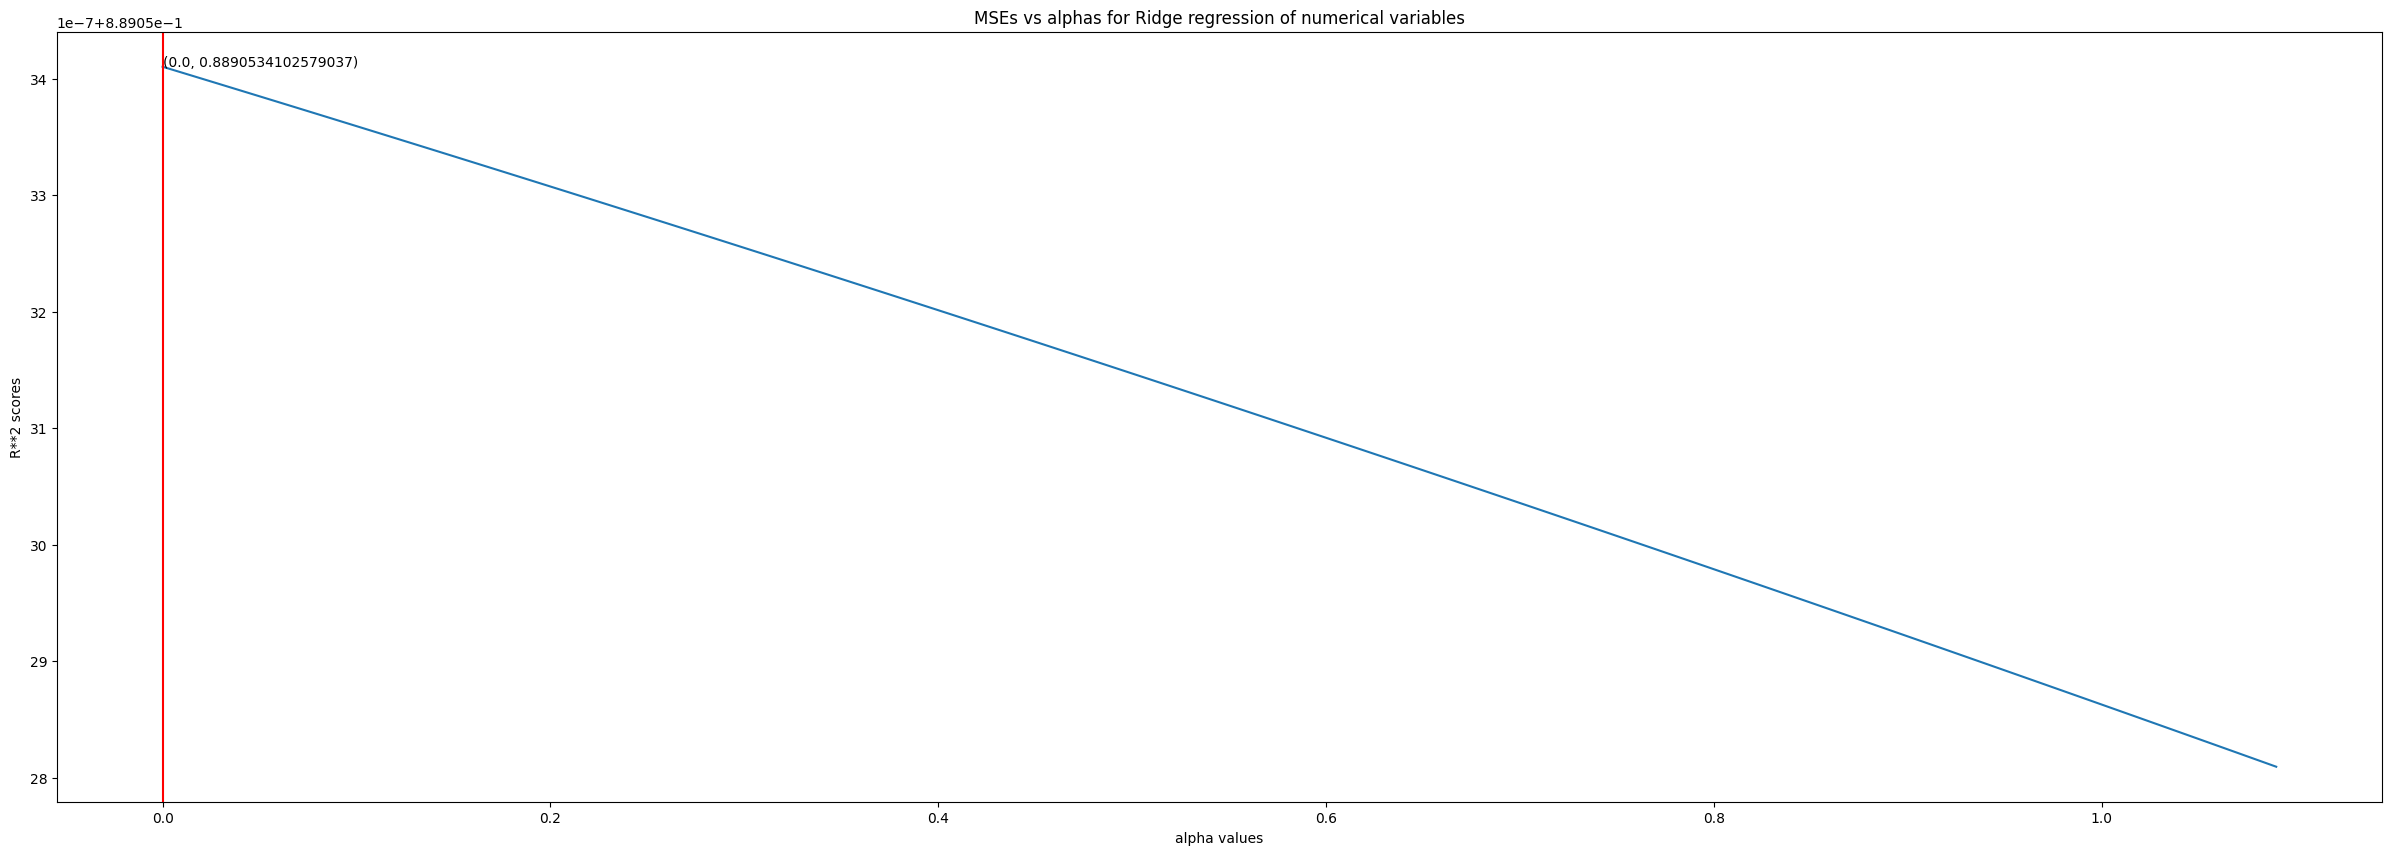

In [ ]:
# Model selection and tuning

alphas=np.arange(0, 1.1, 0.01)
scores={} # scores[alpha]: score (float)
weights={} # weights[alpha]: weights (array)

for alpha in alphas:
    model=Ridge(alpha)
    model.fit(base_preds_train, y_train)
    scores[alpha]=model.score(base_preds_test, y_test)
    weights[alpha]=model.coef_

alphas=list(scores.keys())
score_vals=list(scores.values())
best_a=alphas[score_vals.index(max(score_vals))]

fig=plt.figure(figsize=(30, 10))
plt.plot(scores.keys(), scores.values())
plt.title("MSEs vs alphas for Ridge regression of numerical variables")
plt.xlabel("alpha values")
plt.ylabel("R**2 scores")
plt.axvline(x = best_a, color ='red')
plt.text(best_a, max(score_vals), f"({best_a}, {max(score_vals)})")

plt.show()
#0.8878775861273809

In [ ]:
# Final model regeneration (since a linreg model is clearly the best)
meta_model=LinearRegression().fit(base_preds_train, y_train)

# Reporting on final model and its performance
features=meta_model.feature_names_in_
weights=meta_model.coef_
y_preds=meta_model.predict(base_preds_test)

print("Meta model weights:")
display(pd.Series(data=weights, index=features))

print("\nMeta model weights, centered:")
display(pd.Series(data=weights-np.mean(weights), index=features))

# Generating df regarding meta predictions
meta_preds_data=pd.DataFrame()
meta_preds_data["preds"]=y_preds
meta_preds_data["true values"]=y_test.values
meta_preds_data["errors"]=y_preds-y_test.values
meta_preds_data["error_pcts"]=((y_preds-y_test.values)/(y_test.values))

# Generating distribution of errors by prevalence for meta models
data_dict={}
meta_pred_error_pcts=meta_preds_data["error_pcts"].clip(lower=0, upper=1)
meta_pred_errors=meta_preds_data["errors"].clip(lower=0, upper=1)

for error_pct in ERROR_PCTS:
    data_dict[f"Error <{error_pct*100}%"]=[sum(meta_pred_error_pcts<=error_pct)/len(meta_pred_error_pcts)]

for abs_error in ERROR_PCTS:
    data_dict[f"Error <{abs_error}"]=[sum(meta_pred_errors<=abs_error)/len(meta_pred_errors)]

data_dict["model"]="meta_error"
final_error_report_df=pd.concat([base_error_report_df, pd.DataFrame(data_dict)], ignore_index=True)

display(meta_preds_data.describe())
print()
display(final_error_report_df)

Meta model weights:


cat_preds            0.807068
num_preds            0.165071
lease_start_preds   -0.033041
sale_date_preds      0.783685
dtype: float64


Meta model weights, centered:


cat_preds            0.376372
num_preds           -0.265625
lease_start_preds   -0.463737
sale_date_preds      0.352990
dtype: float64

preds    true values         errors     error_pcts
count  152370.000000  152370.000000  152370.000000  152370.000000
mean        0.275070       0.275046       0.000024       0.003884
std         0.116769       0.123820       0.041243       0.243707
min        -0.122655       0.009445      -0.384961     -11.538886
25%         0.190278       0.185947      -0.020888      -0.080137
50%         0.264305       0.263308       0.002210       0.009237
75%         0.355125       0.349105       0.023139       0.103412
max         0.808755       0.984303       0.284997       3.137838

Error <0.001  Error <0.0025  Error <0.005  Error <0.01  Error <0.025  \
0      0.012483       0.030603      0.061134     0.123574      0.315896   
1      0.012358       0.030045      0.060071     0.119892      0.295019   
2      0.008657       0.021198      0.042049     0.083579      0.203301   
3      0.008256       0.020903      0.042193     0.084885      0.209162   
4      0.484761       0.503341      0.533274     0.596443      0.767415   

   Error <0.05                    model  Error <0.1%  Error <0.25%  \
0     0.588305          cat_preds_error     0.003531      0.008466   
1     0.543985          num_preds_error     0.003203      0.007974   
2     0.389841  lease_start_preds_error     0.002376      0.005684   
3     0.394284    sale_date_preds_error     0.002350      0.005749   
4     0.912470               meta_error     0.475868      0.480173   

   Error <0.5%  Error <1.0%  Error <2.5%  Error <5.0%  
0     0.017051     0.033911     0.083658     0.166293  
1     0.015830     0.031574     0.077916     0.155457  
2     0.011505     0.022833     0.055890     0.110343  
3     0.011315     0.022268     0.057728     0.114996  
4     0.487511     0.502271     0.545330     0.616302

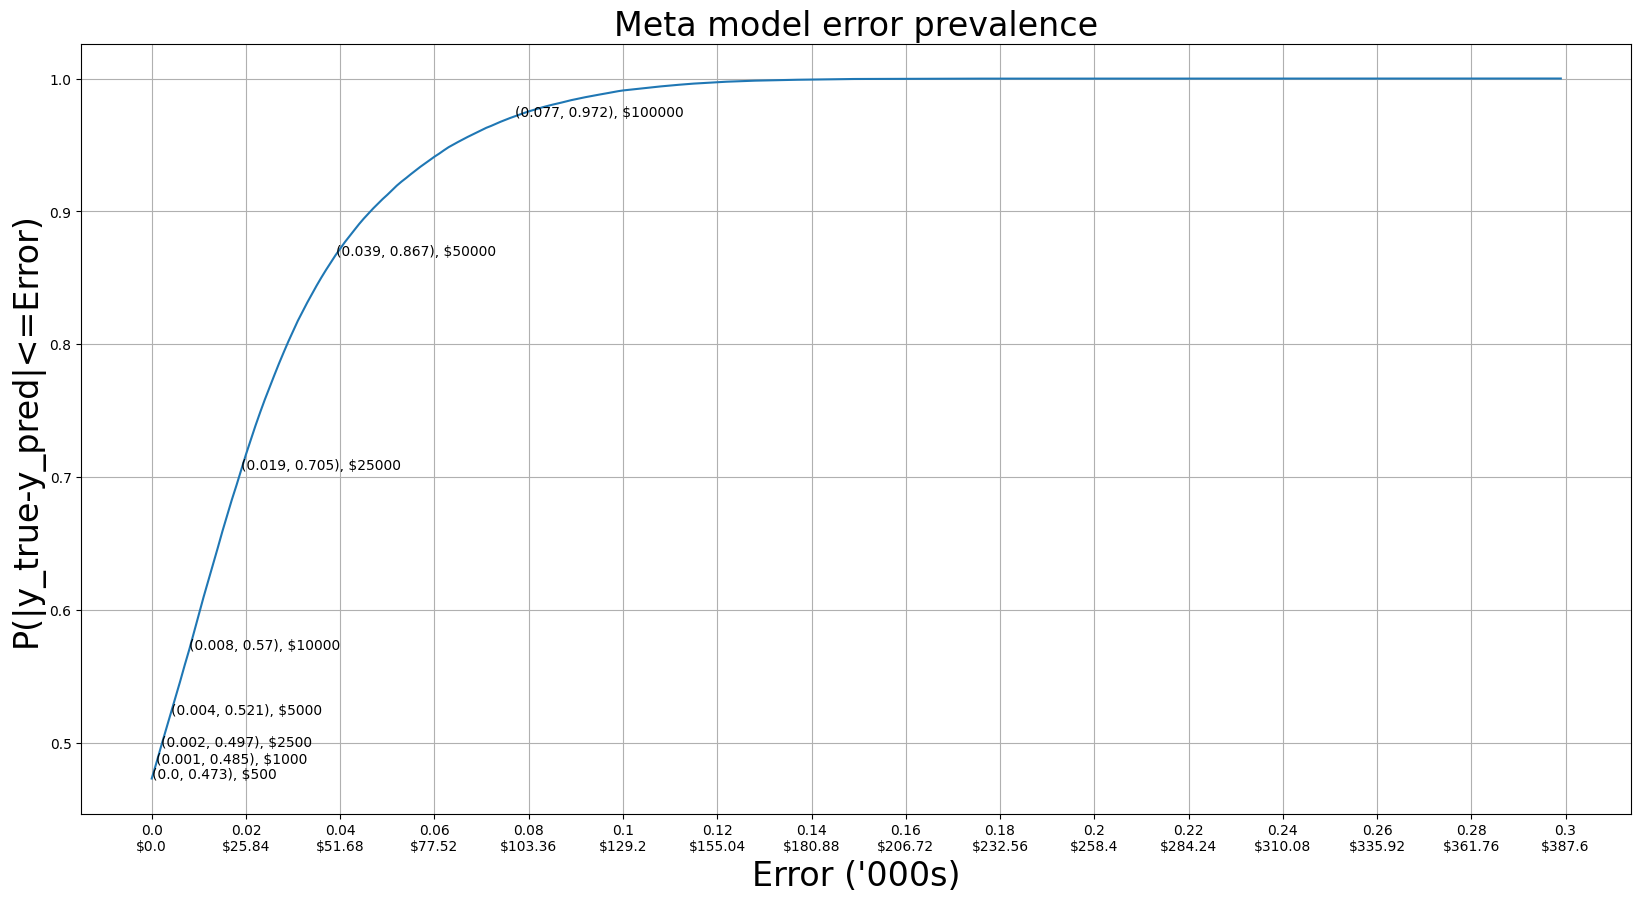

In [47]:
# Plotting meta model error data

# Selecting real values of errors to consider (errors made in terms of actual SGDs)
CRITICAL_REAL_ERRORS=[500, 1000, 2500, 5000, 10000, 25000, 50000, 100000] # eg. 500 refers to error of SGD $500, with 2019 as the base year

fig=plt.figure(figsize=(20, 10))
meta_abs_errors=meta_preds_data["errors"].values
error_prevalence={}
for abs_error in np.arange(0, 0.3, 0.001):
    error_val_pct=sum(meta_abs_errors<=abs_error)/len(meta_abs_errors)
    error_prevalence[abs_error]=error_val_pct
plt.plot(error_prevalence.keys(), error_prevalence.values())
plt.ylabel("P(|y_true-y_pred|<=Error)",  fontsize=24)
plt.xlabel("Error ('000s)", fontsize=24)
plt.title("Meta model error prevalence", fontsize=24)
xticks=np.arange(0, 0.31, 0.02)
xticklabels=[f"{tick}\n${np.round(tick*1292, 2)}" for tick in xticks]
plt.xticks(ticks=xticks,
           labels=xticklabels)
for error in CRITICAL_REAL_ERRORS:
    error_x=np.round((error/1292000), 3)
    plt.text(error_x, error_prevalence[error_x], f"({error_x}, {np.round(error_prevalence[error_x], 3)}), ${error}")
plt.grid()
plt.show()

## Final Model reporting

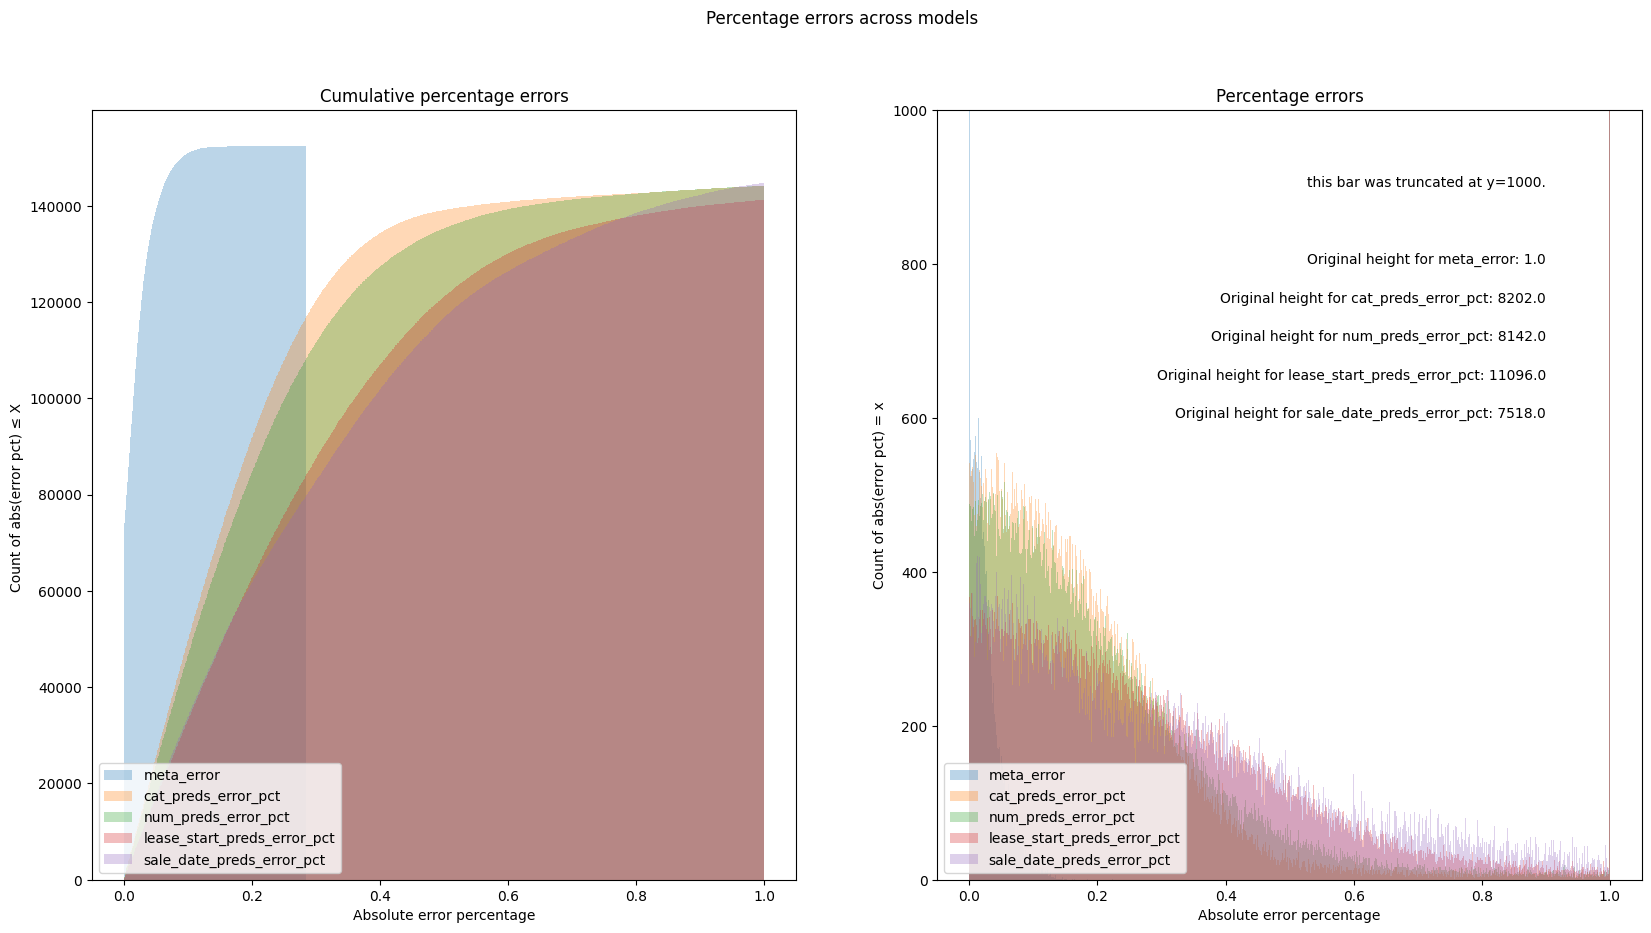

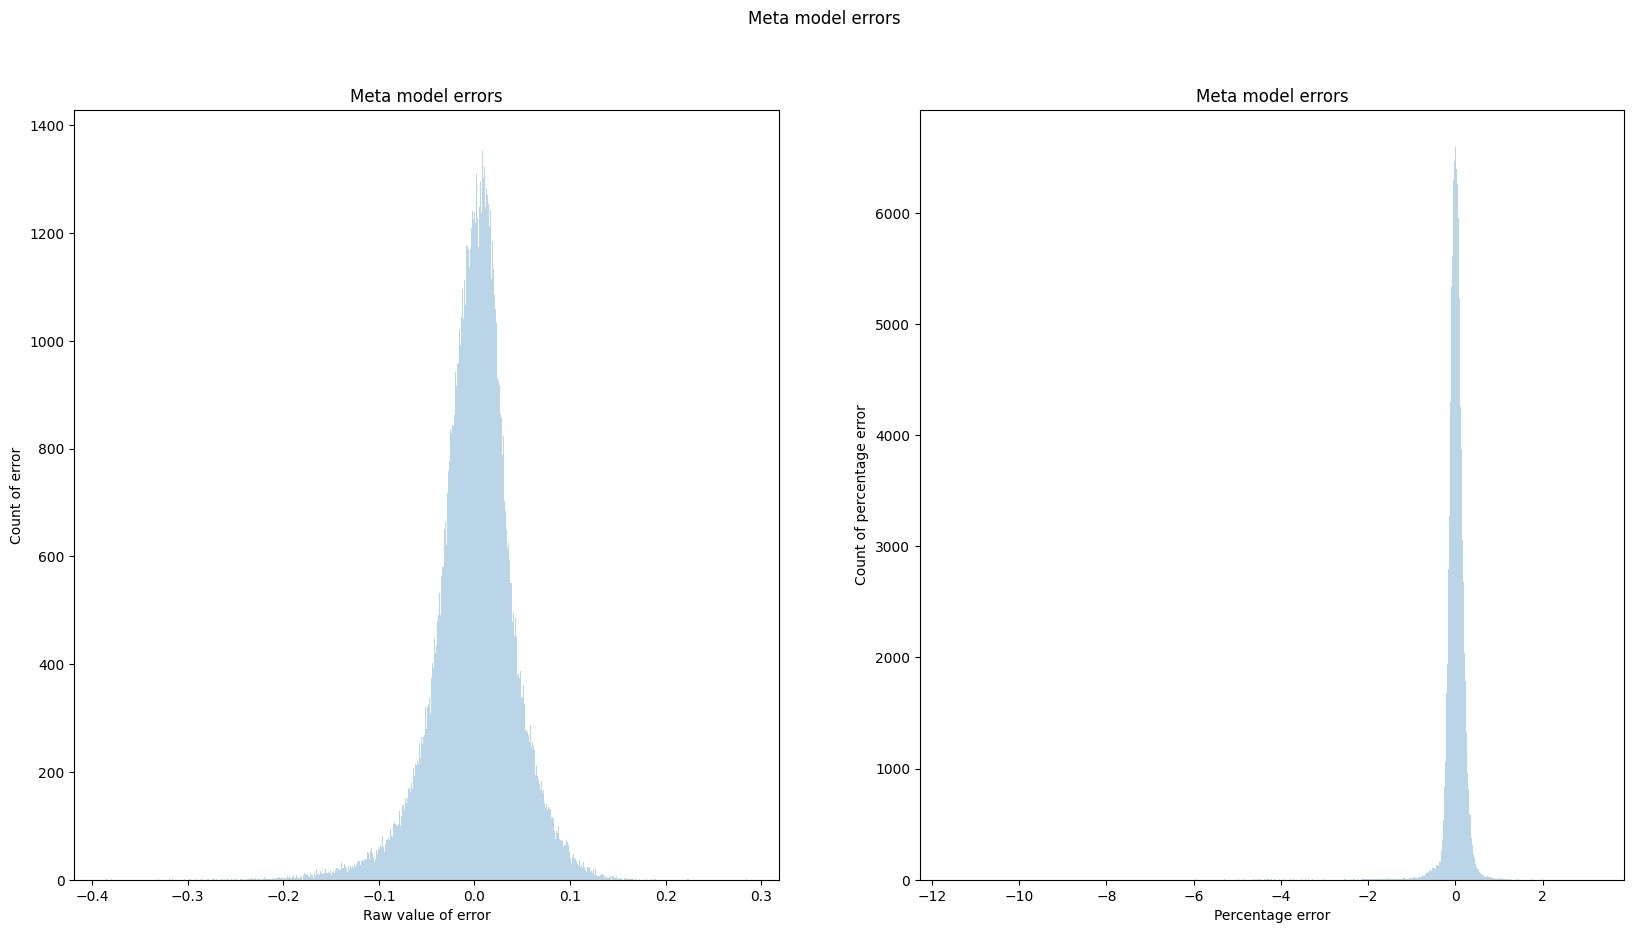

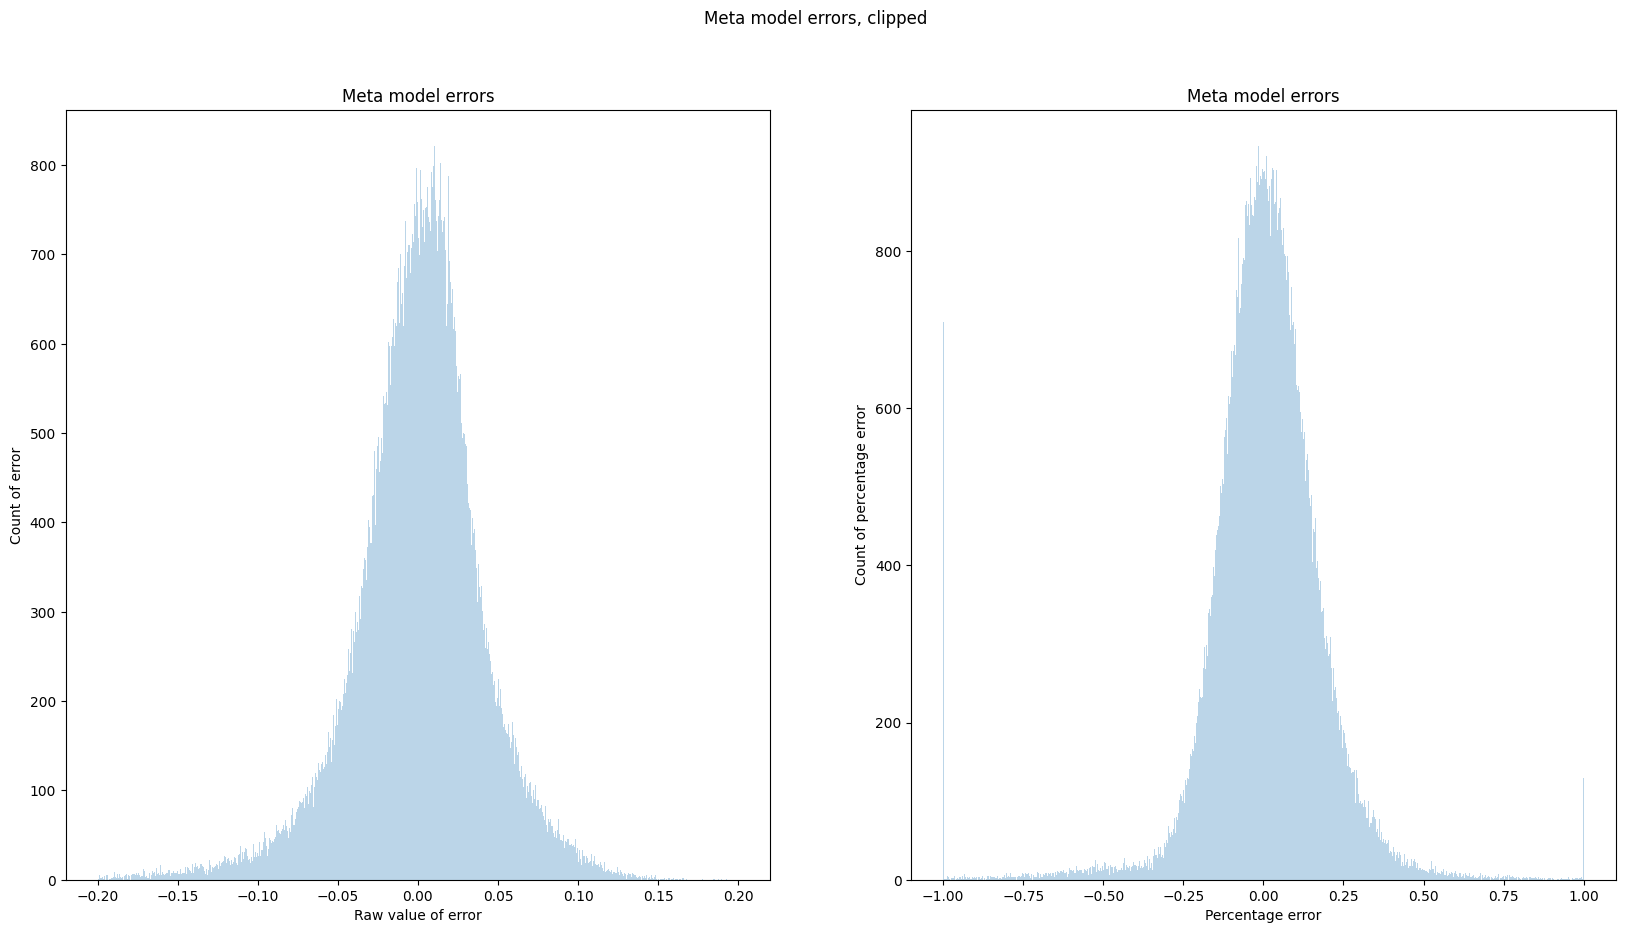

Error <0.001  Error <0.0025  Error <0.005  Error <0.01  Error <0.025  \
0      0.012483       0.030603      0.061134     0.123574      0.315896   
1      0.012358       0.030045      0.060071     0.119892      0.295019   
2      0.008657       0.021198      0.042049     0.083579      0.203301   
3      0.008256       0.020903      0.042193     0.084885      0.209162   
4      0.484761       0.503341      0.533274     0.596443      0.767415   

   Error <0.05                    model  Error <0.1%  Error <0.25%  \
0     0.588305          cat_preds_error     0.003531      0.008466   
1     0.543985          num_preds_error     0.003203      0.007974   
2     0.389841  lease_start_preds_error     0.002376      0.005684   
3     0.394284    sale_date_preds_error     0.002350      0.005749   
4     0.912470               meta_error     0.475868      0.480173   

   Error <0.5%  Error <1.0%  Error <2.5%  Error <5.0%  
0     0.017051     0.033911     0.083658     0.166293  
1     0.015830     0.031574     0.077916     0.155457  
2     0.011505     0.022833     0.055890     0.110343  
3     0.011315     0.022268     0.057728     0.114996  
4     0.487511     0.502271     0.545330     0.616302

In [ ]:
# Plotting abs error pct prevalence data
meta_pred_errors=pd.DataFrame(data=meta_pred_errors.values, columns=["meta_error"])
all_error_pcts=pd.concat([meta_pred_errors, base_pred_error_pcts], axis=1)

# Plotting abs error data wrt models
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
for error_name in all_error_pcts:
    plt.hist(all_error_pcts[error_name], 1000, alpha=0.3, label=error_name, cumulative=True)
    plt.title("Cumulative percentage errors")
    plt.xlabel("Absolute error percentage")
    plt.ylabel("Count of abs(error pct) ≤ X ")
plt.legend(loc='lower left')

fig.add_subplot(1, 2, 2)
for i, error_name in enumerate(all_error_pcts):
    n, bins, patches=plt.hist(all_error_pcts[error_name], 1000, alpha=0.3, label=error_name)
    plt.title("Percentage errors")
    plt.xlabel("Absolute error percentage")
    plt.ylabel("Count of abs(error pct) = x")
    plt.ylim((0, 1000))
    plt.text(0.9, 800-50*i, f"Original height for {error_name}: {n[-1]}", ha="right")
plt.legend(loc='lower left')
plt.text(0.9, 900, f"this bar was truncated at y=1000.", ha="right")

plt.suptitle("Percentage errors across models")
plt.show()

# Plotting meta model error data
fig=plt.figure(figsize=(20, 10))

# Plotting raw error data
fig.add_subplot(1, 2, 1)
plt.hist(meta_preds_data["errors"], 1000, alpha=0.3)
plt.title("Meta model errors")
plt.xlabel("Raw value of error")
plt.ylabel("Count of error")

fig.add_subplot(1, 2, 2)
plt.hist(meta_preds_data["error_pcts"], 1000, alpha=0.3)
plt.title("Meta model errors")
plt.xlabel("Percentage error")
plt.ylabel("Count of percentage error")

plt.suptitle("Meta model errors")
plt.show()

# Plotting raw error data, clipped
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
plt.hist(meta_preds_data["errors"].clip(-0.2, 0.2), 1000, alpha=0.3)
plt.title("Meta model errors")
plt.xlabel("Raw value of error")
plt.ylabel("Count of error")

fig.add_subplot(1, 2, 2)
plt.hist(meta_preds_data["error_pcts"].clip(-1, 1), 1000, alpha=0.3)
plt.title("Meta model errors")
plt.xlabel("Percentage error")
plt.ylabel("Count of percentage error")

plt.suptitle("Meta model errors, clipped")
plt.show()

display(final_error_report_df)